In [1]:
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from utils import generate_dmatrix

In [2]:
%matplotlib inline
# rcParams['figure.figsize'] = 12, 4

In [29]:
def fit_model(model, data, use_cv=True, cv_folds=5, early_stopping_rounds=50, eval_feature_importance=False):
    """
    Parameters
    ----------
    model : XGBClassifier
        Model with parameters pre-set
    data : dict[np.ndarray]
        Dict with the keys 'train_x', 'train_y', 'test_x', 'test_y' for the
        appropriate arrays.
    use_cv : bool
        Whether to use CV for setting the number of estimators. Default True.
    cv_folds : int
        Number of folds for the CV. Default 5.
    early_stopping_rounds : int
        How many rounds the model must train without improvement before
        stopping early.
    eval_feature_importance : bool
        If True, a feature importance plot is generated. Default False.
    """
    train_x = data['train_x']
    train_y = data['train_y']
    test_x = data['test_x']
    test_y = data['test_y']
    train_y[train_y == -1] = 0
    test_y[test_y == -1] = 0
    if use_cv:
        dmatrix = generate_dmatrix(train_x, train_y)
        xgb_params = model.get_xgb_params()
        nbr = model.get_params()['n_estimators']
        cv_results = xgb.cv(xgb_params, dmatrix, num_boost_round=nbr, metrics='logloss',
                            early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        n_est = cv_results.shape[0]
        model.set_params(n_estimators=n_est)
        print(f'[INFO] N. of estimators for this learning rate: {n_est}')
    
    # Fit model on data
    model.fit(train_x, train_y, eval_metric='logloss')
    # Evaluate model
    train_pred = model.predict(train_x)
    train_predprob = model.predict_proba(train_x)[:, 1]
    test_pred = model.predict(test_x)
    test_predprob = model.predict_proba(test_x)[:, 1]
    # Print model report
    print('Model Report\n============')
    print(f'Accuracy (train) : {metrics.accuracy_score(train_y, train_pred):.4g}')
    print(f'AUC Score (train) : {metrics.roc_auc_score(train_y, train_predprob):f}')
    print(f'Accuracy (test) : {metrics.accuracy_score(test_y, test_pred):.4g}')
    print(f'AUC Score (test) : {metrics.roc_auc_score(test_y, test_predprob):f}')
    # Evaluate feature importance
    if eval_feature_importance:
        feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
        plt.clf()
    return model

In [12]:
from sklearn.model_selection import train_test_split

from benchmark_tests.load_benchmark_datasets import load_dataset_m41, load_dataset_h41
from load_partitions import load_partitions

In [13]:
m41_x, m41_y = load_dataset_m41()
m41_train_x, m41_test_x, m41_train_y, m41_test_y = train_test_split(
    m41_x, m41_y, stratify=m41_y, test_size=0.3, random_state=42
)
m41_train_y[m41_train_y == -1] = 0
m41_test_y[m41_test_y == -1] = 0
m41_data = {'train_x': m41_train_x,
            'train_y': m41_train_y,
            'test_x': m41_test_x,
            'test_y': m41_test_y}

In [14]:
h41_x, h41_y = load_dataset_h41()
h41_train_x, h41_test_x, h41_train_y, h41_test_y = train_test_split(
    h41_x, h41_y, stratify=h41_y, test_size=0.3, random_state=42
)
h41_train_y[h41_train_y == -1] = 0
h41_test_y[h41_test_y == -1] = 0
h41_data = {'train_x': h41_train_x,
            'train_y': h41_train_y,
            'test_x': h41_test_x,
            'test_y': h41_test_y}

In [5]:
def get_iris_data(dataset_name, partition=1):
    train_x, train_y, _, _, test_x, test_y, _, _ = load_partitions(
        dataset_name, partition, mask_value=0, scale_dataset=True)
    data = {'train_x': train_x,
            'train_y': train_y,
            'test_x': test_x,
            'test_y': test_y}
    return data

In [115]:
iris_left_24020_data = get_iris_data('left_240x20')

In [32]:
def get_iris_data_discrete(dataset_name, partition=1):
    from sklearn.preprocessing import KBinsDiscretizer
    train_x, train_y, _, _, test_x, test_y, _, _ = load_partitions(
        dataset_name, partition, mask_value=0, scale_dataset=True)
    disc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    train_x = disc.fit_transform(train_x)
    test_x = disc.transform(test_x)
    data = {'train_x': train_x,
            'train_y': train_y,
            'test_x': test_x,
            'test_y': test_y}
    return data

In [33]:
iris_left_24020_disc_data = get_iris_data_discrete('left_240x20')

D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 17 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 188 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 192 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 193 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D:\Users\x_met\Anaconda3\envs\iris_gender4\lib\site-packages\sklearn\preprocessing\_discretization.py:188: UserWarning: Feature 207 is constant and will be replaced with 0.
  "replaced with 0." % jj)
D

## Step 1

In [114]:
def phase_1(data: dict, lr_list, out_folder, n_jobs: int, data_name: str):
    """Adjust learning rate and number of trees."""
    out_folder = Path(out_folder)
    out_folder.mkdir(exist_ok=True, parents=True)
    # Determine initial value for number of trees
    train_x = data['train_x']
    train_y = data['train_y']
    test_x = data['test_x']
    test_y = data['test_y']
    test_x, val_x, test_y, val_y = train_test_split(
        test_x, test_y, test_size=1 / 3, stratify=test_y, random_state=SEED
    )
    results = {}
    # Get base number of trees from xgb native CV
    for lr in lr_list:
        cur_results = {}
        model = XGBClassifier(
            **DEFAULT_PARAMS,
            learning_rate=lr,
            n_estimators=1000,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            nthread=n_jobs,
            scale_pos_weight=1,
            seed=SEED
        )
        dmatrix = generate_dmatrix(train_x, train_y)
        params = model.get_params()
        nbr = params['n_estimators']
        timer = Timer(f'{data_name} initial results')
        timer.start()
        cv_results = xgb.cv(
            params,
            dmatrix,
            num_boost_round=nbr,
            metrics='logloss',
            early_stopping_rounds=50,
            nfold=5,
            verbose_eval=False
        )
        timer.stop()
        cur_results['initial_results'] = cv_results
        n_est = cv_results.shape[0]
        # Evaluate using these parameters
        model.set_params(
            n_estimators=n_est,
        )
        timer = Timer(f'{data_name} initial report')
        timer.start()
        model.fit(
            train_x, train_y,
            eval_set=[(train_x, train_y), (val_x, val_y)],
            eval_metric=['error', 'logloss']
        )
        pred = model.predict(test_x)
        timer.stop()
        report = classification_report(test_y, pred, output_dict=True)
        cur_results['initial_report'] = report
        results[lr] = cur_results
        generate_training_curves(
            model, out_folder / f'phase1_{lr:.03f}/curves',
            f'XGBoost ({data_name})')

    with open(out_folder / 'phase1_results.pickle', 'wb') as f:
        pickle.dump(results, f)
    # Explore other values for n_estimators
    param_grid = []
    for lr in lr_list:
        base_n_est = results[lr]['initial_results'].shape[0]
        base_n_est -= base_n_est % 10  # Round down
        base_n_est = max(base_n_est, 10)
        low = base_n_est - 20
        top = base_n_est + 21
        n_vals = (top - low - 1) / 10 + 1
        while n_vals < 9:
            low -= 10
            top += 10
            n_vals = (top - low - 1) / 10 + 1
        if low <= 0:
            top -= low + 10
            low = 10
        n_est_list = np.arange(low, top, 10)
        param_grid.append({'learning_rate': [lr],
                           'n_estimators': n_est_list})
    model = XGBClassifier(
        **DEFAULT_PARAMS,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        seed=SEED
    )
    model = GridSearchCV(model, param_grid, n_jobs=n_jobs, cv=5,
                         return_train_score=True)
    # full_x = np.vstack([train_x, test_x])
    # full_y = np.hstack([train_y, test_y])
    # model.fit(full_x, full_y)
    timer = Timer(f'{data_name} CV phase 1')
    timer.start()
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    timer.stop()
    results['cv_results'] = model.cv_results_
    results['cv_test'] = classification_report(test_y, pred)

    with open(out_folder / 'phase1_cvmodel.pickle', 'wb') as f:
        pickle.dump(model, f)
    with open(out_folder / 'phase1_results.pickle', 'wb') as f:
        pickle.dump(results, f)

    return results, model

In [107]:
lr_list = np.hstack([np.arange(0.002, 0.011, 0.002),
                     np.arange(0.01, 0.11, 0.01)])

In [108]:
results_m41, m = phase_1(m41_data, lr_list, 'results_xgb_params/m41',
                         n_jobs=5, data_name='M41')

[21:19:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:19:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:19:37] WARNING: C:/Users/Administrator/workspa

[50]	validation_0-error:0.11330	validation_0-logloss:0.63446	validation_1-error:0.15172	validation_1-logloss:0.64317
[51]	validation_0-error:0.11330	validation_0-logloss:0.63357	validation_1-error:0.15172	validation_1-logloss:0.64247
[52]	validation_0-error:0.11330	validation_0-logloss:0.63248	validation_1-error:0.15172	validation_1-logloss:0.64150
[53]	validation_0-error:0.11330	validation_0-logloss:0.63143	validation_1-error:0.15172	validation_1-logloss:0.64060
[54]	validation_0-error:0.11330	validation_0-logloss:0.63038	validation_1-error:0.15172	validation_1-logloss:0.63973
[55]	validation_0-error:0.11330	validation_0-logloss:0.62933	validation_1-error:0.15172	validation_1-logloss:0.63886
[56]	validation_0-error:0.11330	validation_0-logloss:0.62830	validation_1-error:0.15172	validation_1-logloss:0.63802
[57]	validation_0-error:0.11330	validation_0-logloss:0.62725	validation_1-error:0.15172	validation_1-logloss:0.63712
[58]	validation_0-error:0.11330	validation_0-logloss:0.62618	val

[120]	validation_0-error:0.11330	validation_0-logloss:0.56952	validation_1-error:0.15172	validation_1-logloss:0.58855
[121]	validation_0-error:0.11330	validation_0-logloss:0.56868	validation_1-error:0.15172	validation_1-logloss:0.58783
[122]	validation_0-error:0.11330	validation_0-logloss:0.56783	validation_1-error:0.15172	validation_1-logloss:0.58714
[123]	validation_0-error:0.11330	validation_0-logloss:0.56698	validation_1-error:0.15172	validation_1-logloss:0.58641
[124]	validation_0-error:0.11330	validation_0-logloss:0.56612	validation_1-error:0.15172	validation_1-logloss:0.58569
[125]	validation_0-error:0.11330	validation_0-logloss:0.56529	validation_1-error:0.15172	validation_1-logloss:0.58503
[126]	validation_0-error:0.11330	validation_0-logloss:0.56455	validation_1-error:0.15172	validation_1-logloss:0.58447
[127]	validation_0-error:0.11330	validation_0-logloss:0.56403	validation_1-error:0.15172	validation_1-logloss:0.58403
[128]	validation_0-error:0.11330	validation_0-logloss:0.

[190]	validation_0-error:0.11231	validation_0-logloss:0.51725	validation_1-error:0.15172	validation_1-logloss:0.54542
[191]	validation_0-error:0.11231	validation_0-logloss:0.51654	validation_1-error:0.15172	validation_1-logloss:0.54479
[192]	validation_0-error:0.11231	validation_0-logloss:0.51584	validation_1-error:0.15172	validation_1-logloss:0.54422
[193]	validation_0-error:0.11231	validation_0-logloss:0.51516	validation_1-error:0.15172	validation_1-logloss:0.54363
[194]	validation_0-error:0.11231	validation_0-logloss:0.51455	validation_1-error:0.15172	validation_1-logloss:0.54316
[195]	validation_0-error:0.11231	validation_0-logloss:0.51386	validation_1-error:0.15172	validation_1-logloss:0.54262
[196]	validation_0-error:0.11231	validation_0-logloss:0.51316	validation_1-error:0.15172	validation_1-logloss:0.54204
[197]	validation_0-error:0.11231	validation_0-logloss:0.51249	validation_1-error:0.15172	validation_1-logloss:0.54150
[198]	validation_0-error:0.11231	validation_0-logloss:0.

[260]	validation_0-error:0.11231	validation_0-logloss:0.47409	validation_1-error:0.15172	validation_1-logloss:0.51067
[261]	validation_0-error:0.11231	validation_0-logloss:0.47363	validation_1-error:0.15172	validation_1-logloss:0.51030
[262]	validation_0-error:0.11231	validation_0-logloss:0.47313	validation_1-error:0.15172	validation_1-logloss:0.50990
[263]	validation_0-error:0.11231	validation_0-logloss:0.47257	validation_1-error:0.15172	validation_1-logloss:0.50947
[264]	validation_0-error:0.11231	validation_0-logloss:0.47210	validation_1-error:0.15172	validation_1-logloss:0.50909
[265]	validation_0-error:0.11231	validation_0-logloss:0.47158	validation_1-error:0.15172	validation_1-logloss:0.50872
[266]	validation_0-error:0.11231	validation_0-logloss:0.47101	validation_1-error:0.15172	validation_1-logloss:0.50828
[267]	validation_0-error:0.11231	validation_0-logloss:0.47052	validation_1-error:0.15172	validation_1-logloss:0.50789
[268]	validation_0-error:0.11231	validation_0-logloss:0.

[330]	validation_0-error:0.11133	validation_0-logloss:0.43916	validation_1-error:0.15172	validation_1-logloss:0.48366
[331]	validation_0-error:0.11133	validation_0-logloss:0.43866	validation_1-error:0.15172	validation_1-logloss:0.48329
[332]	validation_0-error:0.11133	validation_0-logloss:0.43827	validation_1-error:0.15172	validation_1-logloss:0.48298
[333]	validation_0-error:0.11133	validation_0-logloss:0.43782	validation_1-error:0.15172	validation_1-logloss:0.48262
[334]	validation_0-error:0.11133	validation_0-logloss:0.43735	validation_1-error:0.15172	validation_1-logloss:0.48231
[335]	validation_0-error:0.11133	validation_0-logloss:0.43687	validation_1-error:0.15172	validation_1-logloss:0.48187
[336]	validation_0-error:0.11133	validation_0-logloss:0.43646	validation_1-error:0.15172	validation_1-logloss:0.48160
[337]	validation_0-error:0.11133	validation_0-logloss:0.43607	validation_1-error:0.15172	validation_1-logloss:0.48133
[338]	validation_0-error:0.11133	validation_0-logloss:0.

[400]	validation_0-error:0.11133	validation_0-logloss:0.40966	validation_1-error:0.15172	validation_1-logloss:0.46182
[401]	validation_0-error:0.11133	validation_0-logloss:0.40933	validation_1-error:0.15172	validation_1-logloss:0.46162
[402]	validation_0-error:0.11133	validation_0-logloss:0.40892	validation_1-error:0.15172	validation_1-logloss:0.46134
[403]	validation_0-error:0.11133	validation_0-logloss:0.40851	validation_1-error:0.15172	validation_1-logloss:0.46107
[404]	validation_0-error:0.11133	validation_0-logloss:0.40813	validation_1-error:0.15172	validation_1-logloss:0.46086
[405]	validation_0-error:0.11133	validation_0-logloss:0.40776	validation_1-error:0.15172	validation_1-logloss:0.46062
[406]	validation_0-error:0.11133	validation_0-logloss:0.40745	validation_1-error:0.15172	validation_1-logloss:0.46042
[407]	validation_0-error:0.11133	validation_0-logloss:0.40707	validation_1-error:0.15172	validation_1-logloss:0.46012
[408]	validation_0-error:0.11133	validation_0-logloss:0.

[470]	validation_0-error:0.11133	validation_0-logloss:0.38536	validation_1-error:0.15172	validation_1-logloss:0.44507
[471]	validation_0-error:0.11133	validation_0-logloss:0.38500	validation_1-error:0.15172	validation_1-logloss:0.44479
[472]	validation_0-error:0.11133	validation_0-logloss:0.38465	validation_1-error:0.15172	validation_1-logloss:0.44454
[473]	validation_0-error:0.11133	validation_0-logloss:0.38433	validation_1-error:0.15172	validation_1-logloss:0.44434
[474]	validation_0-error:0.11133	validation_0-logloss:0.38399	validation_1-error:0.15172	validation_1-logloss:0.44409
[475]	validation_0-error:0.11133	validation_0-logloss:0.38367	validation_1-error:0.15172	validation_1-logloss:0.44388
[476]	validation_0-error:0.11133	validation_0-logloss:0.38330	validation_1-error:0.15172	validation_1-logloss:0.44357
[477]	validation_0-error:0.11133	validation_0-logloss:0.38301	validation_1-error:0.15172	validation_1-logloss:0.44337
[478]	validation_0-error:0.11133	validation_0-logloss:0.

[539]	validation_0-error:0.11133	validation_0-logloss:0.36429	validation_1-error:0.15172	validation_1-logloss:0.43017
[540]	validation_0-error:0.11133	validation_0-logloss:0.36402	validation_1-error:0.15172	validation_1-logloss:0.42999
[541]	validation_0-error:0.11133	validation_0-logloss:0.36372	validation_1-error:0.15172	validation_1-logloss:0.42978
[542]	validation_0-error:0.11133	validation_0-logloss:0.36344	validation_1-error:0.15172	validation_1-logloss:0.42960
[543]	validation_0-error:0.11133	validation_0-logloss:0.36315	validation_1-error:0.15172	validation_1-logloss:0.42936
[544]	validation_0-error:0.11133	validation_0-logloss:0.36287	validation_1-error:0.15172	validation_1-logloss:0.42920
[545]	validation_0-error:0.11133	validation_0-logloss:0.36259	validation_1-error:0.15172	validation_1-logloss:0.42903
[546]	validation_0-error:0.11133	validation_0-logloss:0.36228	validation_1-error:0.15172	validation_1-logloss:0.42881
[547]	validation_0-error:0.11133	validation_0-logloss:0.

[609]	validation_0-error:0.11133	validation_0-logloss:0.34545	validation_1-error:0.15172	validation_1-logloss:0.41818
[610]	validation_0-error:0.11133	validation_0-logloss:0.34519	validation_1-error:0.15172	validation_1-logloss:0.41810
[611]	validation_0-error:0.11133	validation_0-logloss:0.34492	validation_1-error:0.15172	validation_1-logloss:0.41787
[612]	validation_0-error:0.11133	validation_0-logloss:0.34467	validation_1-error:0.15172	validation_1-logloss:0.41773
[613]	validation_0-error:0.11133	validation_0-logloss:0.34440	validation_1-error:0.15172	validation_1-logloss:0.41759
[614]	validation_0-error:0.11133	validation_0-logloss:0.34414	validation_1-error:0.15172	validation_1-logloss:0.41737
[615]	validation_0-error:0.11133	validation_0-logloss:0.34389	validation_1-error:0.15172	validation_1-logloss:0.41716
[616]	validation_0-error:0.11133	validation_0-logloss:0.34369	validation_1-error:0.15172	validation_1-logloss:0.41704
[617]	validation_0-error:0.11133	validation_0-logloss:0.

[679]	validation_0-error:0.11034	validation_0-logloss:0.32899	validation_1-error:0.15172	validation_1-logloss:0.40807
[680]	validation_0-error:0.11034	validation_0-logloss:0.32878	validation_1-error:0.15172	validation_1-logloss:0.40797
[681]	validation_0-error:0.11034	validation_0-logloss:0.32857	validation_1-error:0.15172	validation_1-logloss:0.40780
[682]	validation_0-error:0.11034	validation_0-logloss:0.32834	validation_1-error:0.15172	validation_1-logloss:0.40769
[683]	validation_0-error:0.11034	validation_0-logloss:0.32813	validation_1-error:0.15172	validation_1-logloss:0.40766
[684]	validation_0-error:0.11034	validation_0-logloss:0.32799	validation_1-error:0.15172	validation_1-logloss:0.40765
[685]	validation_0-error:0.11034	validation_0-logloss:0.32777	validation_1-error:0.15172	validation_1-logloss:0.40753
[686]	validation_0-error:0.11034	validation_0-logloss:0.32755	validation_1-error:0.15172	validation_1-logloss:0.40739
[687]	validation_0-error:0.11034	validation_0-logloss:0.

[749]	validation_0-error:0.11034	validation_0-logloss:0.31455	validation_1-error:0.15172	validation_1-logloss:0.40037
[750]	validation_0-error:0.11034	validation_0-logloss:0.31434	validation_1-error:0.15172	validation_1-logloss:0.40027
[751]	validation_0-error:0.11034	validation_0-logloss:0.31413	validation_1-error:0.15172	validation_1-logloss:0.40012
[752]	validation_0-error:0.11034	validation_0-logloss:0.31393	validation_1-error:0.15172	validation_1-logloss:0.40002
[753]	validation_0-error:0.11034	validation_0-logloss:0.31377	validation_1-error:0.15172	validation_1-logloss:0.39991
[754]	validation_0-error:0.11034	validation_0-logloss:0.31356	validation_1-error:0.15172	validation_1-logloss:0.39977
[755]	validation_0-error:0.11034	validation_0-logloss:0.31340	validation_1-error:0.15172	validation_1-logloss:0.39964
[756]	validation_0-error:0.11034	validation_0-logloss:0.31320	validation_1-error:0.15172	validation_1-logloss:0.39953
[757]	validation_0-error:0.11034	validation_0-logloss:0.

[819]	validation_0-error:0.11034	validation_0-logloss:0.30126	validation_1-error:0.15172	validation_1-logloss:0.39326
[820]	validation_0-error:0.11034	validation_0-logloss:0.30109	validation_1-error:0.15172	validation_1-logloss:0.39315
[821]	validation_0-error:0.11034	validation_0-logloss:0.30090	validation_1-error:0.15172	validation_1-logloss:0.39308
[822]	validation_0-error:0.11034	validation_0-logloss:0.30072	validation_1-error:0.15172	validation_1-logloss:0.39303
[823]	validation_0-error:0.11034	validation_0-logloss:0.30059	validation_1-error:0.15172	validation_1-logloss:0.39296
[824]	validation_0-error:0.11034	validation_0-logloss:0.30040	validation_1-error:0.15172	validation_1-logloss:0.39284
[825]	validation_0-error:0.11034	validation_0-logloss:0.30021	validation_1-error:0.15172	validation_1-logloss:0.39271
[826]	validation_0-error:0.11034	validation_0-logloss:0.30002	validation_1-error:0.15172	validation_1-logloss:0.39267
[827]	validation_0-error:0.11034	validation_0-logloss:0.

[889]	validation_0-error:0.10936	validation_0-logloss:0.28948	validation_1-error:0.15172	validation_1-logloss:0.38771
[890]	validation_0-error:0.10936	validation_0-logloss:0.28933	validation_1-error:0.15172	validation_1-logloss:0.38768
[891]	validation_0-error:0.10936	validation_0-logloss:0.28916	validation_1-error:0.15172	validation_1-logloss:0.38765
[892]	validation_0-error:0.10936	validation_0-logloss:0.28901	validation_1-error:0.15172	validation_1-logloss:0.38755
[893]	validation_0-error:0.10936	validation_0-logloss:0.28884	validation_1-error:0.15172	validation_1-logloss:0.38744
[894]	validation_0-error:0.10936	validation_0-logloss:0.28865	validation_1-error:0.15172	validation_1-logloss:0.38731
[895]	validation_0-error:0.10936	validation_0-logloss:0.28854	validation_1-error:0.15172	validation_1-logloss:0.38726
[896]	validation_0-error:0.10936	validation_0-logloss:0.28837	validation_1-error:0.15172	validation_1-logloss:0.38725
[897]	validation_0-error:0.10936	validation_0-logloss:0.

[959]	validation_0-error:0.10837	validation_0-logloss:0.27866	validation_1-error:0.15172	validation_1-logloss:0.38299
[960]	validation_0-error:0.10837	validation_0-logloss:0.27850	validation_1-error:0.15172	validation_1-logloss:0.38287
[961]	validation_0-error:0.10837	validation_0-logloss:0.27836	validation_1-error:0.15172	validation_1-logloss:0.38281
[962]	validation_0-error:0.10837	validation_0-logloss:0.27821	validation_1-error:0.15172	validation_1-logloss:0.38275
[963]	validation_0-error:0.10837	validation_0-logloss:0.27805	validation_1-error:0.15172	validation_1-logloss:0.38267
[964]	validation_0-error:0.10837	validation_0-logloss:0.27792	validation_1-error:0.15172	validation_1-logloss:0.38261
[965]	validation_0-error:0.10837	validation_0-logloss:0.27778	validation_1-error:0.15172	validation_1-logloss:0.38257
[966]	validation_0-error:0.10837	validation_0-logloss:0.27764	validation_1-error:0.15172	validation_1-logloss:0.38254
[967]	validation_0-error:0.10837	validation_0-logloss:0.

[8]	validation_0-error:0.11330	validation_0-logloss:0.67092	validation_1-error:0.15172	validation_1-logloss:0.67415
[9]	validation_0-error:0.11330	validation_0-logloss:0.66854	validation_1-error:0.15172	validation_1-logloss:0.67220
[10]	validation_0-error:0.11330	validation_0-logloss:0.66621	validation_1-error:0.15172	validation_1-logloss:0.67024
[11]	validation_0-error:0.11330	validation_0-logloss:0.66385	validation_1-error:0.15172	validation_1-logloss:0.66824
[12]	validation_0-error:0.11330	validation_0-logloss:0.66151	validation_1-error:0.15172	validation_1-logloss:0.66619
[13]	validation_0-error:0.11330	validation_0-logloss:0.65920	validation_1-error:0.15172	validation_1-logloss:0.66425
[14]	validation_0-error:0.11330	validation_0-logloss:0.65690	validation_1-error:0.15172	validation_1-logloss:0.66226
[15]	validation_0-error:0.11330	validation_0-logloss:0.65460	validation_1-error:0.15172	validation_1-logloss:0.66036
[16]	validation_0-error:0.11330	validation_0-logloss:0.65235	valid

[79]	validation_0-error:0.11330	validation_0-logloss:0.53826	validation_1-error:0.15172	validation_1-logloss:0.56240
[80]	validation_0-error:0.11330	validation_0-logloss:0.53697	validation_1-error:0.15172	validation_1-logloss:0.56135
[81]	validation_0-error:0.11330	validation_0-logloss:0.53567	validation_1-error:0.15172	validation_1-logloss:0.56041
[82]	validation_0-error:0.11330	validation_0-logloss:0.53417	validation_1-error:0.15172	validation_1-logloss:0.55909
[83]	validation_0-error:0.11330	validation_0-logloss:0.53269	validation_1-error:0.15172	validation_1-logloss:0.55778
[84]	validation_0-error:0.11330	validation_0-logloss:0.53124	validation_1-error:0.15172	validation_1-logloss:0.55648
[85]	validation_0-error:0.11330	validation_0-logloss:0.52975	validation_1-error:0.15172	validation_1-logloss:0.55528
[86]	validation_0-error:0.11330	validation_0-logloss:0.52832	validation_1-error:0.15172	validation_1-logloss:0.55409
[87]	validation_0-error:0.11330	validation_0-logloss:0.52685	val

[149]	validation_0-error:0.11231	validation_0-logloss:0.45381	validation_1-error:0.15172	validation_1-logloss:0.49435
[150]	validation_0-error:0.11231	validation_0-logloss:0.45295	validation_1-error:0.15172	validation_1-logloss:0.49372
[151]	validation_0-error:0.11231	validation_0-logloss:0.45209	validation_1-error:0.15172	validation_1-logloss:0.49305
[152]	validation_0-error:0.11231	validation_0-logloss:0.45110	validation_1-error:0.15172	validation_1-logloss:0.49219
[153]	validation_0-error:0.11231	validation_0-logloss:0.45012	validation_1-error:0.15172	validation_1-logloss:0.49143
[154]	validation_0-error:0.11231	validation_0-logloss:0.44909	validation_1-error:0.15172	validation_1-logloss:0.49065
[155]	validation_0-error:0.11231	validation_0-logloss:0.44808	validation_1-error:0.15172	validation_1-logloss:0.48982
[156]	validation_0-error:0.11231	validation_0-logloss:0.44710	validation_1-error:0.15172	validation_1-logloss:0.48900
[157]	validation_0-error:0.11231	validation_0-logloss:0.

[219]	validation_0-error:0.11133	validation_0-logloss:0.39549	validation_1-error:0.15172	validation_1-logloss:0.45157
[220]	validation_0-error:0.11133	validation_0-logloss:0.39478	validation_1-error:0.15172	validation_1-logloss:0.45118
[221]	validation_0-error:0.11133	validation_0-logloss:0.39410	validation_1-error:0.15172	validation_1-logloss:0.45070
[222]	validation_0-error:0.11133	validation_0-logloss:0.39337	validation_1-error:0.15172	validation_1-logloss:0.45017
[223]	validation_0-error:0.11133	validation_0-logloss:0.39270	validation_1-error:0.15172	validation_1-logloss:0.44964
[224]	validation_0-error:0.11133	validation_0-logloss:0.39200	validation_1-error:0.15172	validation_1-logloss:0.44915
[225]	validation_0-error:0.11133	validation_0-logloss:0.39125	validation_1-error:0.15172	validation_1-logloss:0.44862
[226]	validation_0-error:0.11133	validation_0-logloss:0.39062	validation_1-error:0.15172	validation_1-logloss:0.44815
[227]	validation_0-error:0.11133	validation_0-logloss:0.

[289]	validation_0-error:0.11133	validation_0-logloss:0.35311	validation_1-error:0.15172	validation_1-logloss:0.42349
[290]	validation_0-error:0.11133	validation_0-logloss:0.35258	validation_1-error:0.15172	validation_1-logloss:0.42311
[291]	validation_0-error:0.11133	validation_0-logloss:0.35204	validation_1-error:0.15172	validation_1-logloss:0.42284
[292]	validation_0-error:0.11034	validation_0-logloss:0.35153	validation_1-error:0.15172	validation_1-logloss:0.42249
[293]	validation_0-error:0.11034	validation_0-logloss:0.35103	validation_1-error:0.15172	validation_1-logloss:0.42219
[294]	validation_0-error:0.11034	validation_0-logloss:0.35050	validation_1-error:0.15172	validation_1-logloss:0.42179
[295]	validation_0-error:0.11034	validation_0-logloss:0.35007	validation_1-error:0.15172	validation_1-logloss:0.42147
[296]	validation_0-error:0.11034	validation_0-logloss:0.34954	validation_1-error:0.15172	validation_1-logloss:0.42105
[297]	validation_0-error:0.11034	validation_0-logloss:0.

[359]	validation_0-error:0.11034	validation_0-logloss:0.32062	validation_1-error:0.15172	validation_1-logloss:0.40430
[360]	validation_0-error:0.11034	validation_0-logloss:0.32022	validation_1-error:0.15172	validation_1-logloss:0.40404
[361]	validation_0-error:0.11034	validation_0-logloss:0.31974	validation_1-error:0.15172	validation_1-logloss:0.40370
[362]	validation_0-error:0.11034	validation_0-logloss:0.31930	validation_1-error:0.15172	validation_1-logloss:0.40340
[363]	validation_0-error:0.11034	validation_0-logloss:0.31888	validation_1-error:0.15172	validation_1-logloss:0.40312
[364]	validation_0-error:0.11034	validation_0-logloss:0.31843	validation_1-error:0.15172	validation_1-logloss:0.40277
[365]	validation_0-error:0.11034	validation_0-logloss:0.31802	validation_1-error:0.15172	validation_1-logloss:0.40252
[366]	validation_0-error:0.11034	validation_0-logloss:0.31762	validation_1-error:0.15172	validation_1-logloss:0.40230
[367]	validation_0-error:0.11034	validation_0-logloss:0.

[429]	validation_0-error:0.11034	validation_0-logloss:0.29466	validation_1-error:0.15172	validation_1-logloss:0.39001
[430]	validation_0-error:0.11034	validation_0-logloss:0.29431	validation_1-error:0.15172	validation_1-logloss:0.38994
[431]	validation_0-error:0.11034	validation_0-logloss:0.29397	validation_1-error:0.15172	validation_1-logloss:0.38997
[432]	validation_0-error:0.11034	validation_0-logloss:0.29363	validation_1-error:0.15172	validation_1-logloss:0.38973
[433]	validation_0-error:0.11034	validation_0-logloss:0.29331	validation_1-error:0.15172	validation_1-logloss:0.38950
[434]	validation_0-error:0.10936	validation_0-logloss:0.29302	validation_1-error:0.15172	validation_1-logloss:0.38940
[435]	validation_0-error:0.10936	validation_0-logloss:0.29265	validation_1-error:0.15172	validation_1-logloss:0.38919
[436]	validation_0-error:0.10936	validation_0-logloss:0.29229	validation_1-error:0.15172	validation_1-logloss:0.38900
[437]	validation_0-error:0.11034	validation_0-logloss:0.

[499]	validation_0-error:0.10837	validation_0-logloss:0.27364	validation_1-error:0.15172	validation_1-logloss:0.38093
[500]	validation_0-error:0.10837	validation_0-logloss:0.27334	validation_1-error:0.15172	validation_1-logloss:0.38079
[501]	validation_0-error:0.10837	validation_0-logloss:0.27305	validation_1-error:0.15172	validation_1-logloss:0.38070
[502]	validation_0-error:0.10837	validation_0-logloss:0.27278	validation_1-error:0.15172	validation_1-logloss:0.38067
[503]	validation_0-error:0.10837	validation_0-logloss:0.27249	validation_1-error:0.15172	validation_1-logloss:0.38049
[504]	validation_0-error:0.10837	validation_0-logloss:0.27221	validation_1-error:0.15172	validation_1-logloss:0.38041
[505]	validation_0-error:0.10837	validation_0-logloss:0.27193	validation_1-error:0.15172	validation_1-logloss:0.38035
[506]	validation_0-error:0.10837	validation_0-logloss:0.27160	validation_1-error:0.15172	validation_1-logloss:0.38016
[507]	validation_0-error:0.10837	validation_0-logloss:0.

[569]	validation_0-error:0.10640	validation_0-logloss:0.25530	validation_1-error:0.15172	validation_1-logloss:0.37360
[570]	validation_0-error:0.10542	validation_0-logloss:0.25507	validation_1-error:0.15172	validation_1-logloss:0.37340
[571]	validation_0-error:0.10542	validation_0-logloss:0.25482	validation_1-error:0.15172	validation_1-logloss:0.37346
[572]	validation_0-error:0.10542	validation_0-logloss:0.25459	validation_1-error:0.15172	validation_1-logloss:0.37333
[573]	validation_0-error:0.10542	validation_0-logloss:0.25435	validation_1-error:0.15172	validation_1-logloss:0.37326
[574]	validation_0-error:0.10542	validation_0-logloss:0.25411	validation_1-error:0.15172	validation_1-logloss:0.37311
[575]	validation_0-error:0.10542	validation_0-logloss:0.25386	validation_1-error:0.15172	validation_1-logloss:0.37302
[576]	validation_0-error:0.10542	validation_0-logloss:0.25360	validation_1-error:0.15172	validation_1-logloss:0.37299
[577]	validation_0-error:0.10542	validation_0-logloss:0.

[639]	validation_0-error:0.10148	validation_0-logloss:0.23939	validation_1-error:0.15172	validation_1-logloss:0.36856
[640]	validation_0-error:0.10148	validation_0-logloss:0.23922	validation_1-error:0.15172	validation_1-logloss:0.36838
[641]	validation_0-error:0.10148	validation_0-logloss:0.23900	validation_1-error:0.15172	validation_1-logloss:0.36835
[642]	validation_0-error:0.10148	validation_0-logloss:0.23878	validation_1-error:0.15172	validation_1-logloss:0.36828
[643]	validation_0-error:0.10148	validation_0-logloss:0.23857	validation_1-error:0.15172	validation_1-logloss:0.36821
[644]	validation_0-error:0.10148	validation_0-logloss:0.23836	validation_1-error:0.15172	validation_1-logloss:0.36807
[645]	validation_0-error:0.10148	validation_0-logloss:0.23812	validation_1-error:0.15172	validation_1-logloss:0.36804
[646]	validation_0-error:0.10148	validation_0-logloss:0.23790	validation_1-error:0.15172	validation_1-logloss:0.36808
[647]	validation_0-error:0.10148	validation_0-logloss:0.

[709]	validation_0-error:0.10049	validation_0-logloss:0.22544	validation_1-error:0.15172	validation_1-logloss:0.36516
[710]	validation_0-error:0.09951	validation_0-logloss:0.22527	validation_1-error:0.15172	validation_1-logloss:0.36510
[711]	validation_0-error:0.09951	validation_0-logloss:0.22507	validation_1-error:0.15172	validation_1-logloss:0.36494
[712]	validation_0-error:0.09951	validation_0-logloss:0.22491	validation_1-error:0.15172	validation_1-logloss:0.36493
[713]	validation_0-error:0.09951	validation_0-logloss:0.22472	validation_1-error:0.15172	validation_1-logloss:0.36489
[714]	validation_0-error:0.09951	validation_0-logloss:0.22454	validation_1-error:0.15172	validation_1-logloss:0.36497
[715]	validation_0-error:0.09951	validation_0-logloss:0.22438	validation_1-error:0.15172	validation_1-logloss:0.36501
[716]	validation_0-error:0.09951	validation_0-logloss:0.22420	validation_1-error:0.15172	validation_1-logloss:0.36500
[717]	validation_0-error:0.09951	validation_0-logloss:0.

[779]	validation_0-error:0.09557	validation_0-logloss:0.21285	validation_1-error:0.15172	validation_1-logloss:0.36181
[780]	validation_0-error:0.09557	validation_0-logloss:0.21267	validation_1-error:0.15172	validation_1-logloss:0.36181
[781]	validation_0-error:0.09458	validation_0-logloss:0.21250	validation_1-error:0.15172	validation_1-logloss:0.36178
[782]	validation_0-error:0.09458	validation_0-logloss:0.21234	validation_1-error:0.15172	validation_1-logloss:0.36171
[783]	validation_0-error:0.09655	validation_0-logloss:0.21216	validation_1-error:0.15172	validation_1-logloss:0.36158
[784]	validation_0-error:0.09557	validation_0-logloss:0.21200	validation_1-error:0.15172	validation_1-logloss:0.36155
[785]	validation_0-error:0.09458	validation_0-logloss:0.21181	validation_1-error:0.15172	validation_1-logloss:0.36150
[786]	validation_0-error:0.09458	validation_0-logloss:0.21166	validation_1-error:0.15172	validation_1-logloss:0.36156
[787]	validation_0-error:0.09458	validation_0-logloss:0.

[849]	validation_0-error:0.08670	validation_0-logloss:0.20135	validation_1-error:0.15172	validation_1-logloss:0.36039
[850]	validation_0-error:0.08670	validation_0-logloss:0.20121	validation_1-error:0.15172	validation_1-logloss:0.36033
[851]	validation_0-error:0.08670	validation_0-logloss:0.20105	validation_1-error:0.15172	validation_1-logloss:0.36046
[852]	validation_0-error:0.08670	validation_0-logloss:0.20089	validation_1-error:0.15172	validation_1-logloss:0.36036
[853]	validation_0-error:0.08670	validation_0-logloss:0.20075	validation_1-error:0.15172	validation_1-logloss:0.36035
[854]	validation_0-error:0.08670	validation_0-logloss:0.20060	validation_1-error:0.15172	validation_1-logloss:0.36034
[855]	validation_0-error:0.08670	validation_0-logloss:0.20045	validation_1-error:0.15172	validation_1-logloss:0.36040
[856]	validation_0-error:0.08670	validation_0-logloss:0.20030	validation_1-error:0.15172	validation_1-logloss:0.36046
[857]	validation_0-error:0.08670	validation_0-logloss:0.

[919]	validation_0-error:0.07882	validation_0-logloss:0.19119	validation_1-error:0.15172	validation_1-logloss:0.36091
[920]	validation_0-error:0.07882	validation_0-logloss:0.19104	validation_1-error:0.15172	validation_1-logloss:0.36086
[921]	validation_0-error:0.07783	validation_0-logloss:0.19088	validation_1-error:0.15172	validation_1-logloss:0.36093
[922]	validation_0-error:0.07685	validation_0-logloss:0.19074	validation_1-error:0.15172	validation_1-logloss:0.36097
[923]	validation_0-error:0.07685	validation_0-logloss:0.19061	validation_1-error:0.15172	validation_1-logloss:0.36089
[924]	validation_0-error:0.07783	validation_0-logloss:0.19046	validation_1-error:0.15172	validation_1-logloss:0.36090
[925]	validation_0-error:0.07685	validation_0-logloss:0.19033	validation_1-error:0.15172	validation_1-logloss:0.36107
[926]	validation_0-error:0.07685	validation_0-logloss:0.19019	validation_1-error:0.15172	validation_1-logloss:0.36103
[927]	validation_0-error:0.07685	validation_0-logloss:0.

[989]	validation_0-error:0.06995	validation_0-logloss:0.18189	validation_1-error:0.15172	validation_1-logloss:0.36135
[990]	validation_0-error:0.06995	validation_0-logloss:0.18175	validation_1-error:0.15172	validation_1-logloss:0.36124
[991]	validation_0-error:0.07192	validation_0-logloss:0.18161	validation_1-error:0.15172	validation_1-logloss:0.36127
[992]	validation_0-error:0.07192	validation_0-logloss:0.18147	validation_1-error:0.15172	validation_1-logloss:0.36123
[993]	validation_0-error:0.07192	validation_0-logloss:0.18135	validation_1-error:0.15172	validation_1-logloss:0.36124
[994]	validation_0-error:0.07094	validation_0-logloss:0.18122	validation_1-error:0.15172	validation_1-logloss:0.36141
[995]	validation_0-error:0.06995	validation_0-logloss:0.18108	validation_1-error:0.15172	validation_1-logloss:0.36139
[996]	validation_0-error:0.07094	validation_0-logloss:0.18096	validation_1-error:0.15172	validation_1-logloss:0.36138
[997]	validation_0-error:0.07094	validation_0-logloss:0.

[39]	validation_0-error:0.11231	validation_0-logloss:0.56898	validation_1-error:0.15172	validation_1-logloss:0.58798
[40]	validation_0-error:0.11330	validation_0-logloss:0.56665	validation_1-error:0.15172	validation_1-logloss:0.58601
[41]	validation_0-error:0.11330	validation_0-logloss:0.56414	validation_1-error:0.15172	validation_1-logloss:0.58384
[42]	validation_0-error:0.11330	validation_0-logloss:0.56166	validation_1-error:0.15172	validation_1-logloss:0.58151
[43]	validation_0-error:0.11330	validation_0-logloss:0.55953	validation_1-error:0.15172	validation_1-logloss:0.58007
[44]	validation_0-error:0.11330	validation_0-logloss:0.55706	validation_1-error:0.15172	validation_1-logloss:0.57811
[45]	validation_0-error:0.11330	validation_0-logloss:0.55466	validation_1-error:0.15172	validation_1-logloss:0.57609
[46]	validation_0-error:0.11330	validation_0-logloss:0.55222	validation_1-error:0.15172	validation_1-logloss:0.57398
[47]	validation_0-error:0.11231	validation_0-logloss:0.55070	val

[109]	validation_0-error:0.11231	validation_0-logloss:0.43863	validation_1-error:0.15172	validation_1-logloss:0.48290
[110]	validation_0-error:0.11231	validation_0-logloss:0.43719	validation_1-error:0.15172	validation_1-logloss:0.48165
[111]	validation_0-error:0.11231	validation_0-logloss:0.43576	validation_1-error:0.15172	validation_1-logloss:0.48044
[112]	validation_0-error:0.11231	validation_0-logloss:0.43442	validation_1-error:0.15172	validation_1-logloss:0.47966
[113]	validation_0-error:0.11231	validation_0-logloss:0.43302	validation_1-error:0.15172	validation_1-logloss:0.47866
[114]	validation_0-error:0.11231	validation_0-logloss:0.43176	validation_1-error:0.15172	validation_1-logloss:0.47779
[115]	validation_0-error:0.11231	validation_0-logloss:0.43085	validation_1-error:0.15172	validation_1-logloss:0.47715
[116]	validation_0-error:0.11231	validation_0-logloss:0.42944	validation_1-error:0.15172	validation_1-logloss:0.47599
[117]	validation_0-error:0.11231	validation_0-logloss:0.

[179]	validation_0-error:0.11034	validation_0-logloss:0.36394	validation_1-error:0.15172	validation_1-logloss:0.42898
[180]	validation_0-error:0.11034	validation_0-logloss:0.36300	validation_1-error:0.15172	validation_1-logloss:0.42829
[181]	validation_0-error:0.11034	validation_0-logloss:0.36207	validation_1-error:0.15172	validation_1-logloss:0.42779
[182]	validation_0-error:0.11034	validation_0-logloss:0.36127	validation_1-error:0.15172	validation_1-logloss:0.42735
[183]	validation_0-error:0.11133	validation_0-logloss:0.36045	validation_1-error:0.15172	validation_1-logloss:0.42667
[184]	validation_0-error:0.11034	validation_0-logloss:0.35960	validation_1-error:0.15172	validation_1-logloss:0.42605
[185]	validation_0-error:0.11034	validation_0-logloss:0.35866	validation_1-error:0.15172	validation_1-logloss:0.42539
[186]	validation_0-error:0.11034	validation_0-logloss:0.35778	validation_1-error:0.15172	validation_1-logloss:0.42468
[187]	validation_0-error:0.11034	validation_0-logloss:0.

[249]	validation_0-error:0.11034	validation_0-logloss:0.31443	validation_1-error:0.15172	validation_1-logloss:0.40052
[250]	validation_0-error:0.11034	validation_0-logloss:0.31381	validation_1-error:0.15172	validation_1-logloss:0.40018
[251]	validation_0-error:0.11034	validation_0-logloss:0.31316	validation_1-error:0.15172	validation_1-logloss:0.39979
[252]	validation_0-error:0.11034	validation_0-logloss:0.31258	validation_1-error:0.15172	validation_1-logloss:0.39934
[253]	validation_0-error:0.11034	validation_0-logloss:0.31209	validation_1-error:0.15172	validation_1-logloss:0.39917
[254]	validation_0-error:0.11034	validation_0-logloss:0.31147	validation_1-error:0.15172	validation_1-logloss:0.39888
[255]	validation_0-error:0.11034	validation_0-logloss:0.31086	validation_1-error:0.15172	validation_1-logloss:0.39855
[256]	validation_0-error:0.11034	validation_0-logloss:0.31026	validation_1-error:0.15172	validation_1-logloss:0.39815
[257]	validation_0-error:0.11034	validation_0-logloss:0.

[319]	validation_0-error:0.10936	validation_0-logloss:0.27913	validation_1-error:0.15172	validation_1-logloss:0.38384
[320]	validation_0-error:0.10936	validation_0-logloss:0.27872	validation_1-error:0.15172	validation_1-logloss:0.38387
[321]	validation_0-error:0.10936	validation_0-logloss:0.27827	validation_1-error:0.15172	validation_1-logloss:0.38355
[322]	validation_0-error:0.10936	validation_0-logloss:0.27795	validation_1-error:0.15172	validation_1-logloss:0.38337
[323]	validation_0-error:0.10936	validation_0-logloss:0.27754	validation_1-error:0.15172	validation_1-logloss:0.38331
[324]	validation_0-error:0.10936	validation_0-logloss:0.27706	validation_1-error:0.15172	validation_1-logloss:0.38310
[325]	validation_0-error:0.10936	validation_0-logloss:0.27660	validation_1-error:0.15172	validation_1-logloss:0.38302
[326]	validation_0-error:0.10936	validation_0-logloss:0.27619	validation_1-error:0.15172	validation_1-logloss:0.38292
[327]	validation_0-error:0.10936	validation_0-logloss:0.

[389]	validation_0-error:0.10345	validation_0-logloss:0.25158	validation_1-error:0.15172	validation_1-logloss:0.37404
[390]	validation_0-error:0.10345	validation_0-logloss:0.25125	validation_1-error:0.15172	validation_1-logloss:0.37418
[391]	validation_0-error:0.10345	validation_0-logloss:0.25092	validation_1-error:0.15172	validation_1-logloss:0.37396
[392]	validation_0-error:0.10345	validation_0-logloss:0.25058	validation_1-error:0.15172	validation_1-logloss:0.37394
[393]	validation_0-error:0.10345	validation_0-logloss:0.25024	validation_1-error:0.15172	validation_1-logloss:0.37377
[394]	validation_0-error:0.10345	validation_0-logloss:0.24991	validation_1-error:0.15172	validation_1-logloss:0.37360
[395]	validation_0-error:0.10345	validation_0-logloss:0.24963	validation_1-error:0.15172	validation_1-logloss:0.37334
[396]	validation_0-error:0.10345	validation_0-logloss:0.24930	validation_1-error:0.15172	validation_1-logloss:0.37310
[397]	validation_0-error:0.10345	validation_0-logloss:0.

[459]	validation_0-error:0.09754	validation_0-logloss:0.22956	validation_1-error:0.15172	validation_1-logloss:0.36795
[460]	validation_0-error:0.09754	validation_0-logloss:0.22925	validation_1-error:0.15172	validation_1-logloss:0.36779
[461]	validation_0-error:0.09754	validation_0-logloss:0.22898	validation_1-error:0.15172	validation_1-logloss:0.36764
[462]	validation_0-error:0.09754	validation_0-logloss:0.22872	validation_1-error:0.15172	validation_1-logloss:0.36759
[463]	validation_0-error:0.09754	validation_0-logloss:0.22838	validation_1-error:0.15172	validation_1-logloss:0.36769
[464]	validation_0-error:0.09754	validation_0-logloss:0.22807	validation_1-error:0.15172	validation_1-logloss:0.36774
[465]	validation_0-error:0.09754	validation_0-logloss:0.22777	validation_1-error:0.15172	validation_1-logloss:0.36756
[466]	validation_0-error:0.09754	validation_0-logloss:0.22746	validation_1-error:0.15172	validation_1-logloss:0.36753
[467]	validation_0-error:0.09754	validation_0-logloss:0.

[529]	validation_0-error:0.09458	validation_0-logloss:0.21048	validation_1-error:0.15172	validation_1-logloss:0.36425
[530]	validation_0-error:0.09458	validation_0-logloss:0.21021	validation_1-error:0.15172	validation_1-logloss:0.36403
[531]	validation_0-error:0.09360	validation_0-logloss:0.20992	validation_1-error:0.15172	validation_1-logloss:0.36402
[532]	validation_0-error:0.09360	validation_0-logloss:0.20968	validation_1-error:0.15172	validation_1-logloss:0.36386
[533]	validation_0-error:0.09360	validation_0-logloss:0.20942	validation_1-error:0.15172	validation_1-logloss:0.36369
[534]	validation_0-error:0.09261	validation_0-logloss:0.20917	validation_1-error:0.15172	validation_1-logloss:0.36362
[535]	validation_0-error:0.09261	validation_0-logloss:0.20894	validation_1-error:0.15172	validation_1-logloss:0.36371
[536]	validation_0-error:0.09261	validation_0-logloss:0.20870	validation_1-error:0.15172	validation_1-logloss:0.36365
[537]	validation_0-error:0.09261	validation_0-logloss:0.

[599]	validation_0-error:0.08473	validation_0-logloss:0.19417	validation_1-error:0.15172	validation_1-logloss:0.36295
[600]	validation_0-error:0.08473	validation_0-logloss:0.19398	validation_1-error:0.15172	validation_1-logloss:0.36284
[601]	validation_0-error:0.08571	validation_0-logloss:0.19374	validation_1-error:0.15172	validation_1-logloss:0.36272
[602]	validation_0-error:0.08374	validation_0-logloss:0.19356	validation_1-error:0.15172	validation_1-logloss:0.36286
[603]	validation_0-error:0.08374	validation_0-logloss:0.19332	validation_1-error:0.15172	validation_1-logloss:0.36290
[604]	validation_0-error:0.08374	validation_0-logloss:0.19313	validation_1-error:0.15172	validation_1-logloss:0.36297
[605]	validation_0-error:0.08473	validation_0-logloss:0.19291	validation_1-error:0.15172	validation_1-logloss:0.36305
[606]	validation_0-error:0.08374	validation_0-logloss:0.19269	validation_1-error:0.15172	validation_1-logloss:0.36303
[607]	validation_0-error:0.08374	validation_0-logloss:0.

[669]	validation_0-error:0.07094	validation_0-logloss:0.17998	validation_1-error:0.15172	validation_1-logloss:0.36323
[670]	validation_0-error:0.06995	validation_0-logloss:0.17981	validation_1-error:0.15172	validation_1-logloss:0.36320
[671]	validation_0-error:0.06995	validation_0-logloss:0.17961	validation_1-error:0.15172	validation_1-logloss:0.36310
[672]	validation_0-error:0.06995	validation_0-logloss:0.17942	validation_1-error:0.15172	validation_1-logloss:0.36297
[673]	validation_0-error:0.06995	validation_0-logloss:0.17923	validation_1-error:0.15172	validation_1-logloss:0.36302
[674]	validation_0-error:0.06995	validation_0-logloss:0.17905	validation_1-error:0.15172	validation_1-logloss:0.36296
[675]	validation_0-error:0.06995	validation_0-logloss:0.17886	validation_1-error:0.15172	validation_1-logloss:0.36277
[676]	validation_0-error:0.06897	validation_0-logloss:0.17866	validation_1-error:0.15172	validation_1-logloss:0.36283
[677]	validation_0-error:0.06897	validation_0-logloss:0.

[739]	validation_0-error:0.06404	validation_0-logloss:0.16728	validation_1-error:0.15172	validation_1-logloss:0.36205
[740]	validation_0-error:0.06404	validation_0-logloss:0.16712	validation_1-error:0.15172	validation_1-logloss:0.36198
[741]	validation_0-error:0.06404	validation_0-logloss:0.16695	validation_1-error:0.15172	validation_1-logloss:0.36190
[742]	validation_0-error:0.06404	validation_0-logloss:0.16680	validation_1-error:0.15172	validation_1-logloss:0.36184
[743]	validation_0-error:0.06404	validation_0-logloss:0.16655	validation_1-error:0.15172	validation_1-logloss:0.36173
[744]	validation_0-error:0.06404	validation_0-logloss:0.16629	validation_1-error:0.15172	validation_1-logloss:0.36186
[745]	validation_0-error:0.06305	validation_0-logloss:0.16611	validation_1-error:0.15172	validation_1-logloss:0.36199
[746]	validation_0-error:0.06305	validation_0-logloss:0.16594	validation_1-error:0.15172	validation_1-logloss:0.36190
[747]	validation_0-error:0.06207	validation_0-logloss:0.

[809]	validation_0-error:0.05616	validation_0-logloss:0.15529	validation_1-error:0.15172	validation_1-logloss:0.36227
[810]	validation_0-error:0.05616	validation_0-logloss:0.15513	validation_1-error:0.15172	validation_1-logloss:0.36217
[811]	validation_0-error:0.05517	validation_0-logloss:0.15492	validation_1-error:0.15172	validation_1-logloss:0.36212
[812]	validation_0-error:0.05419	validation_0-logloss:0.15477	validation_1-error:0.15172	validation_1-logloss:0.36221
[813]	validation_0-error:0.05419	validation_0-logloss:0.15454	validation_1-error:0.15172	validation_1-logloss:0.36217
[814]	validation_0-error:0.05320	validation_0-logloss:0.15437	validation_1-error:0.15172	validation_1-logloss:0.36218
[815]	validation_0-error:0.05320	validation_0-logloss:0.15422	validation_1-error:0.15172	validation_1-logloss:0.36227
[816]	validation_0-error:0.05222	validation_0-logloss:0.15396	validation_1-error:0.15172	validation_1-logloss:0.36228
[817]	validation_0-error:0.05222	validation_0-logloss:0.

[879]	validation_0-error:0.04039	validation_0-logloss:0.14319	validation_1-error:0.15172	validation_1-logloss:0.36392
[880]	validation_0-error:0.04138	validation_0-logloss:0.14305	validation_1-error:0.15172	validation_1-logloss:0.36409
[881]	validation_0-error:0.04039	validation_0-logloss:0.14293	validation_1-error:0.15172	validation_1-logloss:0.36404
M41 initial report 0:00:02.979445
[21:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical",

[47]	validation_0-error:0.11231	validation_0-logloss:0.51594	validation_1-error:0.15172	validation_1-logloss:0.54397
[48]	validation_0-error:0.11231	validation_0-logloss:0.51313	validation_1-error:0.15172	validation_1-logloss:0.54172
[49]	validation_0-error:0.11231	validation_0-logloss:0.51037	validation_1-error:0.15172	validation_1-logloss:0.53960
[50]	validation_0-error:0.11231	validation_0-logloss:0.50786	validation_1-error:0.15172	validation_1-logloss:0.53763
[51]	validation_0-error:0.11231	validation_0-logloss:0.50559	validation_1-error:0.15172	validation_1-logloss:0.53598
[52]	validation_0-error:0.11231	validation_0-logloss:0.50287	validation_1-error:0.15172	validation_1-logloss:0.53360
[53]	validation_0-error:0.11231	validation_0-logloss:0.50024	validation_1-error:0.15172	validation_1-logloss:0.53131
[54]	validation_0-error:0.11231	validation_0-logloss:0.49772	validation_1-error:0.15172	validation_1-logloss:0.52928
[55]	validation_0-error:0.11231	validation_0-logloss:0.49518	val

[117]	validation_0-error:0.11133	validation_0-logloss:0.38383	validation_1-error:0.15172	validation_1-logloss:0.44271
[118]	validation_0-error:0.11133	validation_0-logloss:0.38241	validation_1-error:0.15172	validation_1-logloss:0.44159
[119]	validation_0-error:0.11133	validation_0-logloss:0.38109	validation_1-error:0.15172	validation_1-logloss:0.44058
[120]	validation_0-error:0.11133	validation_0-logloss:0.38014	validation_1-error:0.15172	validation_1-logloss:0.43997
[121]	validation_0-error:0.11133	validation_0-logloss:0.37898	validation_1-error:0.15172	validation_1-logloss:0.43938
[122]	validation_0-error:0.11133	validation_0-logloss:0.37779	validation_1-error:0.15172	validation_1-logloss:0.43847
[123]	validation_0-error:0.11133	validation_0-logloss:0.37653	validation_1-error:0.15172	validation_1-logloss:0.43800
[124]	validation_0-error:0.11133	validation_0-logloss:0.37513	validation_1-error:0.15172	validation_1-logloss:0.43707
[125]	validation_0-error:0.11133	validation_0-logloss:0.

[187]	validation_0-error:0.11034	validation_0-logloss:0.31345	validation_1-error:0.15172	validation_1-logloss:0.39867
[188]	validation_0-error:0.11034	validation_0-logloss:0.31268	validation_1-error:0.15172	validation_1-logloss:0.39825
[189]	validation_0-error:0.11034	validation_0-logloss:0.31202	validation_1-error:0.15172	validation_1-logloss:0.39781
[190]	validation_0-error:0.11034	validation_0-logloss:0.31128	validation_1-error:0.15172	validation_1-logloss:0.39766
[191]	validation_0-error:0.11034	validation_0-logloss:0.31043	validation_1-error:0.15172	validation_1-logloss:0.39716
[192]	validation_0-error:0.11034	validation_0-logloss:0.30964	validation_1-error:0.15172	validation_1-logloss:0.39684
[193]	validation_0-error:0.11034	validation_0-logloss:0.30887	validation_1-error:0.15172	validation_1-logloss:0.39659
[194]	validation_0-error:0.11034	validation_0-logloss:0.30820	validation_1-error:0.15172	validation_1-logloss:0.39638
[195]	validation_0-error:0.11034	validation_0-logloss:0.

[257]	validation_0-error:0.10739	validation_0-logloss:0.26823	validation_1-error:0.15172	validation_1-logloss:0.37972
[258]	validation_0-error:0.10640	validation_0-logloss:0.26771	validation_1-error:0.15172	validation_1-logloss:0.37974
[259]	validation_0-error:0.10640	validation_0-logloss:0.26712	validation_1-error:0.15172	validation_1-logloss:0.37918
[260]	validation_0-error:0.10640	validation_0-logloss:0.26653	validation_1-error:0.15172	validation_1-logloss:0.37877
[261]	validation_0-error:0.10542	validation_0-logloss:0.26599	validation_1-error:0.15172	validation_1-logloss:0.37848
[262]	validation_0-error:0.10542	validation_0-logloss:0.26549	validation_1-error:0.15172	validation_1-logloss:0.37828
[263]	validation_0-error:0.10542	validation_0-logloss:0.26494	validation_1-error:0.15172	validation_1-logloss:0.37800
[264]	validation_0-error:0.10542	validation_0-logloss:0.26443	validation_1-error:0.15172	validation_1-logloss:0.37759
[265]	validation_0-error:0.10542	validation_0-logloss:0.

[327]	validation_0-error:0.10049	validation_0-logloss:0.23594	validation_1-error:0.15172	validation_1-logloss:0.36971
[328]	validation_0-error:0.10049	validation_0-logloss:0.23551	validation_1-error:0.15172	validation_1-logloss:0.36977
[329]	validation_0-error:0.10049	validation_0-logloss:0.23516	validation_1-error:0.15172	validation_1-logloss:0.36966
[330]	validation_0-error:0.10049	validation_0-logloss:0.23477	validation_1-error:0.15172	validation_1-logloss:0.36955
[331]	validation_0-error:0.10049	validation_0-logloss:0.23442	validation_1-error:0.15172	validation_1-logloss:0.36946
[332]	validation_0-error:0.10049	validation_0-logloss:0.23414	validation_1-error:0.15172	validation_1-logloss:0.36947
[333]	validation_0-error:0.10049	validation_0-logloss:0.23374	validation_1-error:0.15172	validation_1-logloss:0.36942
[334]	validation_0-error:0.10049	validation_0-logloss:0.23333	validation_1-error:0.15172	validation_1-logloss:0.36943
[335]	validation_0-error:0.10049	validation_0-logloss:0.

[397]	validation_0-error:0.09064	validation_0-logloss:0.21012	validation_1-error:0.15172	validation_1-logloss:0.36520
[398]	validation_0-error:0.09064	validation_0-logloss:0.20971	validation_1-error:0.15172	validation_1-logloss:0.36521
[399]	validation_0-error:0.09064	validation_0-logloss:0.20938	validation_1-error:0.15172	validation_1-logloss:0.36537
[400]	validation_0-error:0.09064	validation_0-logloss:0.20903	validation_1-error:0.15172	validation_1-logloss:0.36545
[401]	validation_0-error:0.09064	validation_0-logloss:0.20869	validation_1-error:0.15172	validation_1-logloss:0.36547
[402]	validation_0-error:0.08965	validation_0-logloss:0.20838	validation_1-error:0.15172	validation_1-logloss:0.36522
[403]	validation_0-error:0.08965	validation_0-logloss:0.20804	validation_1-error:0.15172	validation_1-logloss:0.36499
[404]	validation_0-error:0.08965	validation_0-logloss:0.20772	validation_1-error:0.15172	validation_1-logloss:0.36505
[405]	validation_0-error:0.08965	validation_0-logloss:0.

[467]	validation_0-error:0.07980	validation_0-logloss:0.18879	validation_1-error:0.15172	validation_1-logloss:0.36348
[468]	validation_0-error:0.07882	validation_0-logloss:0.18853	validation_1-error:0.15172	validation_1-logloss:0.36355
[469]	validation_0-error:0.07882	validation_0-logloss:0.18826	validation_1-error:0.15172	validation_1-logloss:0.36363
[470]	validation_0-error:0.07783	validation_0-logloss:0.18797	validation_1-error:0.15172	validation_1-logloss:0.36369
[471]	validation_0-error:0.07783	validation_0-logloss:0.18766	validation_1-error:0.15172	validation_1-logloss:0.36382
[472]	validation_0-error:0.07586	validation_0-logloss:0.18740	validation_1-error:0.15172	validation_1-logloss:0.36397
[473]	validation_0-error:0.07586	validation_0-logloss:0.18715	validation_1-error:0.15172	validation_1-logloss:0.36401
[474]	validation_0-error:0.07488	validation_0-logloss:0.18685	validation_1-error:0.15172	validation_1-logloss:0.36399
[475]	validation_0-error:0.07488	validation_0-logloss:0.

[537]	validation_0-error:0.06502	validation_0-logloss:0.17058	validation_1-error:0.15172	validation_1-logloss:0.36231
[538]	validation_0-error:0.06502	validation_0-logloss:0.17033	validation_1-error:0.15172	validation_1-logloss:0.36247
[539]	validation_0-error:0.06502	validation_0-logloss:0.17009	validation_1-error:0.15172	validation_1-logloss:0.36239
[540]	validation_0-error:0.06502	validation_0-logloss:0.16984	validation_1-error:0.15172	validation_1-logloss:0.36248
[541]	validation_0-error:0.06404	validation_0-logloss:0.16962	validation_1-error:0.15172	validation_1-logloss:0.36246
[542]	validation_0-error:0.06404	validation_0-logloss:0.16935	validation_1-error:0.15172	validation_1-logloss:0.36262
[543]	validation_0-error:0.06404	validation_0-logloss:0.16914	validation_1-error:0.15172	validation_1-logloss:0.36280
[544]	validation_0-error:0.06404	validation_0-logloss:0.16891	validation_1-error:0.15172	validation_1-logloss:0.36273
[545]	validation_0-error:0.06404	validation_0-logloss:0.

[607]	validation_0-error:0.04926	validation_0-logloss:0.15365	validation_1-error:0.15172	validation_1-logloss:0.36493
[608]	validation_0-error:0.04828	validation_0-logloss:0.15347	validation_1-error:0.15172	validation_1-logloss:0.36497
[609]	validation_0-error:0.04828	validation_0-logloss:0.15325	validation_1-error:0.15172	validation_1-logloss:0.36506
[610]	validation_0-error:0.04729	validation_0-logloss:0.15304	validation_1-error:0.15172	validation_1-logloss:0.36516
[611]	validation_0-error:0.04729	validation_0-logloss:0.15284	validation_1-error:0.15172	validation_1-logloss:0.36511
[612]	validation_0-error:0.04630	validation_0-logloss:0.15251	validation_1-error:0.15172	validation_1-logloss:0.36515
[613]	validation_0-error:0.04532	validation_0-logloss:0.15229	validation_1-error:0.15172	validation_1-logloss:0.36502
[614]	validation_0-error:0.04532	validation_0-logloss:0.15209	validation_1-error:0.15172	validation_1-logloss:0.36505
[615]	validation_0-error:0.04532	validation_0-logloss:0.

[29]	validation_0-error:0.11231	validation_0-logloss:0.54475	validation_1-error:0.15172	validation_1-logloss:0.56825
[30]	validation_0-error:0.11231	validation_0-logloss:0.54137	validation_1-error:0.15172	validation_1-logloss:0.56583
[31]	validation_0-error:0.11231	validation_0-logloss:0.53753	validation_1-error:0.15172	validation_1-logloss:0.56274
[32]	validation_0-error:0.11231	validation_0-logloss:0.53377	validation_1-error:0.15172	validation_1-logloss:0.55996
[33]	validation_0-error:0.11231	validation_0-logloss:0.53007	validation_1-error:0.15172	validation_1-logloss:0.55678
[34]	validation_0-error:0.11231	validation_0-logloss:0.52646	validation_1-error:0.15172	validation_1-logloss:0.55380
[35]	validation_0-error:0.11231	validation_0-logloss:0.52291	validation_1-error:0.15172	validation_1-logloss:0.55092
[36]	validation_0-error:0.11231	validation_0-logloss:0.51941	validation_1-error:0.15172	validation_1-logloss:0.54807
[37]	validation_0-error:0.11231	validation_0-logloss:0.51592	val

[100]	validation_0-error:0.11133	validation_0-logloss:0.37323	validation_1-error:0.15172	validation_1-logloss:0.43489
[101]	validation_0-error:0.11133	validation_0-logloss:0.37172	validation_1-error:0.15172	validation_1-logloss:0.43402
[102]	validation_0-error:0.11133	validation_0-logloss:0.37015	validation_1-error:0.15172	validation_1-logloss:0.43302
[103]	validation_0-error:0.11133	validation_0-logloss:0.36865	validation_1-error:0.15172	validation_1-logloss:0.43207
[104]	validation_0-error:0.11133	validation_0-logloss:0.36721	validation_1-error:0.15172	validation_1-logloss:0.43102
[105]	validation_0-error:0.11034	validation_0-logloss:0.36558	validation_1-error:0.15172	validation_1-logloss:0.42987
[106]	validation_0-error:0.11034	validation_0-logloss:0.36400	validation_1-error:0.15172	validation_1-logloss:0.42874
[107]	validation_0-error:0.11034	validation_0-logloss:0.36258	validation_1-error:0.15172	validation_1-logloss:0.42801
[108]	validation_0-error:0.11133	validation_0-logloss:0.

[170]	validation_0-error:0.11034	validation_0-logloss:0.29486	validation_1-error:0.15172	validation_1-logloss:0.39052
[171]	validation_0-error:0.11034	validation_0-logloss:0.29402	validation_1-error:0.15172	validation_1-logloss:0.39047
[172]	validation_0-error:0.11034	validation_0-logloss:0.29318	validation_1-error:0.15172	validation_1-logloss:0.38996
[173]	validation_0-error:0.10936	validation_0-logloss:0.29252	validation_1-error:0.15172	validation_1-logloss:0.38963
[174]	validation_0-error:0.10936	validation_0-logloss:0.29168	validation_1-error:0.15172	validation_1-logloss:0.38914
[175]	validation_0-error:0.10936	validation_0-logloss:0.29085	validation_1-error:0.15172	validation_1-logloss:0.38866
[176]	validation_0-error:0.10936	validation_0-logloss:0.29001	validation_1-error:0.15172	validation_1-logloss:0.38830
[177]	validation_0-error:0.10936	validation_0-logloss:0.28915	validation_1-error:0.15172	validation_1-logloss:0.38812
[178]	validation_0-error:0.10936	validation_0-logloss:0.

[240]	validation_0-error:0.10246	validation_0-logloss:0.24711	validation_1-error:0.15172	validation_1-logloss:0.37321
[241]	validation_0-error:0.10246	validation_0-logloss:0.24646	validation_1-error:0.15172	validation_1-logloss:0.37272
[242]	validation_0-error:0.10148	validation_0-logloss:0.24588	validation_1-error:0.15172	validation_1-logloss:0.37250
[243]	validation_0-error:0.10148	validation_0-logloss:0.24528	validation_1-error:0.15172	validation_1-logloss:0.37211
[244]	validation_0-error:0.10148	validation_0-logloss:0.24473	validation_1-error:0.15172	validation_1-logloss:0.37214
[245]	validation_0-error:0.10246	validation_0-logloss:0.24417	validation_1-error:0.15172	validation_1-logloss:0.37208
[246]	validation_0-error:0.10246	validation_0-logloss:0.24368	validation_1-error:0.15172	validation_1-logloss:0.37207
[247]	validation_0-error:0.10148	validation_0-logloss:0.24316	validation_1-error:0.15172	validation_1-logloss:0.37189
[248]	validation_0-error:0.10049	validation_0-logloss:0.

[310]	validation_0-error:0.09360	validation_0-logloss:0.21307	validation_1-error:0.15172	validation_1-logloss:0.36640
[311]	validation_0-error:0.09360	validation_0-logloss:0.21262	validation_1-error:0.15172	validation_1-logloss:0.36636
[312]	validation_0-error:0.09360	validation_0-logloss:0.21217	validation_1-error:0.15172	validation_1-logloss:0.36646
[313]	validation_0-error:0.09261	validation_0-logloss:0.21173	validation_1-error:0.15172	validation_1-logloss:0.36645
[314]	validation_0-error:0.09360	validation_0-logloss:0.21132	validation_1-error:0.15172	validation_1-logloss:0.36616
[315]	validation_0-error:0.09261	validation_0-logloss:0.21093	validation_1-error:0.15172	validation_1-logloss:0.36593
[316]	validation_0-error:0.09261	validation_0-logloss:0.21053	validation_1-error:0.15172	validation_1-logloss:0.36572
[317]	validation_0-error:0.09261	validation_0-logloss:0.21013	validation_1-error:0.15172	validation_1-logloss:0.36547
[318]	validation_0-error:0.09261	validation_0-logloss:0.

[380]	validation_0-error:0.07389	validation_0-logloss:0.18682	validation_1-error:0.15172	validation_1-logloss:0.36331
[381]	validation_0-error:0.07488	validation_0-logloss:0.18650	validation_1-error:0.15172	validation_1-logloss:0.36365
[382]	validation_0-error:0.07488	validation_0-logloss:0.18613	validation_1-error:0.15172	validation_1-logloss:0.36364
[383]	validation_0-error:0.07389	validation_0-logloss:0.18581	validation_1-error:0.15172	validation_1-logloss:0.36359
[384]	validation_0-error:0.07389	validation_0-logloss:0.18550	validation_1-error:0.15172	validation_1-logloss:0.36347
[385]	validation_0-error:0.07389	validation_0-logloss:0.18514	validation_1-error:0.15172	validation_1-logloss:0.36353
[386]	validation_0-error:0.07389	validation_0-logloss:0.18480	validation_1-error:0.15172	validation_1-logloss:0.36321
[387]	validation_0-error:0.07389	validation_0-logloss:0.18448	validation_1-error:0.15172	validation_1-logloss:0.36308
[388]	validation_0-error:0.07389	validation_0-logloss:0.

[450]	validation_0-error:0.06108	validation_0-logloss:0.16476	validation_1-error:0.15172	validation_1-logloss:0.36377
[451]	validation_0-error:0.06010	validation_0-logloss:0.16449	validation_1-error:0.15172	validation_1-logloss:0.36374
[452]	validation_0-error:0.06108	validation_0-logloss:0.16423	validation_1-error:0.15172	validation_1-logloss:0.36363
[453]	validation_0-error:0.06108	validation_0-logloss:0.16398	validation_1-error:0.15172	validation_1-logloss:0.36373
[454]	validation_0-error:0.06010	validation_0-logloss:0.16371	validation_1-error:0.15172	validation_1-logloss:0.36413
[455]	validation_0-error:0.06108	validation_0-logloss:0.16343	validation_1-error:0.15172	validation_1-logloss:0.36405
[456]	validation_0-error:0.06010	validation_0-logloss:0.16317	validation_1-error:0.15172	validation_1-logloss:0.36400
[457]	validation_0-error:0.06010	validation_0-logloss:0.16290	validation_1-error:0.15172	validation_1-logloss:0.36390
[458]	validation_0-error:0.06010	validation_0-logloss:0.

[520]	validation_0-error:0.04236	validation_0-logloss:0.14481	validation_1-error:0.15172	validation_1-logloss:0.36430
[521]	validation_0-error:0.04138	validation_0-logloss:0.14458	validation_1-error:0.15172	validation_1-logloss:0.36441
M41 initial report 0:00:01.398158
[21:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some paramet

[48]	validation_0-error:0.11231	validation_0-logloss:0.48307	validation_1-error:0.15172	validation_1-logloss:0.51809
[49]	validation_0-error:0.11231	validation_0-logloss:0.48003	validation_1-error:0.15172	validation_1-logloss:0.51577
[50]	validation_0-error:0.11231	validation_0-logloss:0.47728	validation_1-error:0.15172	validation_1-logloss:0.51367
[51]	validation_0-error:0.11231	validation_0-logloss:0.47480	validation_1-error:0.15172	validation_1-logloss:0.51190
[52]	validation_0-error:0.11231	validation_0-logloss:0.47185	validation_1-error:0.15172	validation_1-logloss:0.50938
[53]	validation_0-error:0.11231	validation_0-logloss:0.46899	validation_1-error:0.15172	validation_1-logloss:0.50691
[54]	validation_0-error:0.11231	validation_0-logloss:0.46628	validation_1-error:0.15172	validation_1-logloss:0.50476
[55]	validation_0-error:0.11231	validation_0-logloss:0.46353	validation_1-error:0.15172	validation_1-logloss:0.50275
[56]	validation_0-error:0.11231	validation_0-logloss:0.46083	val

[118]	validation_0-error:0.11034	validation_0-logloss:0.34782	validation_1-error:0.15172	validation_1-logloss:0.41900
[119]	validation_0-error:0.11034	validation_0-logloss:0.34655	validation_1-error:0.15172	validation_1-logloss:0.41806
[120]	validation_0-error:0.11034	validation_0-logloss:0.34574	validation_1-error:0.15172	validation_1-logloss:0.41768
[121]	validation_0-error:0.11034	validation_0-logloss:0.34460	validation_1-error:0.15172	validation_1-logloss:0.41716
[122]	validation_0-error:0.11034	validation_0-logloss:0.34329	validation_1-error:0.15172	validation_1-logloss:0.41640
[123]	validation_0-error:0.11034	validation_0-logloss:0.34207	validation_1-error:0.15172	validation_1-logloss:0.41600
[124]	validation_0-error:0.11034	validation_0-logloss:0.34065	validation_1-error:0.15172	validation_1-logloss:0.41513
[125]	validation_0-error:0.11034	validation_0-logloss:0.33955	validation_1-error:0.15172	validation_1-logloss:0.41457
[126]	validation_0-error:0.11034	validation_0-logloss:0.

[188]	validation_0-error:0.10936	validation_0-logloss:0.28017	validation_1-error:0.15172	validation_1-logloss:0.38264
[189]	validation_0-error:0.10936	validation_0-logloss:0.27960	validation_1-error:0.15172	validation_1-logloss:0.38249
[190]	validation_0-error:0.10936	validation_0-logloss:0.27889	validation_1-error:0.15172	validation_1-logloss:0.38243
[191]	validation_0-error:0.10739	validation_0-logloss:0.27806	validation_1-error:0.15172	validation_1-logloss:0.38199
[192]	validation_0-error:0.10739	validation_0-logloss:0.27727	validation_1-error:0.15172	validation_1-logloss:0.38182
[193]	validation_0-error:0.10739	validation_0-logloss:0.27652	validation_1-error:0.15172	validation_1-logloss:0.38164
[194]	validation_0-error:0.10739	validation_0-logloss:0.27589	validation_1-error:0.15172	validation_1-logloss:0.38150
[195]	validation_0-error:0.10739	validation_0-logloss:0.27516	validation_1-error:0.15172	validation_1-logloss:0.38115
[196]	validation_0-error:0.10739	validation_0-logloss:0.

[257]	validation_0-error:0.10049	validation_0-logloss:0.23764	validation_1-error:0.15172	validation_1-logloss:0.37093
[258]	validation_0-error:0.10049	validation_0-logloss:0.23712	validation_1-error:0.15172	validation_1-logloss:0.37099
[259]	validation_0-error:0.10049	validation_0-logloss:0.23656	validation_1-error:0.15172	validation_1-logloss:0.37056
[260]	validation_0-error:0.10049	validation_0-logloss:0.23596	validation_1-error:0.15172	validation_1-logloss:0.37006
[261]	validation_0-error:0.10049	validation_0-logloss:0.23542	validation_1-error:0.15172	validation_1-logloss:0.36981
[262]	validation_0-error:0.10049	validation_0-logloss:0.23495	validation_1-error:0.15172	validation_1-logloss:0.36968
[263]	validation_0-error:0.10049	validation_0-logloss:0.23435	validation_1-error:0.15172	validation_1-logloss:0.36956
[264]	validation_0-error:0.10049	validation_0-logloss:0.23387	validation_1-error:0.15172	validation_1-logloss:0.36917
[265]	validation_0-error:0.10049	validation_0-logloss:0.

[327]	validation_0-error:0.08965	validation_0-logloss:0.20609	validation_1-error:0.15172	validation_1-logloss:0.36568
[328]	validation_0-error:0.08965	validation_0-logloss:0.20570	validation_1-error:0.15172	validation_1-logloss:0.36595
[329]	validation_0-error:0.08965	validation_0-logloss:0.20539	validation_1-error:0.15172	validation_1-logloss:0.36598
[330]	validation_0-error:0.08965	validation_0-logloss:0.20501	validation_1-error:0.15172	validation_1-logloss:0.36591
[331]	validation_0-error:0.08965	validation_0-logloss:0.20468	validation_1-error:0.15172	validation_1-logloss:0.36570
[332]	validation_0-error:0.08965	validation_0-logloss:0.20427	validation_1-error:0.15172	validation_1-logloss:0.36580
[333]	validation_0-error:0.08965	validation_0-logloss:0.20384	validation_1-error:0.15172	validation_1-logloss:0.36594
[334]	validation_0-error:0.08965	validation_0-logloss:0.20344	validation_1-error:0.15172	validation_1-logloss:0.36600
[335]	validation_0-error:0.08867	validation_0-logloss:0.

[397]	validation_0-error:0.07192	validation_0-logloss:0.18138	validation_1-error:0.15172	validation_1-logloss:0.36289
[398]	validation_0-error:0.07094	validation_0-logloss:0.18098	validation_1-error:0.15172	validation_1-logloss:0.36290
[399]	validation_0-error:0.07094	validation_0-logloss:0.18064	validation_1-error:0.15172	validation_1-logloss:0.36287
[400]	validation_0-error:0.07094	validation_0-logloss:0.18032	validation_1-error:0.15172	validation_1-logloss:0.36273
[401]	validation_0-error:0.07094	validation_0-logloss:0.17998	validation_1-error:0.15172	validation_1-logloss:0.36285
[402]	validation_0-error:0.07094	validation_0-logloss:0.17965	validation_1-error:0.15172	validation_1-logloss:0.36266
[403]	validation_0-error:0.07094	validation_0-logloss:0.17932	validation_1-error:0.15172	validation_1-logloss:0.36265
[404]	validation_0-error:0.07094	validation_0-logloss:0.17902	validation_1-error:0.15172	validation_1-logloss:0.36288
[405]	validation_0-error:0.06995	validation_0-logloss:0.

[467]	validation_0-error:0.05616	validation_0-logloss:0.16009	validation_1-error:0.15172	validation_1-logloss:0.36406
[468]	validation_0-error:0.05616	validation_0-logloss:0.15983	validation_1-error:0.15172	validation_1-logloss:0.36395
[469]	validation_0-error:0.05616	validation_0-logloss:0.15956	validation_1-error:0.15172	validation_1-logloss:0.36416
[470]	validation_0-error:0.05517	validation_0-logloss:0.15928	validation_1-error:0.15172	validation_1-logloss:0.36432
[471]	validation_0-error:0.05419	validation_0-logloss:0.15884	validation_1-error:0.15172	validation_1-logloss:0.36462
[472]	validation_0-error:0.05419	validation_0-logloss:0.15857	validation_1-error:0.15172	validation_1-logloss:0.36478
[473]	validation_0-error:0.05320	validation_0-logloss:0.15830	validation_1-error:0.15172	validation_1-logloss:0.36509
[474]	validation_0-error:0.05222	validation_0-logloss:0.15790	validation_1-error:0.15172	validation_1-logloss:0.36496
[475]	validation_0-error:0.05222	validation_0-logloss:0.

M41 initial results 0:00:01.794824
[0]	validation_0-error:0.11330	validation_0-logloss:0.68039	validation_1-error:0.17241	validation_1-logloss:0.68193
[1]	validation_0-error:0.10443	validation_0-logloss:0.66805	validation_1-error:0.16552	validation_1-logloss:0.67123
[2]	validation_0-error:0.11133	validation_0-logloss:0.65643	validation_1-error:0.15172	validation_1-logloss:0.66158
[3]	validation_0-error:0.11034	validation_0-logloss:0.64505	validation_1-error:0.15172	validation_1-logloss:0.65248
[4]	validation_0-error:0.11133	validation_0-logloss:0.63423	validation_1-error:0.15172	validation_1-logloss:0.64346
[5]	validation_0-error:0.11330	validation_0-logloss:0.62390	validation_1-error:0.15172	validation_1-logloss:0.63428
[6]	validation_0-error:0.11330	validation_0-logloss:0.61376	validation_1-error:0.15172	validation_1-logloss:0.62618
[7]	validation_0-error:0.11330	validation_0-logloss:0.60395	validation_1-error:0.15172	validation_1-logloss:0.61774
[8]	validation_0-error:0.11330	valida

[70]	validation_0-error:0.11133	validation_0-logloss:0.31975	validation_1-error:0.15172	validation_1-logloss:0.40008
[71]	validation_0-error:0.11133	validation_0-logloss:0.31760	validation_1-error:0.15172	validation_1-logloss:0.39856
[72]	validation_0-error:0.11133	validation_0-logloss:0.31561	validation_1-error:0.15172	validation_1-logloss:0.39743
[73]	validation_0-error:0.11133	validation_0-logloss:0.31362	validation_1-error:0.15172	validation_1-logloss:0.39594
[74]	validation_0-error:0.11133	validation_0-logloss:0.31177	validation_1-error:0.15172	validation_1-logloss:0.39512
[75]	validation_0-error:0.11133	validation_0-logloss:0.31022	validation_1-error:0.15172	validation_1-logloss:0.39375
[76]	validation_0-error:0.11133	validation_0-logloss:0.30842	validation_1-error:0.15172	validation_1-logloss:0.39276
[77]	validation_0-error:0.11034	validation_0-logloss:0.30690	validation_1-error:0.15172	validation_1-logloss:0.39191
[78]	validation_0-error:0.11034	validation_0-logloss:0.30503	val

[140]	validation_0-error:0.09951	validation_0-logloss:0.22514	validation_1-error:0.15172	validation_1-logloss:0.36331
[141]	validation_0-error:0.09852	validation_0-logloss:0.22429	validation_1-error:0.15172	validation_1-logloss:0.36331
[142]	validation_0-error:0.09951	validation_0-logloss:0.22337	validation_1-error:0.15172	validation_1-logloss:0.36370
[143]	validation_0-error:0.09852	validation_0-logloss:0.22243	validation_1-error:0.15172	validation_1-logloss:0.36322
[144]	validation_0-error:0.09852	validation_0-logloss:0.22143	validation_1-error:0.15172	validation_1-logloss:0.36319
[145]	validation_0-error:0.09754	validation_0-logloss:0.22050	validation_1-error:0.15172	validation_1-logloss:0.36280
[146]	validation_0-error:0.09852	validation_0-logloss:0.21969	validation_1-error:0.15172	validation_1-logloss:0.36274
[147]	validation_0-error:0.09754	validation_0-logloss:0.21881	validation_1-error:0.15172	validation_1-logloss:0.36287
[148]	validation_0-error:0.09754	validation_0-logloss:0.

[210]	validation_0-error:0.06305	validation_0-logloss:0.17313	validation_1-error:0.15172	validation_1-logloss:0.36346
[211]	validation_0-error:0.06108	validation_0-logloss:0.17261	validation_1-error:0.15172	validation_1-logloss:0.36346
[212]	validation_0-error:0.06010	validation_0-logloss:0.17203	validation_1-error:0.15172	validation_1-logloss:0.36367
[213]	validation_0-error:0.06108	validation_0-logloss:0.17145	validation_1-error:0.15172	validation_1-logloss:0.36364
[214]	validation_0-error:0.06010	validation_0-logloss:0.17084	validation_1-error:0.15172	validation_1-logloss:0.36319
[215]	validation_0-error:0.06108	validation_0-logloss:0.17030	validation_1-error:0.15172	validation_1-logloss:0.36326
[216]	validation_0-error:0.06010	validation_0-logloss:0.16975	validation_1-error:0.15172	validation_1-logloss:0.36328
[217]	validation_0-error:0.05911	validation_0-logloss:0.16913	validation_1-error:0.15172	validation_1-logloss:0.36317
M41 initial report 0:00:00.640979
[21:20:20] WARNING: C:

[42]	validation_0-error:0.11034	validation_0-logloss:0.33521	validation_1-error:0.15172	validation_1-logloss:0.40965
[43]	validation_0-error:0.11034	validation_0-logloss:0.33176	validation_1-error:0.15172	validation_1-logloss:0.40793
[44]	validation_0-error:0.11034	validation_0-logloss:0.32851	validation_1-error:0.15172	validation_1-logloss:0.40582
[45]	validation_0-error:0.11034	validation_0-logloss:0.32539	validation_1-error:0.15172	validation_1-logloss:0.40459
[46]	validation_0-error:0.11034	validation_0-logloss:0.32182	validation_1-error:0.15172	validation_1-logloss:0.40272
[47]	validation_0-error:0.11034	validation_0-logloss:0.31942	validation_1-error:0.15172	validation_1-logloss:0.40077
[48]	validation_0-error:0.11034	validation_0-logloss:0.31627	validation_1-error:0.15172	validation_1-logloss:0.39938
[49]	validation_0-error:0.11034	validation_0-logloss:0.31296	validation_1-error:0.15172	validation_1-logloss:0.39737
[50]	validation_0-error:0.11034	validation_0-logloss:0.31010	val

[112]	validation_0-error:0.08965	validation_0-logloss:0.20119	validation_1-error:0.15172	validation_1-logloss:0.35583
[113]	validation_0-error:0.08965	validation_0-logloss:0.20019	validation_1-error:0.15172	validation_1-logloss:0.35524
[114]	validation_0-error:0.08768	validation_0-logloss:0.19903	validation_1-error:0.15172	validation_1-logloss:0.35513
[115]	validation_0-error:0.08670	validation_0-logloss:0.19801	validation_1-error:0.15172	validation_1-logloss:0.35445
[116]	validation_0-error:0.08571	validation_0-logloss:0.19692	validation_1-error:0.15172	validation_1-logloss:0.35463
[117]	validation_0-error:0.08374	validation_0-logloss:0.19576	validation_1-error:0.15172	validation_1-logloss:0.35388
[118]	validation_0-error:0.08473	validation_0-logloss:0.19456	validation_1-error:0.15172	validation_1-logloss:0.35308
[119]	validation_0-error:0.08276	validation_0-logloss:0.19344	validation_1-error:0.15172	validation_1-logloss:0.35308
[120]	validation_0-error:0.08177	validation_0-logloss:0.

M41 initial results 0:00:00.879922
[0]	validation_0-error:0.11330	validation_0-logloss:0.66788	validation_1-error:0.17241	validation_1-logloss:0.67097
[1]	validation_0-error:0.10443	validation_0-logloss:0.64434	validation_1-error:0.16552	validation_1-logloss:0.65062
[2]	validation_0-error:0.11133	validation_0-logloss:0.62294	validation_1-error:0.15172	validation_1-logloss:0.63299
[3]	validation_0-error:0.11034	validation_0-logloss:0.60264	validation_1-error:0.15172	validation_1-logloss:0.61701
[4]	validation_0-error:0.11133	validation_0-logloss:0.58402	validation_1-error:0.15172	validation_1-logloss:0.60140
[5]	validation_0-error:0.11330	validation_0-logloss:0.56680	validation_1-error:0.15172	validation_1-logloss:0.58622
[6]	validation_0-error:0.11330	validation_0-logloss:0.55032	validation_1-error:0.15172	validation_1-logloss:0.57347
[7]	validation_0-error:0.11330	validation_0-logloss:0.53499	validation_1-error:0.15172	validation_1-logloss:0.56107
[8]	validation_0-error:0.11330	valida

[70]	validation_0-error:0.09655	validation_0-logloss:0.22527	validation_1-error:0.15172	validation_1-logloss:0.35722
[71]	validation_0-error:0.09655	validation_0-logloss:0.22324	validation_1-error:0.15172	validation_1-logloss:0.35729
[72]	validation_0-error:0.09655	validation_0-logloss:0.22152	validation_1-error:0.15172	validation_1-logloss:0.35655
[73]	validation_0-error:0.09655	validation_0-logloss:0.21974	validation_1-error:0.15172	validation_1-logloss:0.35761
[74]	validation_0-error:0.09655	validation_0-logloss:0.21811	validation_1-error:0.15172	validation_1-logloss:0.35802
[75]	validation_0-error:0.09458	validation_0-logloss:0.21610	validation_1-error:0.15172	validation_1-logloss:0.35748
[76]	validation_0-error:0.09458	validation_0-logloss:0.21442	validation_1-error:0.15172	validation_1-logloss:0.35779
[77]	validation_0-error:0.09261	validation_0-logloss:0.21265	validation_1-error:0.15172	validation_1-logloss:0.35802
[78]	validation_0-error:0.09360	validation_0-logloss:0.21092	val

M41 initial results 0:00:00.851102
[0]	validation_0-error:0.11330	validation_0-logloss:0.66173	validation_1-error:0.17241	validation_1-logloss:0.66558
[1]	validation_0-error:0.10443	validation_0-logloss:0.63299	validation_1-error:0.16552	validation_1-logloss:0.64078
[2]	validation_0-error:0.11133	validation_0-logloss:0.60728	validation_1-error:0.15172	validation_1-logloss:0.61974
[3]	validation_0-error:0.10837	validation_0-logloss:0.58330	validation_1-error:0.15172	validation_1-logloss:0.60102
[4]	validation_0-error:0.11133	validation_0-logloss:0.56166	validation_1-error:0.15172	validation_1-logloss:0.58301
[5]	validation_0-error:0.11133	validation_0-logloss:0.54145	validation_1-error:0.15172	validation_1-logloss:0.56553
[6]	validation_0-error:0.11133	validation_0-logloss:0.52283	validation_1-error:0.15172	validation_1-logloss:0.55138
[7]	validation_0-error:0.11034	validation_0-logloss:0.50574	validation_1-error:0.15172	validation_1-logloss:0.53781
[8]	validation_0-error:0.11133	valida

[70]	validation_0-error:0.08768	validation_0-logloss:0.19489	validation_1-error:0.15172	validation_1-logloss:0.35482
[71]	validation_0-error:0.08276	validation_0-logloss:0.19286	validation_1-error:0.15172	validation_1-logloss:0.35508
[72]	validation_0-error:0.08276	validation_0-logloss:0.19123	validation_1-error:0.15172	validation_1-logloss:0.35451
[73]	validation_0-error:0.07685	validation_0-logloss:0.18948	validation_1-error:0.14483	validation_1-logloss:0.35482
[74]	validation_0-error:0.07685	validation_0-logloss:0.18779	validation_1-error:0.14483	validation_1-logloss:0.35414
[75]	validation_0-error:0.07783	validation_0-logloss:0.18588	validation_1-error:0.14483	validation_1-logloss:0.35440
[76]	validation_0-error:0.07488	validation_0-logloss:0.18394	validation_1-error:0.15172	validation_1-logloss:0.35448
[77]	validation_0-error:0.07094	validation_0-logloss:0.18224	validation_1-error:0.14483	validation_1-logloss:0.35382
[78]	validation_0-error:0.06798	validation_0-logloss:0.18070	val

[12]	validation_0-error:0.11034	validation_0-logloss:0.40942	validation_1-error:0.15172	validation_1-logloss:0.46402
[13]	validation_0-error:0.11034	validation_0-logloss:0.39858	validation_1-error:0.15172	validation_1-logloss:0.45780
[14]	validation_0-error:0.11034	validation_0-logloss:0.38792	validation_1-error:0.15172	validation_1-logloss:0.44968
[15]	validation_0-error:0.11034	validation_0-logloss:0.37841	validation_1-error:0.15172	validation_1-logloss:0.44258
[16]	validation_0-error:0.11034	validation_0-logloss:0.36937	validation_1-error:0.15172	validation_1-logloss:0.43651
[17]	validation_0-error:0.11133	validation_0-logloss:0.36109	validation_1-error:0.15172	validation_1-logloss:0.43173
[18]	validation_0-error:0.11133	validation_0-logloss:0.35211	validation_1-error:0.15172	validation_1-logloss:0.42555
[19]	validation_0-error:0.11133	validation_0-logloss:0.34438	validation_1-error:0.15172	validation_1-logloss:0.42027
[20]	validation_0-error:0.10936	validation_0-logloss:0.33707	val

[83]	validation_0-error:0.04236	validation_0-logloss:0.14674	validation_1-error:0.15172	validation_1-logloss:0.36432
[84]	validation_0-error:0.04433	validation_0-logloss:0.14546	validation_1-error:0.15172	validation_1-logloss:0.36383
[85]	validation_0-error:0.04236	validation_0-logloss:0.14399	validation_1-error:0.15172	validation_1-logloss:0.36367
[86]	validation_0-error:0.03842	validation_0-logloss:0.14160	validation_1-error:0.14483	validation_1-logloss:0.36410
[87]	validation_0-error:0.03547	validation_0-logloss:0.14028	validation_1-error:0.14483	validation_1-logloss:0.36545
[88]	validation_0-error:0.03350	validation_0-logloss:0.13888	validation_1-error:0.14483	validation_1-logloss:0.36588
[89]	validation_0-error:0.03547	validation_0-logloss:0.13763	validation_1-error:0.14483	validation_1-logloss:0.36467
[90]	validation_0-error:0.03547	validation_0-logloss:0.13575	validation_1-error:0.14483	validation_1-logloss:0.36533
[91]	validation_0-error:0.03350	validation_0-logloss:0.13471	val

S:\iris_gender_python_final\results_processing.py:612: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


[21:20:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:20:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:20:27] WARNING: C:/Users/Administrator/workspa

[50]	validation_0-error:0.08079	validation_0-logloss:0.19420	validation_1-error:0.15172	validation_1-logloss:0.37034
[51]	validation_0-error:0.08177	validation_0-logloss:0.19168	validation_1-error:0.15172	validation_1-logloss:0.37037
[52]	validation_0-error:0.07980	validation_0-logloss:0.18914	validation_1-error:0.15172	validation_1-logloss:0.36970
[53]	validation_0-error:0.08276	validation_0-logloss:0.18690	validation_1-error:0.15172	validation_1-logloss:0.36729
[54]	validation_0-error:0.07586	validation_0-logloss:0.18481	validation_1-error:0.14483	validation_1-logloss:0.36705
[55]	validation_0-error:0.07192	validation_0-logloss:0.18254	validation_1-error:0.15172	validation_1-logloss:0.36982
[56]	validation_0-error:0.07389	validation_0-logloss:0.18031	validation_1-error:0.15172	validation_1-logloss:0.36910
[57]	validation_0-error:0.07192	validation_0-logloss:0.17810	validation_1-error:0.15172	validation_1-logloss:0.36898
[58]	validation_0-error:0.06995	validation_0-logloss:0.17615	val

[37]	validation_0-error:0.09557	validation_0-logloss:0.21359	validation_1-error:0.14483	validation_1-logloss:0.36703
[38]	validation_0-error:0.09557	validation_0-logloss:0.21060	validation_1-error:0.14483	validation_1-logloss:0.36437
[39]	validation_0-error:0.09163	validation_0-logloss:0.20750	validation_1-error:0.14483	validation_1-logloss:0.36577
[40]	validation_0-error:0.08867	validation_0-logloss:0.20426	validation_1-error:0.14483	validation_1-logloss:0.36596
[41]	validation_0-error:0.08867	validation_0-logloss:0.20104	validation_1-error:0.14483	validation_1-logloss:0.36682
[42]	validation_0-error:0.08571	validation_0-logloss:0.19763	validation_1-error:0.14483	validation_1-logloss:0.36361
[43]	validation_0-error:0.08276	validation_0-logloss:0.19463	validation_1-error:0.14483	validation_1-logloss:0.36317
[44]	validation_0-error:0.07685	validation_0-logloss:0.19181	validation_1-error:0.14483	validation_1-logloss:0.36438
[45]	validation_0-error:0.07586	validation_0-logloss:0.18928	val

[29]	validation_0-error:0.09557	validation_0-logloss:0.22859	validation_1-error:0.14483	validation_1-logloss:0.37074
[30]	validation_0-error:0.09557	validation_0-logloss:0.22474	validation_1-error:0.14483	validation_1-logloss:0.37237
[31]	validation_0-error:0.09458	validation_0-logloss:0.22042	validation_1-error:0.14483	validation_1-logloss:0.37038
[32]	validation_0-error:0.09261	validation_0-logloss:0.21626	validation_1-error:0.15172	validation_1-logloss:0.37129
[33]	validation_0-error:0.09163	validation_0-logloss:0.21243	validation_1-error:0.15172	validation_1-logloss:0.37013
[34]	validation_0-error:0.09064	validation_0-logloss:0.20908	validation_1-error:0.15172	validation_1-logloss:0.37058
[35]	validation_0-error:0.08670	validation_0-logloss:0.20513	validation_1-error:0.15172	validation_1-logloss:0.37059
[36]	validation_0-error:0.08670	validation_0-logloss:0.20175	validation_1-error:0.15172	validation_1-logloss:0.36915
[37]	validation_0-error:0.08079	validation_0-logloss:0.19835	val

[33]	validation_0-error:0.07783	validation_0-logloss:0.19829	validation_1-error:0.15172	validation_1-logloss:0.36174
[34]	validation_0-error:0.07586	validation_0-logloss:0.19473	validation_1-error:0.15172	validation_1-logloss:0.36146
[35]	validation_0-error:0.07291	validation_0-logloss:0.19078	validation_1-error:0.15172	validation_1-logloss:0.36119
[36]	validation_0-error:0.07094	validation_0-logloss:0.18808	validation_1-error:0.15172	validation_1-logloss:0.36345
[37]	validation_0-error:0.06897	validation_0-logloss:0.18468	validation_1-error:0.15172	validation_1-logloss:0.36425
[38]	validation_0-error:0.06601	validation_0-logloss:0.18184	validation_1-error:0.15172	validation_1-logloss:0.36381
[39]	validation_0-error:0.06502	validation_0-logloss:0.17874	validation_1-error:0.15172	validation_1-logloss:0.36480
[40]	validation_0-error:0.06502	validation_0-logloss:0.17578	validation_1-error:0.15862	validation_1-logloss:0.36449
[41]	validation_0-error:0.06305	validation_0-logloss:0.17249	val

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [109]:
results_h41, m = phase_1(h41_data, lr_list, 'results_xgb_params/H41',
                         n_jobs=5, data_name='H41')

[21:25:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:25:04] WARNING: C:/Users/Administrator/workspa

[50]	validation_0-error:0.10683	validation_0-logloss:0.64425	validation_1-error:0.08850	validation_1-logloss:0.64046
[51]	validation_0-error:0.10683	validation_0-logloss:0.64338	validation_1-error:0.08850	validation_1-logloss:0.63950
[52]	validation_0-error:0.15613	validation_0-logloss:0.64252	validation_1-error:0.13274	validation_1-logloss:0.63858
[53]	validation_0-error:0.10683	validation_0-logloss:0.64148	validation_1-error:0.08850	validation_1-logloss:0.63749
[54]	validation_0-error:0.10683	validation_0-logloss:0.64062	validation_1-error:0.08850	validation_1-logloss:0.63655
[55]	validation_0-error:0.10683	validation_0-logloss:0.63955	validation_1-error:0.08850	validation_1-logloss:0.63545
[56]	validation_0-error:0.10683	validation_0-logloss:0.63870	validation_1-error:0.08850	validation_1-logloss:0.63452
[57]	validation_0-error:0.10683	validation_0-logloss:0.63766	validation_1-error:0.08850	validation_1-logloss:0.63341
[58]	validation_0-error:0.10683	validation_0-logloss:0.63681	val

[120]	validation_0-error:0.15613	validation_0-logloss:0.58771	validation_1-error:0.13274	validation_1-logloss:0.57943
[121]	validation_0-error:0.15613	validation_0-logloss:0.58702	validation_1-error:0.13274	validation_1-logloss:0.57870
[122]	validation_0-error:0.15613	validation_0-logloss:0.58635	validation_1-error:0.13274	validation_1-logloss:0.57799
[123]	validation_0-error:0.15613	validation_0-logloss:0.58547	validation_1-error:0.13274	validation_1-logloss:0.57706
[124]	validation_0-error:0.15613	validation_0-logloss:0.58479	validation_1-error:0.13274	validation_1-logloss:0.57631
[125]	validation_0-error:0.15613	validation_0-logloss:0.58422	validation_1-error:0.13274	validation_1-logloss:0.57572
[126]	validation_0-error:0.15613	validation_0-logloss:0.58356	validation_1-error:0.13274	validation_1-logloss:0.57499
[127]	validation_0-error:0.15613	validation_0-logloss:0.58289	validation_1-error:0.13274	validation_1-logloss:0.57429
[128]	validation_0-error:0.15613	validation_0-logloss:0.

[190]	validation_0-error:0.15613	validation_0-logloss:0.54283	validation_1-error:0.13274	validation_1-logloss:0.53091
[191]	validation_0-error:0.15613	validation_0-logloss:0.54234	validation_1-error:0.13274	validation_1-logloss:0.53037
[192]	validation_0-error:0.15613	validation_0-logloss:0.54180	validation_1-error:0.13274	validation_1-logloss:0.52977
[193]	validation_0-error:0.15613	validation_0-logloss:0.54126	validation_1-error:0.13274	validation_1-logloss:0.52917
[194]	validation_0-error:0.15613	validation_0-logloss:0.54054	validation_1-error:0.13274	validation_1-logloss:0.52841
[195]	validation_0-error:0.15613	validation_0-logloss:0.54000	validation_1-error:0.13274	validation_1-logloss:0.52781
[196]	validation_0-error:0.15613	validation_0-logloss:0.53928	validation_1-error:0.13274	validation_1-logloss:0.52705
[197]	validation_0-error:0.15613	validation_0-logloss:0.53875	validation_1-error:0.13274	validation_1-logloss:0.52646
[198]	validation_0-error:0.15613	validation_0-logloss:0.

[260]	validation_0-error:0.10683	validation_0-logloss:0.50424	validation_1-error:0.08850	validation_1-logloss:0.48918
[261]	validation_0-error:0.10683	validation_0-logloss:0.50399	validation_1-error:0.08850	validation_1-logloss:0.48892
[262]	validation_0-error:0.10683	validation_0-logloss:0.50338	validation_1-error:0.08850	validation_1-logloss:0.48828
[263]	validation_0-error:0.10683	validation_0-logloss:0.50279	validation_1-error:0.08850	validation_1-logloss:0.48766
[264]	validation_0-error:0.10683	validation_0-logloss:0.50217	validation_1-error:0.08850	validation_1-logloss:0.48701
[265]	validation_0-error:0.10683	validation_0-logloss:0.50156	validation_1-error:0.08850	validation_1-logloss:0.48636
[266]	validation_0-error:0.10683	validation_0-logloss:0.50097	validation_1-error:0.08850	validation_1-logloss:0.48572
[267]	validation_0-error:0.10683	validation_0-logloss:0.50053	validation_1-error:0.08850	validation_1-logloss:0.48523
[268]	validation_0-error:0.10683	validation_0-logloss:0.

[330]	validation_0-error:0.10683	validation_0-logloss:0.47158	validation_1-error:0.08850	validation_1-logloss:0.45401
[331]	validation_0-error:0.10683	validation_0-logloss:0.47106	validation_1-error:0.08850	validation_1-logloss:0.45344
[332]	validation_0-error:0.10683	validation_0-logloss:0.47070	validation_1-error:0.08850	validation_1-logloss:0.45307
[333]	validation_0-error:0.10683	validation_0-logloss:0.47034	validation_1-error:0.08850	validation_1-logloss:0.45266
[334]	validation_0-error:0.10683	validation_0-logloss:0.46983	validation_1-error:0.08850	validation_1-logloss:0.45212
[335]	validation_0-error:0.10683	validation_0-logloss:0.46947	validation_1-error:0.08850	validation_1-logloss:0.45171
[336]	validation_0-error:0.10683	validation_0-logloss:0.46913	validation_1-error:0.08850	validation_1-logloss:0.45132
[337]	validation_0-error:0.10683	validation_0-logloss:0.46862	validation_1-error:0.08850	validation_1-logloss:0.45077
[338]	validation_0-error:0.10683	validation_0-logloss:0.

[400]	validation_0-error:0.10683	validation_0-logloss:0.44341	validation_1-error:0.08850	validation_1-logloss:0.42353
[401]	validation_0-error:0.10683	validation_0-logloss:0.44311	validation_1-error:0.08850	validation_1-logloss:0.42322
[402]	validation_0-error:0.10683	validation_0-logloss:0.44270	validation_1-error:0.08850	validation_1-logloss:0.42277
[403]	validation_0-error:0.10683	validation_0-logloss:0.44228	validation_1-error:0.08850	validation_1-logloss:0.42235
[404]	validation_0-error:0.10683	validation_0-logloss:0.44198	validation_1-error:0.08850	validation_1-logloss:0.42203
[405]	validation_0-error:0.10683	validation_0-logloss:0.44156	validation_1-error:0.08850	validation_1-logloss:0.42158
[406]	validation_0-error:0.10683	validation_0-logloss:0.44114	validation_1-error:0.08850	validation_1-logloss:0.42112
[407]	validation_0-error:0.10683	validation_0-logloss:0.44085	validation_1-error:0.08850	validation_1-logloss:0.42081
[408]	validation_0-error:0.10683	validation_0-logloss:0.

[470]	validation_0-error:0.10683	validation_0-logloss:0.41973	validation_1-error:0.08850	validation_1-logloss:0.39795
[471]	validation_0-error:0.10683	validation_0-logloss:0.41937	validation_1-error:0.08850	validation_1-logloss:0.39756
[472]	validation_0-error:0.10683	validation_0-logloss:0.41912	validation_1-error:0.08850	validation_1-logloss:0.39730
[473]	validation_0-error:0.10683	validation_0-logloss:0.41878	validation_1-error:0.08850	validation_1-logloss:0.39694
[474]	validation_0-error:0.10683	validation_0-logloss:0.41854	validation_1-error:0.08850	validation_1-logloss:0.39668
[475]	validation_0-error:0.10683	validation_0-logloss:0.41829	validation_1-error:0.08850	validation_1-logloss:0.39641
[476]	validation_0-error:0.10683	validation_0-logloss:0.41793	validation_1-error:0.08850	validation_1-logloss:0.39602
[477]	validation_0-error:0.10683	validation_0-logloss:0.41757	validation_1-error:0.08850	validation_1-logloss:0.39563
[478]	validation_0-error:0.10683	validation_0-logloss:0.

[540]	validation_0-error:0.10683	validation_0-logloss:0.39954	validation_1-error:0.08850	validation_1-logloss:0.37606
[541]	validation_0-error:0.10683	validation_0-logloss:0.39924	validation_1-error:0.08850	validation_1-logloss:0.37572
[542]	validation_0-error:0.10683	validation_0-logloss:0.39894	validation_1-error:0.08850	validation_1-logloss:0.37539
[543]	validation_0-error:0.10683	validation_0-logloss:0.39863	validation_1-error:0.08850	validation_1-logloss:0.37505
[544]	validation_0-error:0.10683	validation_0-logloss:0.39843	validation_1-error:0.08850	validation_1-logloss:0.37481
[545]	validation_0-error:0.10683	validation_0-logloss:0.39813	validation_1-error:0.08850	validation_1-logloss:0.37448
[546]	validation_0-error:0.10683	validation_0-logloss:0.39793	validation_1-error:0.08850	validation_1-logloss:0.37426
[547]	validation_0-error:0.10683	validation_0-logloss:0.39763	validation_1-error:0.08850	validation_1-logloss:0.37393
[548]	validation_0-error:0.10683	validation_0-logloss:0.

[610]	validation_0-error:0.10683	validation_0-logloss:0.38278	validation_1-error:0.08850	validation_1-logloss:0.35770
[611]	validation_0-error:0.10683	validation_0-logloss:0.38251	validation_1-error:0.08850	validation_1-logloss:0.35740
[612]	validation_0-error:0.10683	validation_0-logloss:0.38226	validation_1-error:0.08850	validation_1-logloss:0.35713
[613]	validation_0-error:0.10683	validation_0-logloss:0.38202	validation_1-error:0.08850	validation_1-logloss:0.35687
[614]	validation_0-error:0.10683	validation_0-logloss:0.38177	validation_1-error:0.08850	validation_1-logloss:0.35661
[615]	validation_0-error:0.10683	validation_0-logloss:0.38151	validation_1-error:0.08850	validation_1-logloss:0.35634
[616]	validation_0-error:0.10683	validation_0-logloss:0.38135	validation_1-error:0.08850	validation_1-logloss:0.35616
[617]	validation_0-error:0.10683	validation_0-logloss:0.38118	validation_1-error:0.08850	validation_1-logloss:0.35598
[618]	validation_0-error:0.10683	validation_0-logloss:0.

[679]	validation_0-error:0.10619	validation_0-logloss:0.36876	validation_1-error:0.08407	validation_1-logloss:0.34258
[680]	validation_0-error:0.10683	validation_0-logloss:0.36853	validation_1-error:0.08407	validation_1-logloss:0.34235
[681]	validation_0-error:0.10683	validation_0-logloss:0.36832	validation_1-error:0.08850	validation_1-logloss:0.34212
[682]	validation_0-error:0.10683	validation_0-logloss:0.36817	validation_1-error:0.08850	validation_1-logloss:0.34196
[683]	validation_0-error:0.10683	validation_0-logloss:0.36802	validation_1-error:0.08850	validation_1-logloss:0.34182
[684]	validation_0-error:0.10619	validation_0-logloss:0.36780	validation_1-error:0.08407	validation_1-logloss:0.34157
[685]	validation_0-error:0.10619	validation_0-logloss:0.36766	validation_1-error:0.08407	validation_1-logloss:0.34144
[686]	validation_0-error:0.10619	validation_0-logloss:0.36751	validation_1-error:0.08407	validation_1-logloss:0.34129
[687]	validation_0-error:0.10619	validation_0-logloss:0.

[749]	validation_0-error:0.10493	validation_0-logloss:0.35702	validation_1-error:0.08407	validation_1-logloss:0.33023
[750]	validation_0-error:0.10493	validation_0-logloss:0.35690	validation_1-error:0.08407	validation_1-logloss:0.33010
[751]	validation_0-error:0.10493	validation_0-logloss:0.35677	validation_1-error:0.08407	validation_1-logloss:0.32997
[752]	validation_0-error:0.10493	validation_0-logloss:0.35659	validation_1-error:0.08407	validation_1-logloss:0.32978
[753]	validation_0-error:0.10493	validation_0-logloss:0.35646	validation_1-error:0.08407	validation_1-logloss:0.32966
[754]	validation_0-error:0.10493	validation_0-logloss:0.35627	validation_1-error:0.08407	validation_1-logloss:0.32946
[755]	validation_0-error:0.10493	validation_0-logloss:0.35608	validation_1-error:0.08407	validation_1-logloss:0.32925
[756]	validation_0-error:0.10493	validation_0-logloss:0.35596	validation_1-error:0.08407	validation_1-logloss:0.32911
[757]	validation_0-error:0.10493	validation_0-logloss:0.

[819]	validation_0-error:0.10430	validation_0-logloss:0.34656	validation_1-error:0.07965	validation_1-logloss:0.31930
[820]	validation_0-error:0.10430	validation_0-logloss:0.34643	validation_1-error:0.07965	validation_1-logloss:0.31922
[821]	validation_0-error:0.10430	validation_0-logloss:0.34630	validation_1-error:0.07965	validation_1-logloss:0.31911
[822]	validation_0-error:0.10430	validation_0-logloss:0.34619	validation_1-error:0.07965	validation_1-logloss:0.31899
[823]	validation_0-error:0.10430	validation_0-logloss:0.34602	validation_1-error:0.07965	validation_1-logloss:0.31881
[824]	validation_0-error:0.10430	validation_0-logloss:0.34586	validation_1-error:0.07965	validation_1-logloss:0.31863
[825]	validation_0-error:0.10430	validation_0-logloss:0.34569	validation_1-error:0.07965	validation_1-logloss:0.31845
[826]	validation_0-error:0.10430	validation_0-logloss:0.34557	validation_1-error:0.07965	validation_1-logloss:0.31836
[827]	validation_0-error:0.10430	validation_0-logloss:0.

[889]	validation_0-error:0.10430	validation_0-logloss:0.33755	validation_1-error:0.07965	validation_1-logloss:0.31054
[890]	validation_0-error:0.10430	validation_0-logloss:0.33746	validation_1-error:0.07965	validation_1-logloss:0.31045
[891]	validation_0-error:0.10430	validation_0-logloss:0.33735	validation_1-error:0.07965	validation_1-logloss:0.31039
[892]	validation_0-error:0.10430	validation_0-logloss:0.33725	validation_1-error:0.07965	validation_1-logloss:0.31031
[893]	validation_0-error:0.10430	validation_0-logloss:0.33717	validation_1-error:0.07965	validation_1-logloss:0.31021
[894]	validation_0-error:0.10430	validation_0-logloss:0.33705	validation_1-error:0.07965	validation_1-logloss:0.31013
[895]	validation_0-error:0.10430	validation_0-logloss:0.33690	validation_1-error:0.07965	validation_1-logloss:0.30997
[896]	validation_0-error:0.10430	validation_0-logloss:0.33680	validation_1-error:0.07965	validation_1-logloss:0.30988
[897]	validation_0-error:0.10430	validation_0-logloss:0.

[959]	validation_0-error:0.10430	validation_0-logloss:0.32960	validation_1-error:0.07965	validation_1-logloss:0.30322
[960]	validation_0-error:0.10430	validation_0-logloss:0.32952	validation_1-error:0.07965	validation_1-logloss:0.30314
[961]	validation_0-error:0.10430	validation_0-logloss:0.32942	validation_1-error:0.07965	validation_1-logloss:0.30306
[962]	validation_0-error:0.10430	validation_0-logloss:0.32932	validation_1-error:0.07965	validation_1-logloss:0.30299
[963]	validation_0-error:0.10430	validation_0-logloss:0.32919	validation_1-error:0.07965	validation_1-logloss:0.30290
[964]	validation_0-error:0.10430	validation_0-logloss:0.32911	validation_1-error:0.07965	validation_1-logloss:0.30281
[965]	validation_0-error:0.10430	validation_0-logloss:0.32901	validation_1-error:0.07965	validation_1-logloss:0.30273
[966]	validation_0-error:0.10430	validation_0-logloss:0.32891	validation_1-error:0.07965	validation_1-logloss:0.30265
[967]	validation_0-error:0.10430	validation_0-logloss:0.

[8]	validation_0-error:0.15613	validation_0-logloss:0.67414	validation_1-error:0.13274	validation_1-logloss:0.67271
[9]	validation_0-error:0.10683	validation_0-logloss:0.67260	validation_1-error:0.08850	validation_1-logloss:0.67109
[10]	validation_0-error:0.15613	validation_0-logloss:0.67065	validation_1-error:0.13274	validation_1-logloss:0.66897
[11]	validation_0-error:0.15613	validation_0-logloss:0.66876	validation_1-error:0.13274	validation_1-logloss:0.66691
[12]	validation_0-error:0.15613	validation_0-logloss:0.66687	validation_1-error:0.13274	validation_1-logloss:0.66485
[13]	validation_0-error:0.15613	validation_0-logloss:0.66496	validation_1-error:0.13274	validation_1-logloss:0.66276
[14]	validation_0-error:0.15613	validation_0-logloss:0.66309	validation_1-error:0.13274	validation_1-logloss:0.66072
[15]	validation_0-error:0.15613	validation_0-logloss:0.66121	validation_1-error:0.13274	validation_1-logloss:0.65874
[16]	validation_0-error:0.15613	validation_0-logloss:0.65936	valid

[79]	validation_0-error:0.10683	validation_0-logloss:0.56135	validation_1-error:0.08850	validation_1-logloss:0.55098
[80]	validation_0-error:0.10683	validation_0-logloss:0.56013	validation_1-error:0.08850	validation_1-logloss:0.54963
[81]	validation_0-error:0.10683	validation_0-logloss:0.55893	validation_1-error:0.08850	validation_1-logloss:0.54837
[82]	validation_0-error:0.10683	validation_0-logloss:0.55774	validation_1-error:0.08850	validation_1-logloss:0.54712
[83]	validation_0-error:0.10683	validation_0-logloss:0.55619	validation_1-error:0.08850	validation_1-logloss:0.54548
[84]	validation_0-error:0.10683	validation_0-logloss:0.55500	validation_1-error:0.08850	validation_1-logloss:0.54417
[85]	validation_0-error:0.10683	validation_0-logloss:0.55381	validation_1-error:0.08850	validation_1-logloss:0.54286
[86]	validation_0-error:0.10683	validation_0-logloss:0.55265	validation_1-error:0.08850	validation_1-logloss:0.54163
[87]	validation_0-error:0.10683	validation_0-logloss:0.55117	val

[149]	validation_0-error:0.10683	validation_0-logloss:0.48620	validation_1-error:0.08850	validation_1-logloss:0.46981
[150]	validation_0-error:0.10683	validation_0-logloss:0.48509	validation_1-error:0.08850	validation_1-logloss:0.46864
[151]	validation_0-error:0.10683	validation_0-logloss:0.48430	validation_1-error:0.08850	validation_1-logloss:0.46782
[152]	validation_0-error:0.10683	validation_0-logloss:0.48319	validation_1-error:0.08850	validation_1-logloss:0.46663
[153]	validation_0-error:0.10683	validation_0-logloss:0.48242	validation_1-error:0.08850	validation_1-logloss:0.46576
[154]	validation_0-error:0.10683	validation_0-logloss:0.48167	validation_1-error:0.08850	validation_1-logloss:0.46492
[155]	validation_0-error:0.10683	validation_0-logloss:0.48090	validation_1-error:0.08850	validation_1-logloss:0.46405
[156]	validation_0-error:0.10683	validation_0-logloss:0.47983	validation_1-error:0.08850	validation_1-logloss:0.46289
[157]	validation_0-error:0.10683	validation_0-logloss:0.

[218]	validation_0-error:0.10683	validation_0-logloss:0.43135	validation_1-error:0.08850	validation_1-logloss:0.41036
[219]	validation_0-error:0.10683	validation_0-logloss:0.43081	validation_1-error:0.08850	validation_1-logloss:0.40976
[220]	validation_0-error:0.10683	validation_0-logloss:0.43004	validation_1-error:0.08850	validation_1-logloss:0.40891
[221]	validation_0-error:0.10683	validation_0-logloss:0.42927	validation_1-error:0.08850	validation_1-logloss:0.40809
[222]	validation_0-error:0.10683	validation_0-logloss:0.42874	validation_1-error:0.08850	validation_1-logloss:0.40749
[223]	validation_0-error:0.10683	validation_0-logloss:0.42798	validation_1-error:0.08850	validation_1-logloss:0.40665
[224]	validation_0-error:0.10683	validation_0-logloss:0.42746	validation_1-error:0.08850	validation_1-logloss:0.40606
[225]	validation_0-error:0.10683	validation_0-logloss:0.42693	validation_1-error:0.08850	validation_1-logloss:0.40547
[226]	validation_0-error:0.10683	validation_0-logloss:0.

[288]	validation_0-error:0.10683	validation_0-logloss:0.39106	validation_1-error:0.08850	validation_1-logloss:0.36633
[289]	validation_0-error:0.10683	validation_0-logloss:0.39050	validation_1-error:0.08850	validation_1-logloss:0.36570
[290]	validation_0-error:0.10683	validation_0-logloss:0.39013	validation_1-error:0.08850	validation_1-logloss:0.36528
[291]	validation_0-error:0.10683	validation_0-logloss:0.38959	validation_1-error:0.08850	validation_1-logloss:0.36468
[292]	validation_0-error:0.10683	validation_0-logloss:0.38905	validation_1-error:0.08850	validation_1-logloss:0.36408
[293]	validation_0-error:0.10683	validation_0-logloss:0.38869	validation_1-error:0.08850	validation_1-logloss:0.36369
[294]	validation_0-error:0.10683	validation_0-logloss:0.38816	validation_1-error:0.08850	validation_1-logloss:0.36315
[295]	validation_0-error:0.10683	validation_0-logloss:0.38778	validation_1-error:0.08850	validation_1-logloss:0.36273
[296]	validation_0-error:0.10683	validation_0-logloss:0.

[358]	validation_0-error:0.10367	validation_0-logloss:0.36215	validation_1-error:0.07965	validation_1-logloss:0.33544
[359]	validation_0-error:0.10430	validation_0-logloss:0.36183	validation_1-error:0.07965	validation_1-logloss:0.33510
[360]	validation_0-error:0.10493	validation_0-logloss:0.36155	validation_1-error:0.07965	validation_1-logloss:0.33483
[361]	validation_0-error:0.10493	validation_0-logloss:0.36113	validation_1-error:0.07965	validation_1-logloss:0.33442
[362]	validation_0-error:0.10493	validation_0-logloss:0.36087	validation_1-error:0.07965	validation_1-logloss:0.33417
[363]	validation_0-error:0.10430	validation_0-logloss:0.36047	validation_1-error:0.07965	validation_1-logloss:0.33377
[364]	validation_0-error:0.10493	validation_0-logloss:0.36021	validation_1-error:0.07965	validation_1-logloss:0.33349
[365]	validation_0-error:0.10493	validation_0-logloss:0.35996	validation_1-error:0.07965	validation_1-logloss:0.33319
[366]	validation_0-error:0.10430	validation_0-logloss:0.

[428]	validation_0-error:0.10367	validation_0-logloss:0.34154	validation_1-error:0.07965	validation_1-logloss:0.31418
[429]	validation_0-error:0.10430	validation_0-logloss:0.34135	validation_1-error:0.07965	validation_1-logloss:0.31398
[430]	validation_0-error:0.10430	validation_0-logloss:0.34114	validation_1-error:0.07965	validation_1-logloss:0.31378
[431]	validation_0-error:0.10430	validation_0-logloss:0.34094	validation_1-error:0.07965	validation_1-logloss:0.31359
[432]	validation_0-error:0.10430	validation_0-logloss:0.34074	validation_1-error:0.07965	validation_1-logloss:0.31337
[433]	validation_0-error:0.10430	validation_0-logloss:0.34050	validation_1-error:0.07965	validation_1-logloss:0.31322
[434]	validation_0-error:0.10430	validation_0-logloss:0.34021	validation_1-error:0.07965	validation_1-logloss:0.31291
[435]	validation_0-error:0.10430	validation_0-logloss:0.33998	validation_1-error:0.07965	validation_1-logloss:0.31272
[436]	validation_0-error:0.10430	validation_0-logloss:0.

[498]	validation_0-error:0.10367	validation_0-logloss:0.32551	validation_1-error:0.07965	validation_1-logloss:0.29993
[499]	validation_0-error:0.10430	validation_0-logloss:0.32528	validation_1-error:0.07965	validation_1-logloss:0.29970
[500]	validation_0-error:0.10430	validation_0-logloss:0.32508	validation_1-error:0.07965	validation_1-logloss:0.29953
[501]	validation_0-error:0.10430	validation_0-logloss:0.32481	validation_1-error:0.07965	validation_1-logloss:0.29929
[502]	validation_0-error:0.10430	validation_0-logloss:0.32466	validation_1-error:0.07965	validation_1-logloss:0.29913
[503]	validation_0-error:0.10430	validation_0-logloss:0.32447	validation_1-error:0.07965	validation_1-logloss:0.29899
[504]	validation_0-error:0.10430	validation_0-logloss:0.32429	validation_1-error:0.07965	validation_1-logloss:0.29884
[505]	validation_0-error:0.10367	validation_0-logloss:0.32409	validation_1-error:0.07965	validation_1-logloss:0.29877
[506]	validation_0-error:0.10367	validation_0-logloss:0.

[568]	validation_0-error:0.10430	validation_0-logloss:0.31288	validation_1-error:0.07965	validation_1-logloss:0.28900
[569]	validation_0-error:0.10430	validation_0-logloss:0.31273	validation_1-error:0.07965	validation_1-logloss:0.28895
[570]	validation_0-error:0.10430	validation_0-logloss:0.31258	validation_1-error:0.07965	validation_1-logloss:0.28884
[571]	validation_0-error:0.10430	validation_0-logloss:0.31238	validation_1-error:0.07965	validation_1-logloss:0.28865
[572]	validation_0-error:0.10430	validation_0-logloss:0.31222	validation_1-error:0.07965	validation_1-logloss:0.28858
[573]	validation_0-error:0.10430	validation_0-logloss:0.31208	validation_1-error:0.07965	validation_1-logloss:0.28852
[574]	validation_0-error:0.10430	validation_0-logloss:0.31186	validation_1-error:0.07965	validation_1-logloss:0.28839
[575]	validation_0-error:0.10430	validation_0-logloss:0.31174	validation_1-error:0.07965	validation_1-logloss:0.28828
[576]	validation_0-error:0.10430	validation_0-logloss:0.

[638]	validation_0-error:0.10430	validation_0-logloss:0.30165	validation_1-error:0.07965	validation_1-logloss:0.28157
[639]	validation_0-error:0.10430	validation_0-logloss:0.30148	validation_1-error:0.07965	validation_1-logloss:0.28139
[640]	validation_0-error:0.10430	validation_0-logloss:0.30135	validation_1-error:0.07965	validation_1-logloss:0.28129
[641]	validation_0-error:0.10430	validation_0-logloss:0.30115	validation_1-error:0.07965	validation_1-logloss:0.28114
[642]	validation_0-error:0.10430	validation_0-logloss:0.30106	validation_1-error:0.07965	validation_1-logloss:0.28102
[643]	validation_0-error:0.10430	validation_0-logloss:0.30093	validation_1-error:0.07965	validation_1-logloss:0.28095
[644]	validation_0-error:0.10430	validation_0-logloss:0.30076	validation_1-error:0.07965	validation_1-logloss:0.28079
[645]	validation_0-error:0.10430	validation_0-logloss:0.30065	validation_1-error:0.07965	validation_1-logloss:0.28069
[646]	validation_0-error:0.10430	validation_0-logloss:0.

[708]	validation_0-error:0.10430	validation_0-logloss:0.29143	validation_1-error:0.07965	validation_1-logloss:0.27518
[709]	validation_0-error:0.10430	validation_0-logloss:0.29130	validation_1-error:0.07965	validation_1-logloss:0.27514
[710]	validation_0-error:0.10430	validation_0-logloss:0.29118	validation_1-error:0.07965	validation_1-logloss:0.27505
[711]	validation_0-error:0.10430	validation_0-logloss:0.29102	validation_1-error:0.07965	validation_1-logloss:0.27505
[712]	validation_0-error:0.10430	validation_0-logloss:0.29091	validation_1-error:0.07965	validation_1-logloss:0.27494
[713]	validation_0-error:0.10430	validation_0-logloss:0.29079	validation_1-error:0.07965	validation_1-logloss:0.27485
[714]	validation_0-error:0.10430	validation_0-logloss:0.29062	validation_1-error:0.07965	validation_1-logloss:0.27478
[715]	validation_0-error:0.10430	validation_0-logloss:0.29047	validation_1-error:0.07965	validation_1-logloss:0.27466
[716]	validation_0-error:0.10430	validation_0-logloss:0.

[777]	validation_0-error:0.10430	validation_0-logloss:0.28253	validation_1-error:0.07965	validation_1-logloss:0.27047
[778]	validation_0-error:0.10430	validation_0-logloss:0.28238	validation_1-error:0.07965	validation_1-logloss:0.27047
[779]	validation_0-error:0.10430	validation_0-logloss:0.28228	validation_1-error:0.07965	validation_1-logloss:0.27041
[780]	validation_0-error:0.10430	validation_0-logloss:0.28221	validation_1-error:0.07965	validation_1-logloss:0.27035
[781]	validation_0-error:0.10430	validation_0-logloss:0.28204	validation_1-error:0.07965	validation_1-logloss:0.27025
[782]	validation_0-error:0.10430	validation_0-logloss:0.28187	validation_1-error:0.07965	validation_1-logloss:0.27023
[783]	validation_0-error:0.10430	validation_0-logloss:0.28173	validation_1-error:0.08407	validation_1-logloss:0.27022
[784]	validation_0-error:0.10430	validation_0-logloss:0.28159	validation_1-error:0.07965	validation_1-logloss:0.27008
[785]	validation_0-error:0.10430	validation_0-logloss:0.

[847]	validation_0-error:0.10430	validation_0-logloss:0.27370	validation_1-error:0.08407	validation_1-logloss:0.26709
[848]	validation_0-error:0.10430	validation_0-logloss:0.27362	validation_1-error:0.08407	validation_1-logloss:0.26705
[849]	validation_0-error:0.10430	validation_0-logloss:0.27350	validation_1-error:0.08407	validation_1-logloss:0.26694
[850]	validation_0-error:0.10430	validation_0-logloss:0.27334	validation_1-error:0.08407	validation_1-logloss:0.26692
[851]	validation_0-error:0.10430	validation_0-logloss:0.27319	validation_1-error:0.08407	validation_1-logloss:0.26689
[852]	validation_0-error:0.10430	validation_0-logloss:0.27305	validation_1-error:0.08407	validation_1-logloss:0.26693
[853]	validation_0-error:0.10430	validation_0-logloss:0.27294	validation_1-error:0.08407	validation_1-logloss:0.26693
[854]	validation_0-error:0.10430	validation_0-logloss:0.27278	validation_1-error:0.08407	validation_1-logloss:0.26693
[855]	validation_0-error:0.10430	validation_0-logloss:0.

[917]	validation_0-error:0.10430	validation_0-logloss:0.26539	validation_1-error:0.08407	validation_1-logloss:0.26425
[918]	validation_0-error:0.10430	validation_0-logloss:0.26532	validation_1-error:0.08407	validation_1-logloss:0.26422
[919]	validation_0-error:0.10430	validation_0-logloss:0.26516	validation_1-error:0.08407	validation_1-logloss:0.26408
[920]	validation_0-error:0.10430	validation_0-logloss:0.26508	validation_1-error:0.08407	validation_1-logloss:0.26406
[921]	validation_0-error:0.10430	validation_0-logloss:0.26494	validation_1-error:0.08407	validation_1-logloss:0.26398
[922]	validation_0-error:0.10430	validation_0-logloss:0.26485	validation_1-error:0.08407	validation_1-logloss:0.26400
[923]	validation_0-error:0.10430	validation_0-logloss:0.26477	validation_1-error:0.08407	validation_1-logloss:0.26392
[924]	validation_0-error:0.10430	validation_0-logloss:0.26462	validation_1-error:0.08407	validation_1-logloss:0.26396
[925]	validation_0-error:0.10430	validation_0-logloss:0.

[987]	validation_0-error:0.10367	validation_0-logloss:0.25726	validation_1-error:0.08407	validation_1-logloss:0.26139
[988]	validation_0-error:0.10367	validation_0-logloss:0.25719	validation_1-error:0.08407	validation_1-logloss:0.26133
[989]	validation_0-error:0.10367	validation_0-logloss:0.25712	validation_1-error:0.08407	validation_1-logloss:0.26130
[990]	validation_0-error:0.10367	validation_0-logloss:0.25699	validation_1-error:0.08407	validation_1-logloss:0.26131
[991]	validation_0-error:0.10367	validation_0-logloss:0.25684	validation_1-error:0.08407	validation_1-logloss:0.26138
[992]	validation_0-error:0.10367	validation_0-logloss:0.25670	validation_1-error:0.08407	validation_1-logloss:0.26136
[993]	validation_0-error:0.10367	validation_0-logloss:0.25656	validation_1-error:0.08407	validation_1-logloss:0.26145
[994]	validation_0-error:0.10367	validation_0-logloss:0.25644	validation_1-error:0.08407	validation_1-logloss:0.26148
[995]	validation_0-error:0.10367	validation_0-logloss:0.

[37]	validation_0-error:0.10683	validation_0-logloss:0.59330	validation_1-error:0.08850	validation_1-logloss:0.58561
[38]	validation_0-error:0.10683	validation_0-logloss:0.59116	validation_1-error:0.08850	validation_1-logloss:0.58327
[39]	validation_0-error:0.10683	validation_0-logloss:0.58850	validation_1-error:0.08850	validation_1-logloss:0.58047
[40]	validation_0-error:0.10683	validation_0-logloss:0.58644	validation_1-error:0.08850	validation_1-logloss:0.57820
[41]	validation_0-error:0.10683	validation_0-logloss:0.58474	validation_1-error:0.08850	validation_1-logloss:0.57643
[42]	validation_0-error:0.10683	validation_0-logloss:0.58269	validation_1-error:0.08850	validation_1-logloss:0.57417
[43]	validation_0-error:0.10683	validation_0-logloss:0.58069	validation_1-error:0.08850	validation_1-logloss:0.57198
[44]	validation_0-error:0.10683	validation_0-logloss:0.57817	validation_1-error:0.08850	validation_1-logloss:0.56926
[45]	validation_0-error:0.10683	validation_0-logloss:0.57565	val

[107]	validation_0-error:0.10683	validation_0-logloss:0.47364	validation_1-error:0.08850	validation_1-logloss:0.45653
[108]	validation_0-error:0.10683	validation_0-logloss:0.47209	validation_1-error:0.08850	validation_1-logloss:0.45484
[109]	validation_0-error:0.10683	validation_0-logloss:0.47051	validation_1-error:0.08850	validation_1-logloss:0.45315
[110]	validation_0-error:0.10683	validation_0-logloss:0.46900	validation_1-error:0.08850	validation_1-logloss:0.45153
[111]	validation_0-error:0.10683	validation_0-logloss:0.46791	validation_1-error:0.08850	validation_1-logloss:0.45038
[112]	validation_0-error:0.10683	validation_0-logloss:0.46689	validation_1-error:0.08850	validation_1-logloss:0.44933
[113]	validation_0-error:0.10683	validation_0-logloss:0.46582	validation_1-error:0.08850	validation_1-logloss:0.44812
[114]	validation_0-error:0.10683	validation_0-logloss:0.46480	validation_1-error:0.08850	validation_1-logloss:0.44699
[115]	validation_0-error:0.10683	validation_0-logloss:0.

[177]	validation_0-error:0.10683	validation_0-logloss:0.40179	validation_1-error:0.08850	validation_1-logloss:0.37833
[178]	validation_0-error:0.10683	validation_0-logloss:0.40089	validation_1-error:0.08850	validation_1-logloss:0.37733
[179]	validation_0-error:0.10683	validation_0-logloss:0.40026	validation_1-error:0.08850	validation_1-logloss:0.37665
[180]	validation_0-error:0.10683	validation_0-logloss:0.39963	validation_1-error:0.08850	validation_1-logloss:0.37597
[181]	validation_0-error:0.10683	validation_0-logloss:0.39899	validation_1-error:0.08850	validation_1-logloss:0.37526
[182]	validation_0-error:0.10683	validation_0-logloss:0.39837	validation_1-error:0.08850	validation_1-logloss:0.37456
[183]	validation_0-error:0.10683	validation_0-logloss:0.39748	validation_1-error:0.08850	validation_1-logloss:0.37360
[184]	validation_0-error:0.10683	validation_0-logloss:0.39689	validation_1-error:0.08850	validation_1-logloss:0.37298
[185]	validation_0-error:0.10683	validation_0-logloss:0.

[247]	validation_0-error:0.10367	validation_0-logloss:0.35817	validation_1-error:0.07965	validation_1-logloss:0.33136
[248]	validation_0-error:0.10367	validation_0-logloss:0.35756	validation_1-error:0.07965	validation_1-logloss:0.33069
[249]	validation_0-error:0.10367	validation_0-logloss:0.35696	validation_1-error:0.07965	validation_1-logloss:0.33015
[250]	validation_0-error:0.10367	validation_0-logloss:0.35637	validation_1-error:0.07965	validation_1-logloss:0.32964
[251]	validation_0-error:0.10367	validation_0-logloss:0.35600	validation_1-error:0.07965	validation_1-logloss:0.32928
[252]	validation_0-error:0.10367	validation_0-logloss:0.35555	validation_1-error:0.07965	validation_1-logloss:0.32891
[253]	validation_0-error:0.10367	validation_0-logloss:0.35518	validation_1-error:0.07965	validation_1-logloss:0.32852
[254]	validation_0-error:0.10367	validation_0-logloss:0.35481	validation_1-error:0.07965	validation_1-logloss:0.32814
[255]	validation_0-error:0.10430	validation_0-logloss:0.

[317]	validation_0-error:0.10430	validation_0-logloss:0.33029	validation_1-error:0.07965	validation_1-logloss:0.30387
[318]	validation_0-error:0.10430	validation_0-logloss:0.32994	validation_1-error:0.07965	validation_1-logloss:0.30357
[319]	validation_0-error:0.10430	validation_0-logloss:0.32969	validation_1-error:0.07965	validation_1-logloss:0.30331
[320]	validation_0-error:0.10430	validation_0-logloss:0.32943	validation_1-error:0.07965	validation_1-logloss:0.30309
[321]	validation_0-error:0.10430	validation_0-logloss:0.32918	validation_1-error:0.07965	validation_1-logloss:0.30284
[322]	validation_0-error:0.10430	validation_0-logloss:0.32891	validation_1-error:0.07965	validation_1-logloss:0.30261
[323]	validation_0-error:0.10367	validation_0-logloss:0.32851	validation_1-error:0.07965	validation_1-logloss:0.30218
[324]	validation_0-error:0.10367	validation_0-logloss:0.32821	validation_1-error:0.07965	validation_1-logloss:0.30201
[325]	validation_0-error:0.10367	validation_0-logloss:0.

[387]	validation_0-error:0.10367	validation_0-logloss:0.31056	validation_1-error:0.07965	validation_1-logloss:0.28714
[388]	validation_0-error:0.10367	validation_0-logloss:0.31033	validation_1-error:0.07965	validation_1-logloss:0.28698
[389]	validation_0-error:0.10367	validation_0-logloss:0.31003	validation_1-error:0.07965	validation_1-logloss:0.28676
[390]	validation_0-error:0.10367	validation_0-logloss:0.30974	validation_1-error:0.07965	validation_1-logloss:0.28648
[391]	validation_0-error:0.10367	validation_0-logloss:0.30952	validation_1-error:0.07965	validation_1-logloss:0.28631
[392]	validation_0-error:0.10367	validation_0-logloss:0.30921	validation_1-error:0.07965	validation_1-logloss:0.28623
[393]	validation_0-error:0.10367	validation_0-logloss:0.30897	validation_1-error:0.07965	validation_1-logloss:0.28606
[394]	validation_0-error:0.10367	validation_0-logloss:0.30868	validation_1-error:0.07965	validation_1-logloss:0.28572
[395]	validation_0-error:0.10367	validation_0-logloss:0.

[457]	validation_0-error:0.10367	validation_0-logloss:0.29422	validation_1-error:0.07965	validation_1-logloss:0.27664
[458]	validation_0-error:0.10367	validation_0-logloss:0.29396	validation_1-error:0.07965	validation_1-logloss:0.27659
[459]	validation_0-error:0.10367	validation_0-logloss:0.29378	validation_1-error:0.07965	validation_1-logloss:0.27653
[460]	validation_0-error:0.10367	validation_0-logloss:0.29363	validation_1-error:0.07965	validation_1-logloss:0.27632
[461]	validation_0-error:0.10367	validation_0-logloss:0.29335	validation_1-error:0.07965	validation_1-logloss:0.27621
[462]	validation_0-error:0.10367	validation_0-logloss:0.29318	validation_1-error:0.07965	validation_1-logloss:0.27611
[463]	validation_0-error:0.10367	validation_0-logloss:0.29296	validation_1-error:0.07965	validation_1-logloss:0.27601
[464]	validation_0-error:0.10367	validation_0-logloss:0.29278	validation_1-error:0.07965	validation_1-logloss:0.27592
[465]	validation_0-error:0.10367	validation_0-logloss:0.

[527]	validation_0-error:0.10367	validation_0-logloss:0.28061	validation_1-error:0.07965	validation_1-logloss:0.26984
[528]	validation_0-error:0.10367	validation_0-logloss:0.28046	validation_1-error:0.07965	validation_1-logloss:0.26976
[529]	validation_0-error:0.10367	validation_0-logloss:0.28020	validation_1-error:0.07965	validation_1-logloss:0.26978
[530]	validation_0-error:0.10367	validation_0-logloss:0.28006	validation_1-error:0.07965	validation_1-logloss:0.26972
[531]	validation_0-error:0.10430	validation_0-logloss:0.27985	validation_1-error:0.07965	validation_1-logloss:0.26952
[532]	validation_0-error:0.10430	validation_0-logloss:0.27976	validation_1-error:0.07965	validation_1-logloss:0.26943
[533]	validation_0-error:0.10430	validation_0-logloss:0.27951	validation_1-error:0.07965	validation_1-logloss:0.26936
[534]	validation_0-error:0.10430	validation_0-logloss:0.27937	validation_1-error:0.07965	validation_1-logloss:0.26931
[535]	validation_0-error:0.10430	validation_0-logloss:0.

[596]	validation_0-error:0.10367	validation_0-logloss:0.26822	validation_1-error:0.07965	validation_1-logloss:0.26470
[597]	validation_0-error:0.10367	validation_0-logloss:0.26799	validation_1-error:0.07965	validation_1-logloss:0.26464
[598]	validation_0-error:0.10367	validation_0-logloss:0.26778	validation_1-error:0.07965	validation_1-logloss:0.26461
[599]	validation_0-error:0.10367	validation_0-logloss:0.26757	validation_1-error:0.07965	validation_1-logloss:0.26456
[600]	validation_0-error:0.10367	validation_0-logloss:0.26741	validation_1-error:0.07965	validation_1-logloss:0.26440
[601]	validation_0-error:0.10367	validation_0-logloss:0.26725	validation_1-error:0.07965	validation_1-logloss:0.26430
[602]	validation_0-error:0.10367	validation_0-logloss:0.26703	validation_1-error:0.07965	validation_1-logloss:0.26428
[603]	validation_0-error:0.10367	validation_0-logloss:0.26691	validation_1-error:0.07965	validation_1-logloss:0.26415
[604]	validation_0-error:0.10367	validation_0-logloss:0.

[666]	validation_0-error:0.10367	validation_0-logloss:0.25579	validation_1-error:0.07965	validation_1-logloss:0.26097
[667]	validation_0-error:0.10367	validation_0-logloss:0.25567	validation_1-error:0.07965	validation_1-logloss:0.26096
[668]	validation_0-error:0.10367	validation_0-logloss:0.25557	validation_1-error:0.07965	validation_1-logloss:0.26101
[669]	validation_0-error:0.10367	validation_0-logloss:0.25535	validation_1-error:0.07965	validation_1-logloss:0.26099
[670]	validation_0-error:0.10367	validation_0-logloss:0.25526	validation_1-error:0.07965	validation_1-logloss:0.26102
[671]	validation_0-error:0.10367	validation_0-logloss:0.25505	validation_1-error:0.07965	validation_1-logloss:0.26105
[672]	validation_0-error:0.10367	validation_0-logloss:0.25482	validation_1-error:0.07965	validation_1-logloss:0.26083
[673]	validation_0-error:0.10367	validation_0-logloss:0.25463	validation_1-error:0.07965	validation_1-logloss:0.26065
[674]	validation_0-error:0.10367	validation_0-logloss:0.

[736]	validation_0-error:0.10367	validation_0-logloss:0.24353	validation_1-error:0.08407	validation_1-logloss:0.25859
[737]	validation_0-error:0.10367	validation_0-logloss:0.24330	validation_1-error:0.08407	validation_1-logloss:0.25839
[738]	validation_0-error:0.10367	validation_0-logloss:0.24302	validation_1-error:0.08407	validation_1-logloss:0.25832
[739]	validation_0-error:0.10367	validation_0-logloss:0.24282	validation_1-error:0.08407	validation_1-logloss:0.25843
[740]	validation_0-error:0.10367	validation_0-logloss:0.24265	validation_1-error:0.08407	validation_1-logloss:0.25834
[741]	validation_0-error:0.10367	validation_0-logloss:0.24244	validation_1-error:0.08407	validation_1-logloss:0.25833
[742]	validation_0-error:0.10367	validation_0-logloss:0.24224	validation_1-error:0.07965	validation_1-logloss:0.25823
[743]	validation_0-error:0.10367	validation_0-logloss:0.24214	validation_1-error:0.08407	validation_1-logloss:0.25812
[744]	validation_0-error:0.10367	validation_0-logloss:0.

[806]	validation_0-error:0.10367	validation_0-logloss:0.23188	validation_1-error:0.08407	validation_1-logloss:0.25597
[807]	validation_0-error:0.10367	validation_0-logloss:0.23158	validation_1-error:0.08407	validation_1-logloss:0.25599
[808]	validation_0-error:0.10367	validation_0-logloss:0.23148	validation_1-error:0.08407	validation_1-logloss:0.25594
[809]	validation_0-error:0.10367	validation_0-logloss:0.23123	validation_1-error:0.08407	validation_1-logloss:0.25588
[810]	validation_0-error:0.10367	validation_0-logloss:0.23106	validation_1-error:0.08407	validation_1-logloss:0.25594
[811]	validation_0-error:0.10367	validation_0-logloss:0.23074	validation_1-error:0.08407	validation_1-logloss:0.25606
[812]	validation_0-error:0.10367	validation_0-logloss:0.23057	validation_1-error:0.08407	validation_1-logloss:0.25605
[813]	validation_0-error:0.10367	validation_0-logloss:0.23023	validation_1-error:0.08407	validation_1-logloss:0.25600
[814]	validation_0-error:0.10367	validation_0-logloss:0.

[876]	validation_0-error:0.10303	validation_0-logloss:0.21817	validation_1-error:0.08407	validation_1-logloss:0.25459
[877]	validation_0-error:0.10303	validation_0-logloss:0.21802	validation_1-error:0.08407	validation_1-logloss:0.25466
[878]	validation_0-error:0.10303	validation_0-logloss:0.21787	validation_1-error:0.08407	validation_1-logloss:0.25469
[879]	validation_0-error:0.10303	validation_0-logloss:0.21761	validation_1-error:0.08407	validation_1-logloss:0.25471
[880]	validation_0-error:0.10303	validation_0-logloss:0.21753	validation_1-error:0.08407	validation_1-logloss:0.25473
[881]	validation_0-error:0.10303	validation_0-logloss:0.21736	validation_1-error:0.08407	validation_1-logloss:0.25474
[882]	validation_0-error:0.10303	validation_0-logloss:0.21721	validation_1-error:0.08407	validation_1-logloss:0.25473
[883]	validation_0-error:0.10303	validation_0-logloss:0.21692	validation_1-error:0.08407	validation_1-logloss:0.25489
[884]	validation_0-error:0.10303	validation_0-logloss:0.

[946]	validation_0-error:0.10177	validation_0-logloss:0.20526	validation_1-error:0.08407	validation_1-logloss:0.25418
[947]	validation_0-error:0.10177	validation_0-logloss:0.20500	validation_1-error:0.08407	validation_1-logloss:0.25428
[948]	validation_0-error:0.10177	validation_0-logloss:0.20472	validation_1-error:0.08407	validation_1-logloss:0.25418
[949]	validation_0-error:0.10177	validation_0-logloss:0.20454	validation_1-error:0.08407	validation_1-logloss:0.25420
[950]	validation_0-error:0.10177	validation_0-logloss:0.20441	validation_1-error:0.08407	validation_1-logloss:0.25419
[951]	validation_0-error:0.10177	validation_0-logloss:0.20436	validation_1-error:0.08407	validation_1-logloss:0.25422
[952]	validation_0-error:0.10177	validation_0-logloss:0.20422	validation_1-error:0.08407	validation_1-logloss:0.25432
[953]	validation_0-error:0.10177	validation_0-logloss:0.20410	validation_1-error:0.08407	validation_1-logloss:0.25420
[954]	validation_0-error:0.10177	validation_0-logloss:0.

H41 initial results 0:00:04.385347
[0]	validation_0-error:0.15613	validation_0-logloss:0.68900	validation_1-error:0.13274	validation_1-logloss:0.68863
[1]	validation_0-error:0.15613	validation_0-logloss:0.68489	validation_1-error:0.13274	validation_1-logloss:0.68415
[2]	validation_0-error:0.10683	validation_0-logloss:0.68005	validation_1-error:0.08850	validation_1-logloss:0.67913
[3]	validation_0-error:0.15613	validation_0-logloss:0.67603	validation_1-error:0.13274	validation_1-logloss:0.67474
[4]	validation_0-error:0.10683	validation_0-logloss:0.67130	validation_1-error:0.08850	validation_1-logloss:0.66974
[5]	validation_0-error:0.10683	validation_0-logloss:0.66743	validation_1-error:0.08850	validation_1-logloss:0.66552
[6]	validation_0-error:0.15613	validation_0-logloss:0.66368	validation_1-error:0.13274	validation_1-logloss:0.66143
[7]	validation_0-error:0.15613	validation_0-logloss:0.65992	validation_1-error:0.13274	validation_1-logloss:0.65731
[8]	validation_0-error:0.15613	valida

[70]	validation_0-error:0.10683	validation_0-logloss:0.49065	validation_1-error:0.08850	validation_1-logloss:0.47486
[71]	validation_0-error:0.10683	validation_0-logloss:0.48902	validation_1-error:0.08850	validation_1-logloss:0.47314
[72]	validation_0-error:0.10683	validation_0-logloss:0.48739	validation_1-error:0.08850	validation_1-logloss:0.47132
[73]	validation_0-error:0.10683	validation_0-logloss:0.48577	validation_1-error:0.08850	validation_1-logloss:0.46951
[74]	validation_0-error:0.10683	validation_0-logloss:0.48418	validation_1-error:0.08850	validation_1-logloss:0.46772
[75]	validation_0-error:0.10683	validation_0-logloss:0.48260	validation_1-error:0.08850	validation_1-logloss:0.46595
[76]	validation_0-error:0.10683	validation_0-logloss:0.48102	validation_1-error:0.08850	validation_1-logloss:0.46429
[77]	validation_0-error:0.10683	validation_0-logloss:0.47946	validation_1-error:0.08850	validation_1-logloss:0.46264
[78]	validation_0-error:0.10683	validation_0-logloss:0.47733	val

[140]	validation_0-error:0.10683	validation_0-logloss:0.39599	validation_1-error:0.08850	validation_1-logloss:0.37214
[141]	validation_0-error:0.10683	validation_0-logloss:0.39480	validation_1-error:0.08850	validation_1-logloss:0.37084
[142]	validation_0-error:0.10683	validation_0-logloss:0.39404	validation_1-error:0.08850	validation_1-logloss:0.37001
[143]	validation_0-error:0.10683	validation_0-logloss:0.39285	validation_1-error:0.08850	validation_1-logloss:0.36868
[144]	validation_0-error:0.10683	validation_0-logloss:0.39171	validation_1-error:0.08850	validation_1-logloss:0.36744
[145]	validation_0-error:0.10683	validation_0-logloss:0.39097	validation_1-error:0.08850	validation_1-logloss:0.36662
[146]	validation_0-error:0.10683	validation_0-logloss:0.39021	validation_1-error:0.08850	validation_1-logloss:0.36580
[147]	validation_0-error:0.10683	validation_0-logloss:0.38950	validation_1-error:0.08850	validation_1-logloss:0.36502
[148]	validation_0-error:0.10683	validation_0-logloss:0.

[210]	validation_0-error:0.10367	validation_0-logloss:0.34392	validation_1-error:0.07965	validation_1-logloss:0.31683
[211]	validation_0-error:0.10367	validation_0-logloss:0.34330	validation_1-error:0.07965	validation_1-logloss:0.31620
[212]	validation_0-error:0.10367	validation_0-logloss:0.34266	validation_1-error:0.07965	validation_1-logloss:0.31549
[213]	validation_0-error:0.10367	validation_0-logloss:0.34225	validation_1-error:0.07965	validation_1-logloss:0.31503
[214]	validation_0-error:0.10367	validation_0-logloss:0.34175	validation_1-error:0.07965	validation_1-logloss:0.31467
[215]	validation_0-error:0.10367	validation_0-logloss:0.34113	validation_1-error:0.07965	validation_1-logloss:0.31406
[216]	validation_0-error:0.10367	validation_0-logloss:0.34052	validation_1-error:0.07965	validation_1-logloss:0.31344
[217]	validation_0-error:0.10367	validation_0-logloss:0.34011	validation_1-error:0.07965	validation_1-logloss:0.31299
[218]	validation_0-error:0.10367	validation_0-logloss:0.

[280]	validation_0-error:0.10367	validation_0-logloss:0.31406	validation_1-error:0.07965	validation_1-logloss:0.28962
[281]	validation_0-error:0.10367	validation_0-logloss:0.31367	validation_1-error:0.07965	validation_1-logloss:0.28922
[282]	validation_0-error:0.10367	validation_0-logloss:0.31338	validation_1-error:0.07965	validation_1-logloss:0.28894
[283]	validation_0-error:0.10367	validation_0-logloss:0.31313	validation_1-error:0.07965	validation_1-logloss:0.28872
[284]	validation_0-error:0.10367	validation_0-logloss:0.31281	validation_1-error:0.07965	validation_1-logloss:0.28839
[285]	validation_0-error:0.10367	validation_0-logloss:0.31244	validation_1-error:0.07965	validation_1-logloss:0.28802
[286]	validation_0-error:0.10367	validation_0-logloss:0.31207	validation_1-error:0.07965	validation_1-logloss:0.28775
[287]	validation_0-error:0.10367	validation_0-logloss:0.31174	validation_1-error:0.07965	validation_1-logloss:0.28749
[288]	validation_0-error:0.10367	validation_0-logloss:0.

[350]	validation_0-error:0.10367	validation_0-logloss:0.29285	validation_1-error:0.07965	validation_1-logloss:0.27563
[351]	validation_0-error:0.10367	validation_0-logloss:0.29257	validation_1-error:0.07965	validation_1-logloss:0.27537
[352]	validation_0-error:0.10367	validation_0-logloss:0.29234	validation_1-error:0.07965	validation_1-logloss:0.27530
[353]	validation_0-error:0.10367	validation_0-logloss:0.29205	validation_1-error:0.07965	validation_1-logloss:0.27503
[354]	validation_0-error:0.10430	validation_0-logloss:0.29171	validation_1-error:0.07965	validation_1-logloss:0.27479
[355]	validation_0-error:0.10367	validation_0-logloss:0.29133	validation_1-error:0.07965	validation_1-logloss:0.27453
[356]	validation_0-error:0.10367	validation_0-logloss:0.29109	validation_1-error:0.07965	validation_1-logloss:0.27440
[357]	validation_0-error:0.10367	validation_0-logloss:0.29070	validation_1-error:0.08407	validation_1-logloss:0.27431
[358]	validation_0-error:0.10367	validation_0-logloss:0.

[420]	validation_0-error:0.10367	validation_0-logloss:0.27534	validation_1-error:0.08407	validation_1-logloss:0.26654
[421]	validation_0-error:0.10367	validation_0-logloss:0.27504	validation_1-error:0.08407	validation_1-logloss:0.26661
[422]	validation_0-error:0.10367	validation_0-logloss:0.27470	validation_1-error:0.08407	validation_1-logloss:0.26638
[423]	validation_0-error:0.10367	validation_0-logloss:0.27436	validation_1-error:0.08407	validation_1-logloss:0.26651
[424]	validation_0-error:0.10367	validation_0-logloss:0.27399	validation_1-error:0.08407	validation_1-logloss:0.26642
[425]	validation_0-error:0.10367	validation_0-logloss:0.27382	validation_1-error:0.08407	validation_1-logloss:0.26636
[426]	validation_0-error:0.10367	validation_0-logloss:0.27355	validation_1-error:0.08407	validation_1-logloss:0.26614
[427]	validation_0-error:0.10367	validation_0-logloss:0.27328	validation_1-error:0.08407	validation_1-logloss:0.26616
[428]	validation_0-error:0.10367	validation_0-logloss:0.

[490]	validation_0-error:0.10367	validation_0-logloss:0.25751	validation_1-error:0.08407	validation_1-logloss:0.26202
[491]	validation_0-error:0.10367	validation_0-logloss:0.25736	validation_1-error:0.08407	validation_1-logloss:0.26193
[492]	validation_0-error:0.10367	validation_0-logloss:0.25722	validation_1-error:0.08407	validation_1-logloss:0.26187
[493]	validation_0-error:0.10367	validation_0-logloss:0.25705	validation_1-error:0.08407	validation_1-logloss:0.26180
[494]	validation_0-error:0.10367	validation_0-logloss:0.25675	validation_1-error:0.08407	validation_1-logloss:0.26184
[495]	validation_0-error:0.10367	validation_0-logloss:0.25667	validation_1-error:0.08407	validation_1-logloss:0.26175
[496]	validation_0-error:0.10367	validation_0-logloss:0.25643	validation_1-error:0.08407	validation_1-logloss:0.26168
[497]	validation_0-error:0.10367	validation_0-logloss:0.25627	validation_1-error:0.08407	validation_1-logloss:0.26165
[498]	validation_0-error:0.10367	validation_0-logloss:0.

[560]	validation_0-error:0.10367	validation_0-logloss:0.24174	validation_1-error:0.08407	validation_1-logloss:0.25869
[561]	validation_0-error:0.10367	validation_0-logloss:0.24133	validation_1-error:0.08407	validation_1-logloss:0.25855
[562]	validation_0-error:0.10367	validation_0-logloss:0.24095	validation_1-error:0.08407	validation_1-logloss:0.25840
[563]	validation_0-error:0.10367	validation_0-logloss:0.24082	validation_1-error:0.08407	validation_1-logloss:0.25828
[564]	validation_0-error:0.10367	validation_0-logloss:0.24071	validation_1-error:0.08407	validation_1-logloss:0.25822
[565]	validation_0-error:0.10367	validation_0-logloss:0.24046	validation_1-error:0.08407	validation_1-logloss:0.25806
[566]	validation_0-error:0.10367	validation_0-logloss:0.24019	validation_1-error:0.08407	validation_1-logloss:0.25795
[567]	validation_0-error:0.10367	validation_0-logloss:0.23997	validation_1-error:0.08407	validation_1-logloss:0.25796
[568]	validation_0-error:0.10367	validation_0-logloss:0.

[8]	validation_0-error:0.15613	validation_0-logloss:0.64775	validation_1-error:0.13274	validation_1-logloss:0.64432
[9]	validation_0-error:0.10683	validation_0-logloss:0.64419	validation_1-error:0.08850	validation_1-logloss:0.64058
[10]	validation_0-error:0.15613	validation_0-logloss:0.63983	validation_1-error:0.13274	validation_1-logloss:0.63582
[11]	validation_0-error:0.15613	validation_0-logloss:0.63564	validation_1-error:0.13274	validation_1-logloss:0.63124
[12]	validation_0-error:0.15613	validation_0-logloss:0.63151	validation_1-error:0.13274	validation_1-logloss:0.62672
[13]	validation_0-error:0.15613	validation_0-logloss:0.62736	validation_1-error:0.13274	validation_1-logloss:0.62217
[14]	validation_0-error:0.15613	validation_0-logloss:0.62335	validation_1-error:0.13274	validation_1-logloss:0.61777
[15]	validation_0-error:0.15613	validation_0-logloss:0.61933	validation_1-error:0.13274	validation_1-logloss:0.61355
[16]	validation_0-error:0.15613	validation_0-logloss:0.61545	valid

[79]	validation_0-error:0.10683	validation_0-logloss:0.44390	validation_1-error:0.08850	validation_1-logloss:0.42410
[80]	validation_0-error:0.10683	validation_0-logloss:0.44174	validation_1-error:0.08850	validation_1-logloss:0.42173
[81]	validation_0-error:0.10683	validation_0-logloss:0.44027	validation_1-error:0.08850	validation_1-logloss:0.42018
[82]	validation_0-error:0.10683	validation_0-logloss:0.43822	validation_1-error:0.08850	validation_1-logloss:0.41802
[83]	validation_0-error:0.10683	validation_0-logloss:0.43618	validation_1-error:0.08850	validation_1-logloss:0.41586
[84]	validation_0-error:0.10683	validation_0-logloss:0.43420	validation_1-error:0.08850	validation_1-logloss:0.41371
[85]	validation_0-error:0.10683	validation_0-logloss:0.43277	validation_1-error:0.08850	validation_1-logloss:0.41223
[86]	validation_0-error:0.10683	validation_0-logloss:0.43138	validation_1-error:0.08850	validation_1-logloss:0.41076
[87]	validation_0-error:0.10683	validation_0-logloss:0.42949	val

[149]	validation_0-error:0.10493	validation_0-logloss:0.35753	validation_1-error:0.07965	validation_1-logloss:0.33117
[150]	validation_0-error:0.10493	validation_0-logloss:0.35687	validation_1-error:0.07965	validation_1-logloss:0.33052
[151]	validation_0-error:0.10493	validation_0-logloss:0.35615	validation_1-error:0.07965	validation_1-logloss:0.32993
[152]	validation_0-error:0.10493	validation_0-logloss:0.35515	validation_1-error:0.07965	validation_1-logloss:0.32884
[153]	validation_0-error:0.10493	validation_0-logloss:0.35456	validation_1-error:0.07965	validation_1-logloss:0.32814
[154]	validation_0-error:0.10493	validation_0-logloss:0.35398	validation_1-error:0.07965	validation_1-logloss:0.32752
[155]	validation_0-error:0.10493	validation_0-logloss:0.35337	validation_1-error:0.07965	validation_1-logloss:0.32696
[156]	validation_0-error:0.10493	validation_0-logloss:0.35247	validation_1-error:0.07965	validation_1-logloss:0.32593
[157]	validation_0-error:0.10430	validation_0-logloss:0.

[219]	validation_0-error:0.10430	validation_0-logloss:0.31621	validation_1-error:0.07965	validation_1-logloss:0.29156
[220]	validation_0-error:0.10430	validation_0-logloss:0.31574	validation_1-error:0.07965	validation_1-logloss:0.29145
[221]	validation_0-error:0.10430	validation_0-logloss:0.31520	validation_1-error:0.07965	validation_1-logloss:0.29092
[222]	validation_0-error:0.10430	validation_0-logloss:0.31477	validation_1-error:0.07965	validation_1-logloss:0.29057
[223]	validation_0-error:0.10430	validation_0-logloss:0.31434	validation_1-error:0.07965	validation_1-logloss:0.29027
[224]	validation_0-error:0.10430	validation_0-logloss:0.31403	validation_1-error:0.07965	validation_1-logloss:0.29001
[225]	validation_0-error:0.10430	validation_0-logloss:0.31362	validation_1-error:0.07965	validation_1-logloss:0.28968
[226]	validation_0-error:0.10430	validation_0-logloss:0.31333	validation_1-error:0.07965	validation_1-logloss:0.28943
[227]	validation_0-error:0.10430	validation_0-logloss:0.

[289]	validation_0-error:0.10430	validation_0-logloss:0.29006	validation_1-error:0.07965	validation_1-logloss:0.27357
[290]	validation_0-error:0.10430	validation_0-logloss:0.28966	validation_1-error:0.07965	validation_1-logloss:0.27351
[291]	validation_0-error:0.10430	validation_0-logloss:0.28930	validation_1-error:0.07965	validation_1-logloss:0.27327
[292]	validation_0-error:0.10430	validation_0-logloss:0.28893	validation_1-error:0.08407	validation_1-logloss:0.27295
[293]	validation_0-error:0.10430	validation_0-logloss:0.28847	validation_1-error:0.07965	validation_1-logloss:0.27285
[294]	validation_0-error:0.10430	validation_0-logloss:0.28823	validation_1-error:0.07965	validation_1-logloss:0.27270
[295]	validation_0-error:0.10430	validation_0-logloss:0.28774	validation_1-error:0.08407	validation_1-logloss:0.27259
[296]	validation_0-error:0.10430	validation_0-logloss:0.28730	validation_1-error:0.07965	validation_1-logloss:0.27236
[297]	validation_0-error:0.10430	validation_0-logloss:0.

[359]	validation_0-error:0.10367	validation_0-logloss:0.26838	validation_1-error:0.07965	validation_1-logloss:0.26485
[360]	validation_0-error:0.10367	validation_0-logloss:0.26797	validation_1-error:0.07965	validation_1-logloss:0.26476
[361]	validation_0-error:0.10367	validation_0-logloss:0.26756	validation_1-error:0.07965	validation_1-logloss:0.26451
[362]	validation_0-error:0.10367	validation_0-logloss:0.26717	validation_1-error:0.08407	validation_1-logloss:0.26440
[363]	validation_0-error:0.10367	validation_0-logloss:0.26679	validation_1-error:0.08407	validation_1-logloss:0.26451
[364]	validation_0-error:0.10367	validation_0-logloss:0.26661	validation_1-error:0.08407	validation_1-logloss:0.26443
[365]	validation_0-error:0.10367	validation_0-logloss:0.26642	validation_1-error:0.08407	validation_1-logloss:0.26428
[366]	validation_0-error:0.10367	validation_0-logloss:0.26602	validation_1-error:0.08407	validation_1-logloss:0.26432
[367]	validation_0-error:0.10367	validation_0-logloss:0.

[429]	validation_0-error:0.10367	validation_0-logloss:0.24779	validation_1-error:0.08407	validation_1-logloss:0.26000
[430]	validation_0-error:0.10367	validation_0-logloss:0.24766	validation_1-error:0.08407	validation_1-logloss:0.25998
[431]	validation_0-error:0.10367	validation_0-logloss:0.24736	validation_1-error:0.08407	validation_1-logloss:0.26003
[432]	validation_0-error:0.10367	validation_0-logloss:0.24704	validation_1-error:0.08407	validation_1-logloss:0.25991
[433]	validation_0-error:0.10367	validation_0-logloss:0.24670	validation_1-error:0.08407	validation_1-logloss:0.25989
[434]	validation_0-error:0.10367	validation_0-logloss:0.24641	validation_1-error:0.08407	validation_1-logloss:0.25990
[435]	validation_0-error:0.10367	validation_0-logloss:0.24609	validation_1-error:0.08407	validation_1-logloss:0.25978
[436]	validation_0-error:0.10367	validation_0-logloss:0.24596	validation_1-error:0.08407	validation_1-logloss:0.25964
[437]	validation_0-error:0.10367	validation_0-logloss:0.

[8]	validation_0-error:0.15613	validation_0-logloss:0.64775	validation_1-error:0.13274	validation_1-logloss:0.64432
[9]	validation_0-error:0.10683	validation_0-logloss:0.64419	validation_1-error:0.08850	validation_1-logloss:0.64058
[10]	validation_0-error:0.15613	validation_0-logloss:0.63983	validation_1-error:0.13274	validation_1-logloss:0.63582
[11]	validation_0-error:0.15613	validation_0-logloss:0.63564	validation_1-error:0.13274	validation_1-logloss:0.63124
[12]	validation_0-error:0.15613	validation_0-logloss:0.63151	validation_1-error:0.13274	validation_1-logloss:0.62672
[13]	validation_0-error:0.15613	validation_0-logloss:0.62736	validation_1-error:0.13274	validation_1-logloss:0.62217
[14]	validation_0-error:0.15613	validation_0-logloss:0.62335	validation_1-error:0.13274	validation_1-logloss:0.61777
[15]	validation_0-error:0.15613	validation_0-logloss:0.61933	validation_1-error:0.13274	validation_1-logloss:0.61355
[16]	validation_0-error:0.15613	validation_0-logloss:0.61545	valid

[79]	validation_0-error:0.10683	validation_0-logloss:0.44390	validation_1-error:0.08850	validation_1-logloss:0.42410
[80]	validation_0-error:0.10683	validation_0-logloss:0.44174	validation_1-error:0.08850	validation_1-logloss:0.42173
[81]	validation_0-error:0.10683	validation_0-logloss:0.44027	validation_1-error:0.08850	validation_1-logloss:0.42018
[82]	validation_0-error:0.10683	validation_0-logloss:0.43822	validation_1-error:0.08850	validation_1-logloss:0.41802
[83]	validation_0-error:0.10683	validation_0-logloss:0.43618	validation_1-error:0.08850	validation_1-logloss:0.41586
[84]	validation_0-error:0.10683	validation_0-logloss:0.43420	validation_1-error:0.08850	validation_1-logloss:0.41371
[85]	validation_0-error:0.10683	validation_0-logloss:0.43277	validation_1-error:0.08850	validation_1-logloss:0.41223
[86]	validation_0-error:0.10683	validation_0-logloss:0.43138	validation_1-error:0.08850	validation_1-logloss:0.41076
[87]	validation_0-error:0.10683	validation_0-logloss:0.42949	val

[149]	validation_0-error:0.10493	validation_0-logloss:0.35753	validation_1-error:0.07965	validation_1-logloss:0.33117
[150]	validation_0-error:0.10493	validation_0-logloss:0.35687	validation_1-error:0.07965	validation_1-logloss:0.33052
[151]	validation_0-error:0.10493	validation_0-logloss:0.35615	validation_1-error:0.07965	validation_1-logloss:0.32993
[152]	validation_0-error:0.10493	validation_0-logloss:0.35515	validation_1-error:0.07965	validation_1-logloss:0.32884
[153]	validation_0-error:0.10493	validation_0-logloss:0.35456	validation_1-error:0.07965	validation_1-logloss:0.32814
[154]	validation_0-error:0.10493	validation_0-logloss:0.35398	validation_1-error:0.07965	validation_1-logloss:0.32752
[155]	validation_0-error:0.10493	validation_0-logloss:0.35337	validation_1-error:0.07965	validation_1-logloss:0.32696
[156]	validation_0-error:0.10493	validation_0-logloss:0.35247	validation_1-error:0.07965	validation_1-logloss:0.32593
[157]	validation_0-error:0.10430	validation_0-logloss:0.

[219]	validation_0-error:0.10430	validation_0-logloss:0.31621	validation_1-error:0.07965	validation_1-logloss:0.29156
[220]	validation_0-error:0.10430	validation_0-logloss:0.31574	validation_1-error:0.07965	validation_1-logloss:0.29145
[221]	validation_0-error:0.10430	validation_0-logloss:0.31520	validation_1-error:0.07965	validation_1-logloss:0.29092
[222]	validation_0-error:0.10430	validation_0-logloss:0.31477	validation_1-error:0.07965	validation_1-logloss:0.29057
[223]	validation_0-error:0.10430	validation_0-logloss:0.31434	validation_1-error:0.07965	validation_1-logloss:0.29027
[224]	validation_0-error:0.10430	validation_0-logloss:0.31403	validation_1-error:0.07965	validation_1-logloss:0.29001
[225]	validation_0-error:0.10430	validation_0-logloss:0.31362	validation_1-error:0.07965	validation_1-logloss:0.28968
[226]	validation_0-error:0.10430	validation_0-logloss:0.31333	validation_1-error:0.07965	validation_1-logloss:0.28943
[227]	validation_0-error:0.10430	validation_0-logloss:0.

[289]	validation_0-error:0.10430	validation_0-logloss:0.29006	validation_1-error:0.07965	validation_1-logloss:0.27357
[290]	validation_0-error:0.10430	validation_0-logloss:0.28966	validation_1-error:0.07965	validation_1-logloss:0.27351
[291]	validation_0-error:0.10430	validation_0-logloss:0.28930	validation_1-error:0.07965	validation_1-logloss:0.27327
[292]	validation_0-error:0.10430	validation_0-logloss:0.28893	validation_1-error:0.08407	validation_1-logloss:0.27295
[293]	validation_0-error:0.10430	validation_0-logloss:0.28847	validation_1-error:0.07965	validation_1-logloss:0.27285
[294]	validation_0-error:0.10430	validation_0-logloss:0.28823	validation_1-error:0.07965	validation_1-logloss:0.27270
[295]	validation_0-error:0.10430	validation_0-logloss:0.28774	validation_1-error:0.08407	validation_1-logloss:0.27259
[296]	validation_0-error:0.10430	validation_0-logloss:0.28730	validation_1-error:0.07965	validation_1-logloss:0.27236
[297]	validation_0-error:0.10430	validation_0-logloss:0.

[359]	validation_0-error:0.10367	validation_0-logloss:0.26838	validation_1-error:0.07965	validation_1-logloss:0.26485
[360]	validation_0-error:0.10367	validation_0-logloss:0.26797	validation_1-error:0.07965	validation_1-logloss:0.26476
[361]	validation_0-error:0.10367	validation_0-logloss:0.26756	validation_1-error:0.07965	validation_1-logloss:0.26451
[362]	validation_0-error:0.10367	validation_0-logloss:0.26717	validation_1-error:0.08407	validation_1-logloss:0.26440
[363]	validation_0-error:0.10367	validation_0-logloss:0.26679	validation_1-error:0.08407	validation_1-logloss:0.26451
[364]	validation_0-error:0.10367	validation_0-logloss:0.26661	validation_1-error:0.08407	validation_1-logloss:0.26443
[365]	validation_0-error:0.10367	validation_0-logloss:0.26642	validation_1-error:0.08407	validation_1-logloss:0.26428
[366]	validation_0-error:0.10367	validation_0-logloss:0.26602	validation_1-error:0.08407	validation_1-logloss:0.26432
[367]	validation_0-error:0.10367	validation_0-logloss:0.

[429]	validation_0-error:0.10367	validation_0-logloss:0.24779	validation_1-error:0.08407	validation_1-logloss:0.26000
[430]	validation_0-error:0.10367	validation_0-logloss:0.24766	validation_1-error:0.08407	validation_1-logloss:0.25998
[431]	validation_0-error:0.10367	validation_0-logloss:0.24736	validation_1-error:0.08407	validation_1-logloss:0.26003
[432]	validation_0-error:0.10367	validation_0-logloss:0.24704	validation_1-error:0.08407	validation_1-logloss:0.25991
[433]	validation_0-error:0.10367	validation_0-logloss:0.24670	validation_1-error:0.08407	validation_1-logloss:0.25989
[434]	validation_0-error:0.10367	validation_0-logloss:0.24641	validation_1-error:0.08407	validation_1-logloss:0.25990
[435]	validation_0-error:0.10367	validation_0-logloss:0.24609	validation_1-error:0.08407	validation_1-logloss:0.25978
[436]	validation_0-error:0.10367	validation_0-logloss:0.24596	validation_1-error:0.08407	validation_1-logloss:0.25964
[437]	validation_0-error:0.10367	validation_0-logloss:0.

[8]	validation_0-error:0.15613	validation_0-logloss:0.60871	validation_1-error:0.13274	validation_1-logloss:0.60225
[9]	validation_0-error:0.10683	validation_0-logloss:0.60244	validation_1-error:0.08850	validation_1-logloss:0.59567
[10]	validation_0-error:0.15613	validation_0-logloss:0.59515	validation_1-error:0.13274	validation_1-logloss:0.58766
[11]	validation_0-error:0.15613	validation_0-logloss:0.58827	validation_1-error:0.13274	validation_1-logloss:0.58044
[12]	validation_0-error:0.15613	validation_0-logloss:0.58158	validation_1-error:0.13274	validation_1-logloss:0.57307
[13]	validation_0-error:0.15613	validation_0-logloss:0.57494	validation_1-error:0.13274	validation_1-logloss:0.56573
[14]	validation_0-error:0.15613	validation_0-logloss:0.56866	validation_1-error:0.13274	validation_1-logloss:0.55914
[15]	validation_0-error:0.15613	validation_0-logloss:0.56242	validation_1-error:0.13274	validation_1-logloss:0.55258
[16]	validation_0-error:0.15613	validation_0-logloss:0.55649	valid

[79]	validation_0-error:0.10367	validation_0-logloss:0.34852	validation_1-error:0.07965	validation_1-logloss:0.32127
[80]	validation_0-error:0.10367	validation_0-logloss:0.34734	validation_1-error:0.07965	validation_1-logloss:0.32008
[81]	validation_0-error:0.10367	validation_0-logloss:0.34571	validation_1-error:0.07965	validation_1-logloss:0.31824
[82]	validation_0-error:0.10367	validation_0-logloss:0.34460	validation_1-error:0.07965	validation_1-logloss:0.31709
[83]	validation_0-error:0.10367	validation_0-logloss:0.34346	validation_1-error:0.07965	validation_1-logloss:0.31605
[84]	validation_0-error:0.10367	validation_0-logloss:0.34222	validation_1-error:0.07965	validation_1-logloss:0.31497
[85]	validation_0-error:0.10367	validation_0-logloss:0.34101	validation_1-error:0.07965	validation_1-logloss:0.31384
[86]	validation_0-error:0.10367	validation_0-logloss:0.34000	validation_1-error:0.07965	validation_1-logloss:0.31281
[87]	validation_0-error:0.10367	validation_0-logloss:0.33881	val

[149]	validation_0-error:0.10367	validation_0-logloss:0.28677	validation_1-error:0.07965	validation_1-logloss:0.27252
[150]	validation_0-error:0.10367	validation_0-logloss:0.28625	validation_1-error:0.07965	validation_1-logloss:0.27203
[151]	validation_0-error:0.10367	validation_0-logloss:0.28571	validation_1-error:0.07965	validation_1-logloss:0.27201
[152]	validation_0-error:0.10367	validation_0-logloss:0.28468	validation_1-error:0.07965	validation_1-logloss:0.27134
[153]	validation_0-error:0.10367	validation_0-logloss:0.28409	validation_1-error:0.07965	validation_1-logloss:0.27125
[154]	validation_0-error:0.10367	validation_0-logloss:0.28357	validation_1-error:0.07965	validation_1-logloss:0.27107
[155]	validation_0-error:0.10367	validation_0-logloss:0.28305	validation_1-error:0.07965	validation_1-logloss:0.27078
[156]	validation_0-error:0.10367	validation_0-logloss:0.28262	validation_1-error:0.07965	validation_1-logloss:0.27058
[157]	validation_0-error:0.10367	validation_0-logloss:0.

[219]	validation_0-error:0.10367	validation_0-logloss:0.24536	validation_1-error:0.07965	validation_1-logloss:0.26090
[220]	validation_0-error:0.10367	validation_0-logloss:0.24497	validation_1-error:0.07965	validation_1-logloss:0.26114
[221]	validation_0-error:0.10367	validation_0-logloss:0.24435	validation_1-error:0.07965	validation_1-logloss:0.26104
[222]	validation_0-error:0.10367	validation_0-logloss:0.24397	validation_1-error:0.07965	validation_1-logloss:0.26058
[223]	validation_0-error:0.10367	validation_0-logloss:0.24340	validation_1-error:0.07965	validation_1-logloss:0.26051
[224]	validation_0-error:0.10367	validation_0-logloss:0.24305	validation_1-error:0.07965	validation_1-logloss:0.26044
[225]	validation_0-error:0.10367	validation_0-logloss:0.24251	validation_1-error:0.07965	validation_1-logloss:0.26036
[226]	validation_0-error:0.10367	validation_0-logloss:0.24235	validation_1-error:0.07965	validation_1-logloss:0.26042
[227]	validation_0-error:0.10367	validation_0-logloss:0.

[289]	validation_0-error:0.10240	validation_0-logloss:0.20426	validation_1-error:0.08407	validation_1-logloss:0.25862
[290]	validation_0-error:0.10177	validation_0-logloss:0.20341	validation_1-error:0.08407	validation_1-logloss:0.25881
[291]	validation_0-error:0.10177	validation_0-logloss:0.20251	validation_1-error:0.08407	validation_1-logloss:0.25829
[292]	validation_0-error:0.10177	validation_0-logloss:0.20229	validation_1-error:0.08407	validation_1-logloss:0.25804
[293]	validation_0-error:0.10177	validation_0-logloss:0.20144	validation_1-error:0.08407	validation_1-logloss:0.25794
[294]	validation_0-error:0.10177	validation_0-logloss:0.20054	validation_1-error:0.08407	validation_1-logloss:0.25748
[295]	validation_0-error:0.10051	validation_0-logloss:0.19962	validation_1-error:0.08407	validation_1-logloss:0.25754
[296]	validation_0-error:0.10051	validation_0-logloss:0.19886	validation_1-error:0.08407	validation_1-logloss:0.25756
[297]	validation_0-error:0.10051	validation_0-logloss:0.

[31]	validation_0-error:0.10367	validation_0-logloss:0.41180	validation_1-error:0.07965	validation_1-logloss:0.39001
[32]	validation_0-error:0.10367	validation_0-logloss:0.40822	validation_1-error:0.07965	validation_1-logloss:0.38620
[33]	validation_0-error:0.10367	validation_0-logloss:0.40487	validation_1-error:0.07965	validation_1-logloss:0.38256
[34]	validation_0-error:0.10367	validation_0-logloss:0.40147	validation_1-error:0.07965	validation_1-logloss:0.37863
[35]	validation_0-error:0.10367	validation_0-logloss:0.39829	validation_1-error:0.07965	validation_1-logloss:0.37523
[36]	validation_0-error:0.10367	validation_0-logloss:0.39383	validation_1-error:0.07965	validation_1-logloss:0.37034
[37]	validation_0-error:0.10367	validation_0-logloss:0.38967	validation_1-error:0.07965	validation_1-logloss:0.36608
[38]	validation_0-error:0.10367	validation_0-logloss:0.38666	validation_1-error:0.07965	validation_1-logloss:0.36283
[39]	validation_0-error:0.10367	validation_0-logloss:0.38259	val

[102]	validation_0-error:0.10367	validation_0-logloss:0.28353	validation_1-error:0.07965	validation_1-logloss:0.27267
[103]	validation_0-error:0.10367	validation_0-logloss:0.28242	validation_1-error:0.07965	validation_1-logloss:0.27171
[104]	validation_0-error:0.10367	validation_0-logloss:0.28156	validation_1-error:0.07965	validation_1-logloss:0.27112
[105]	validation_0-error:0.10367	validation_0-logloss:0.28039	validation_1-error:0.07965	validation_1-logloss:0.27093
[106]	validation_0-error:0.10367	validation_0-logloss:0.27935	validation_1-error:0.07965	validation_1-logloss:0.27017
[107]	validation_0-error:0.10367	validation_0-logloss:0.27807	validation_1-error:0.07965	validation_1-logloss:0.26982
[108]	validation_0-error:0.10367	validation_0-logloss:0.27739	validation_1-error:0.07965	validation_1-logloss:0.26981
[109]	validation_0-error:0.10367	validation_0-logloss:0.27642	validation_1-error:0.07965	validation_1-logloss:0.26873
[110]	validation_0-error:0.10367	validation_0-logloss:0.

[172]	validation_0-error:0.10240	validation_0-logloss:0.22243	validation_1-error:0.08407	validation_1-logloss:0.25829
[173]	validation_0-error:0.10240	validation_0-logloss:0.22163	validation_1-error:0.08407	validation_1-logloss:0.25824
H41 initial report 0:00:00.435148
[21:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some paramet

[48]	validation_0-error:0.10367	validation_0-logloss:0.32721	validation_1-error:0.07965	validation_1-logloss:0.30171
[49]	validation_0-error:0.10367	validation_0-logloss:0.32560	validation_1-error:0.07965	validation_1-logloss:0.30006
[50]	validation_0-error:0.10367	validation_0-logloss:0.32370	validation_1-error:0.07965	validation_1-logloss:0.29813
[51]	validation_0-error:0.10367	validation_0-logloss:0.32195	validation_1-error:0.07965	validation_1-logloss:0.29658
[52]	validation_0-error:0.10367	validation_0-logloss:0.32014	validation_1-error:0.07965	validation_1-logloss:0.29521
[53]	validation_0-error:0.10367	validation_0-logloss:0.31838	validation_1-error:0.07965	validation_1-logloss:0.29438
[54]	validation_0-error:0.10367	validation_0-logloss:0.31695	validation_1-error:0.07965	validation_1-logloss:0.29312
[55]	validation_0-error:0.10367	validation_0-logloss:0.31465	validation_1-error:0.07965	validation_1-logloss:0.29094
[56]	validation_0-error:0.10367	validation_0-logloss:0.31304	val

[118]	validation_0-error:0.10367	validation_0-logloss:0.23522	validation_1-error:0.07965	validation_1-logloss:0.25805
[119]	validation_0-error:0.10367	validation_0-logloss:0.23406	validation_1-error:0.07965	validation_1-logloss:0.25750
[120]	validation_0-error:0.10367	validation_0-logloss:0.23345	validation_1-error:0.07965	validation_1-logloss:0.25748
[121]	validation_0-error:0.10367	validation_0-logloss:0.23229	validation_1-error:0.07965	validation_1-logloss:0.25719
[122]	validation_0-error:0.10367	validation_0-logloss:0.23122	validation_1-error:0.07965	validation_1-logloss:0.25722
[123]	validation_0-error:0.10367	validation_0-logloss:0.22976	validation_1-error:0.07965	validation_1-logloss:0.25626
[124]	validation_0-error:0.10303	validation_0-logloss:0.22917	validation_1-error:0.07965	validation_1-logloss:0.25624
[125]	validation_0-error:0.10303	validation_0-logloss:0.22701	validation_1-error:0.07965	validation_1-logloss:0.25698
[126]	validation_0-error:0.10303	validation_0-logloss:0.

[32]	validation_0-error:0.10367	validation_0-logloss:0.34430	validation_1-error:0.07965	validation_1-logloss:0.31906
[33]	validation_0-error:0.10367	validation_0-logloss:0.34134	validation_1-error:0.07965	validation_1-logloss:0.31573
[34]	validation_0-error:0.10367	validation_0-logloss:0.33872	validation_1-error:0.07965	validation_1-logloss:0.31320
[35]	validation_0-error:0.10367	validation_0-logloss:0.33584	validation_1-error:0.07965	validation_1-logloss:0.31015
[36]	validation_0-error:0.10367	validation_0-logloss:0.33299	validation_1-error:0.07965	validation_1-logloss:0.30834
[37]	validation_0-error:0.10367	validation_0-logloss:0.33041	validation_1-error:0.07965	validation_1-logloss:0.30628
[38]	validation_0-error:0.10367	validation_0-logloss:0.32805	validation_1-error:0.07965	validation_1-logloss:0.30449
[39]	validation_0-error:0.10367	validation_0-logloss:0.32456	validation_1-error:0.07965	validation_1-logloss:0.30098
[40]	validation_0-error:0.10367	validation_0-logloss:0.32210	val

H41 initial report 0:00:00.255967
[21:26:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:26:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:26:06] WARNI

[50]	validation_0-error:0.10367	validation_0-logloss:0.28344	validation_1-error:0.07965	validation_1-logloss:0.27340
[51]	validation_0-error:0.10367	validation_0-logloss:0.28197	validation_1-error:0.07965	validation_1-logloss:0.27227
[52]	validation_0-error:0.10367	validation_0-logloss:0.28051	validation_1-error:0.07965	validation_1-logloss:0.27184
[53]	validation_0-error:0.10367	validation_0-logloss:0.27903	validation_1-error:0.07965	validation_1-logloss:0.27060
[54]	validation_0-error:0.10367	validation_0-logloss:0.27758	validation_1-error:0.07965	validation_1-logloss:0.26944
[55]	validation_0-error:0.10367	validation_0-logloss:0.27560	validation_1-error:0.07965	validation_1-logloss:0.26766
[56]	validation_0-error:0.10367	validation_0-logloss:0.27355	validation_1-error:0.07965	validation_1-logloss:0.26751
[57]	validation_0-error:0.10367	validation_0-logloss:0.27138	validation_1-error:0.07965	validation_1-logloss:0.26584
[58]	validation_0-error:0.10367	validation_0-logloss:0.26983	val

S:\iris_gender_python_final\results_processing.py:612: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


[21:26:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:26:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:26:07] WARNING: C:/Users/Administrator/workspa

[50]	validation_0-error:0.10367	validation_0-logloss:0.26719	validation_1-error:0.07965	validation_1-logloss:0.26811
[51]	validation_0-error:0.10367	validation_0-logloss:0.26545	validation_1-error:0.07965	validation_1-logloss:0.26754
[52]	validation_0-error:0.10367	validation_0-logloss:0.26289	validation_1-error:0.07965	validation_1-logloss:0.26718
[53]	validation_0-error:0.10367	validation_0-logloss:0.26054	validation_1-error:0.07965	validation_1-logloss:0.26762
[54]	validation_0-error:0.10367	validation_0-logloss:0.25911	validation_1-error:0.07965	validation_1-logloss:0.26741
[55]	validation_0-error:0.10367	validation_0-logloss:0.25726	validation_1-error:0.07965	validation_1-logloss:0.26579
[56]	validation_0-error:0.10367	validation_0-logloss:0.25607	validation_1-error:0.07965	validation_1-logloss:0.26540
[57]	validation_0-error:0.10367	validation_0-logloss:0.25322	validation_1-error:0.07965	validation_1-logloss:0.26409
[58]	validation_0-error:0.10367	validation_0-logloss:0.25193	val

H41 initial results 0:00:00.897555
[0]	validation_0-error:0.15613	validation_0-logloss:0.65312	validation_1-error:0.13274	validation_1-logloss:0.64952
[1]	validation_0-error:0.15613	validation_0-logloss:0.61869	validation_1-error:0.13274	validation_1-logloss:0.61183
[2]	validation_0-error:0.10683	validation_0-logloss:0.58111	validation_1-error:0.08850	validation_1-logloss:0.57294
[3]	validation_0-error:0.10683	validation_0-logloss:0.54837	validation_1-error:0.08850	validation_1-logloss:0.53787
[4]	validation_0-error:0.10683	validation_0-logloss:0.51984	validation_1-error:0.08850	validation_1-logloss:0.50745
[5]	validation_0-error:0.10683	validation_0-logloss:0.50004	validation_1-error:0.08850	validation_1-logloss:0.48541
[6]	validation_0-error:0.10683	validation_0-logloss:0.48291	validation_1-error:0.08850	validation_1-logloss:0.46735
[7]	validation_0-error:0.10683	validation_0-logloss:0.46182	validation_1-error:0.08850	validation_1-logloss:0.44416
[8]	validation_0-error:0.10683	valida

H41 initial report 0:00:00.175506
[21:26:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:26:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:26:11] WARNI

[50]	validation_0-error:0.10303	validation_0-logloss:0.23932	validation_1-error:0.08407	validation_1-logloss:0.25678
[51]	validation_0-error:0.10303	validation_0-logloss:0.23712	validation_1-error:0.08407	validation_1-logloss:0.25573
H41 initial report 0:00:00.141469
[21:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameter

[48]	validation_0-error:0.10367	validation_0-logloss:0.23104	validation_1-error:0.08407	validation_1-logloss:0.25999
[49]	validation_0-error:0.10240	validation_0-logloss:0.22800	validation_1-error:0.08407	validation_1-logloss:0.26006
H41 initial report 0:00:00.127248
H41 CV phase 1 0:06:09.791672


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [116]:
results_iris, _ = phase_1(iris_left_24020_data, np.arange(0.01, 0.11, 0.01), 'results_xgb_params/left_240x20',
                       n_jobs=5, data_name='left_240x20')

[10:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:17] WARNING: C:/Users/Administrator/workspa

[50]	validation_0-error:0.03667	validation_0-logloss:0.56359	validation_1-error:0.37000	validation_1-logloss:0.66614
[51]	validation_0-error:0.03222	validation_0-logloss:0.56175	validation_1-error:0.36500	validation_1-logloss:0.66608
[52]	validation_0-error:0.03222	validation_0-logloss:0.55946	validation_1-error:0.35500	validation_1-logloss:0.66575
[53]	validation_0-error:0.02889	validation_0-logloss:0.55710	validation_1-error:0.36000	validation_1-logloss:0.66584
[54]	validation_0-error:0.02778	validation_0-logloss:0.55479	validation_1-error:0.37500	validation_1-logloss:0.66560
[55]	validation_0-error:0.02778	validation_0-logloss:0.55321	validation_1-error:0.38000	validation_1-logloss:0.66530
[56]	validation_0-error:0.02889	validation_0-logloss:0.55111	validation_1-error:0.38500	validation_1-logloss:0.66520
[57]	validation_0-error:0.02778	validation_0-logloss:0.54827	validation_1-error:0.39500	validation_1-logloss:0.66501
[58]	validation_0-error:0.02778	validation_0-logloss:0.54600	val

[120]	validation_0-error:0.01111	validation_0-logloss:0.43866	validation_1-error:0.38500	validation_1-logloss:0.65215
[121]	validation_0-error:0.01111	validation_0-logloss:0.43764	validation_1-error:0.38500	validation_1-logloss:0.65197
[122]	validation_0-error:0.01111	validation_0-logloss:0.43632	validation_1-error:0.38000	validation_1-logloss:0.65146
[123]	validation_0-error:0.01111	validation_0-logloss:0.43495	validation_1-error:0.38000	validation_1-logloss:0.65141
[124]	validation_0-error:0.01000	validation_0-logloss:0.43342	validation_1-error:0.38500	validation_1-logloss:0.65131
[125]	validation_0-error:0.01000	validation_0-logloss:0.43175	validation_1-error:0.37500	validation_1-logloss:0.65124
[126]	validation_0-error:0.01000	validation_0-logloss:0.43060	validation_1-error:0.38500	validation_1-logloss:0.65118
[127]	validation_0-error:0.01000	validation_0-logloss:0.42891	validation_1-error:0.38000	validation_1-logloss:0.65147
[128]	validation_0-error:0.01000	validation_0-logloss:0.

[190]	validation_0-error:0.00222	validation_0-logloss:0.35274	validation_1-error:0.38000	validation_1-logloss:0.64684
[191]	validation_0-error:0.00222	validation_0-logloss:0.35185	validation_1-error:0.38000	validation_1-logloss:0.64655
[192]	validation_0-error:0.00222	validation_0-logloss:0.35115	validation_1-error:0.38000	validation_1-logloss:0.64648
[193]	validation_0-error:0.00222	validation_0-logloss:0.34984	validation_1-error:0.37500	validation_1-logloss:0.64662
[194]	validation_0-error:0.00222	validation_0-logloss:0.34856	validation_1-error:0.37500	validation_1-logloss:0.64701
[195]	validation_0-error:0.00222	validation_0-logloss:0.34751	validation_1-error:0.37500	validation_1-logloss:0.64727
[196]	validation_0-error:0.00222	validation_0-logloss:0.34658	validation_1-error:0.37500	validation_1-logloss:0.64747
[197]	validation_0-error:0.00222	validation_0-logloss:0.34573	validation_1-error:0.37500	validation_1-logloss:0.64743
[198]	validation_0-error:0.00222	validation_0-logloss:0.

[260]	validation_0-error:0.00000	validation_0-logloss:0.28839	validation_1-error:0.35000	validation_1-logloss:0.63884
[261]	validation_0-error:0.00000	validation_0-logloss:0.28751	validation_1-error:0.36000	validation_1-logloss:0.63916
[262]	validation_0-error:0.00000	validation_0-logloss:0.28668	validation_1-error:0.36000	validation_1-logloss:0.63924
[263]	validation_0-error:0.00000	validation_0-logloss:0.28566	validation_1-error:0.36000	validation_1-logloss:0.63896
[264]	validation_0-error:0.00000	validation_0-logloss:0.28518	validation_1-error:0.36000	validation_1-logloss:0.63893
[265]	validation_0-error:0.00000	validation_0-logloss:0.28431	validation_1-error:0.35500	validation_1-logloss:0.63915
[266]	validation_0-error:0.00000	validation_0-logloss:0.28350	validation_1-error:0.36500	validation_1-logloss:0.63897
[267]	validation_0-error:0.00000	validation_0-logloss:0.28270	validation_1-error:0.37000	validation_1-logloss:0.63876
[268]	validation_0-error:0.00000	validation_0-logloss:0.

[23]	validation_0-error:0.04778	validation_0-logloss:0.56948	validation_1-error:0.31500	validation_1-logloss:0.66223
[24]	validation_0-error:0.04778	validation_0-logloss:0.56452	validation_1-error:0.34500	validation_1-logloss:0.66189
[25]	validation_0-error:0.04556	validation_0-logloss:0.55994	validation_1-error:0.34500	validation_1-logloss:0.66119
[26]	validation_0-error:0.04556	validation_0-logloss:0.55653	validation_1-error:0.34500	validation_1-logloss:0.66073
[27]	validation_0-error:0.04556	validation_0-logloss:0.55322	validation_1-error:0.33000	validation_1-logloss:0.66041
[28]	validation_0-error:0.04000	validation_0-logloss:0.54993	validation_1-error:0.36000	validation_1-logloss:0.66037
[29]	validation_0-error:0.04111	validation_0-logloss:0.54621	validation_1-error:0.34000	validation_1-logloss:0.65882
[30]	validation_0-error:0.04333	validation_0-logloss:0.54197	validation_1-error:0.34000	validation_1-logloss:0.65939
[31]	validation_0-error:0.04111	validation_0-logloss:0.53847	val

[94]	validation_0-error:0.00444	validation_0-logloss:0.34989	validation_1-error:0.37000	validation_1-logloss:0.64175
[95]	validation_0-error:0.00333	validation_0-logloss:0.34781	validation_1-error:0.37000	validation_1-logloss:0.64142
[96]	validation_0-error:0.00444	validation_0-logloss:0.34619	validation_1-error:0.37500	validation_1-logloss:0.64157
[97]	validation_0-error:0.00444	validation_0-logloss:0.34441	validation_1-error:0.37500	validation_1-logloss:0.64109
[98]	validation_0-error:0.00333	validation_0-logloss:0.34211	validation_1-error:0.37000	validation_1-logloss:0.64083
[99]	validation_0-error:0.00222	validation_0-logloss:0.33982	validation_1-error:0.36500	validation_1-logloss:0.64036
[100]	validation_0-error:0.00222	validation_0-logloss:0.33803	validation_1-error:0.36500	validation_1-logloss:0.64006
[101]	validation_0-error:0.00222	validation_0-logloss:0.33557	validation_1-error:0.36000	validation_1-logloss:0.64012
[102]	validation_0-error:0.00222	validation_0-logloss:0.33387	

[164]	validation_0-error:0.00000	validation_0-logloss:0.23607	validation_1-error:0.36500	validation_1-logloss:0.63242
[165]	validation_0-error:0.00000	validation_0-logloss:0.23480	validation_1-error:0.37500	validation_1-logloss:0.63258
[166]	validation_0-error:0.00000	validation_0-logloss:0.23309	validation_1-error:0.37500	validation_1-logloss:0.63126
[167]	validation_0-error:0.00000	validation_0-logloss:0.23147	validation_1-error:0.38000	validation_1-logloss:0.63138
[168]	validation_0-error:0.00000	validation_0-logloss:0.23016	validation_1-error:0.37500	validation_1-logloss:0.63094
[169]	validation_0-error:0.00000	validation_0-logloss:0.22898	validation_1-error:0.37500	validation_1-logloss:0.63118
[170]	validation_0-error:0.00000	validation_0-logloss:0.22803	validation_1-error:0.37000	validation_1-logloss:0.63156
[171]	validation_0-error:0.00000	validation_0-logloss:0.22719	validation_1-error:0.37000	validation_1-logloss:0.63128
[172]	validation_0-error:0.00000	validation_0-logloss:0.

[28]	validation_0-error:0.02556	validation_0-logloss:0.49185	validation_1-error:0.38000	validation_1-logloss:0.65210
[29]	validation_0-error:0.02556	validation_0-logloss:0.48763	validation_1-error:0.38000	validation_1-logloss:0.65125
[30]	validation_0-error:0.01889	validation_0-logloss:0.48326	validation_1-error:0.38000	validation_1-logloss:0.65128
[31]	validation_0-error:0.02333	validation_0-logloss:0.47845	validation_1-error:0.38000	validation_1-logloss:0.65107
[32]	validation_0-error:0.02000	validation_0-logloss:0.47358	validation_1-error:0.37500	validation_1-logloss:0.64998
[33]	validation_0-error:0.02333	validation_0-logloss:0.46730	validation_1-error:0.38500	validation_1-logloss:0.65076
[34]	validation_0-error:0.02000	validation_0-logloss:0.46267	validation_1-error:0.36500	validation_1-logloss:0.64952
[35]	validation_0-error:0.01889	validation_0-logloss:0.45786	validation_1-error:0.37000	validation_1-logloss:0.64963
[36]	validation_0-error:0.01889	validation_0-logloss:0.45424	val

[99]	validation_0-error:0.00000	validation_0-logloss:0.25174	validation_1-error:0.38000	validation_1-logloss:0.64023
[100]	validation_0-error:0.00000	validation_0-logloss:0.25026	validation_1-error:0.38500	validation_1-logloss:0.63966
[101]	validation_0-error:0.00000	validation_0-logloss:0.24755	validation_1-error:0.37500	validation_1-logloss:0.64025
[102]	validation_0-error:0.00000	validation_0-logloss:0.24541	validation_1-error:0.37500	validation_1-logloss:0.64111
[103]	validation_0-error:0.00000	validation_0-logloss:0.24377	validation_1-error:0.37000	validation_1-logloss:0.64068
[104]	validation_0-error:0.00000	validation_0-logloss:0.24131	validation_1-error:0.38000	validation_1-logloss:0.64087
[105]	validation_0-error:0.00000	validation_0-logloss:0.23871	validation_1-error:0.37500	validation_1-logloss:0.63985
[106]	validation_0-error:0.00000	validation_0-logloss:0.23696	validation_1-error:0.37000	validation_1-logloss:0.64078
[107]	validation_0-error:0.00000	validation_0-logloss:0.2

[41]	validation_0-error:0.00889	validation_0-logloss:0.37449	validation_1-error:0.38500	validation_1-logloss:0.64800
[42]	validation_0-error:0.00667	validation_0-logloss:0.36862	validation_1-error:0.38000	validation_1-logloss:0.64734
[43]	validation_0-error:0.00667	validation_0-logloss:0.36416	validation_1-error:0.38500	validation_1-logloss:0.64719
[44]	validation_0-error:0.00889	validation_0-logloss:0.35976	validation_1-error:0.38000	validation_1-logloss:0.64714
[45]	validation_0-error:0.00667	validation_0-logloss:0.35469	validation_1-error:0.37500	validation_1-logloss:0.64584
[46]	validation_0-error:0.00778	validation_0-logloss:0.34986	validation_1-error:0.37000	validation_1-logloss:0.64378
[47]	validation_0-error:0.00667	validation_0-logloss:0.34510	validation_1-error:0.37000	validation_1-logloss:0.64163
[48]	validation_0-error:0.00556	validation_0-logloss:0.33976	validation_1-error:0.37500	validation_1-logloss:0.64457
[49]	validation_0-error:0.00667	validation_0-logloss:0.33629	val

[20]	validation_0-error:0.02667	validation_0-logloss:0.45853	validation_1-error:0.39500	validation_1-logloss:0.65646
[21]	validation_0-error:0.02556	validation_0-logloss:0.45146	validation_1-error:0.40000	validation_1-logloss:0.65737
[22]	validation_0-error:0.02556	validation_0-logloss:0.44372	validation_1-error:0.40000	validation_1-logloss:0.65625
[23]	validation_0-error:0.02222	validation_0-logloss:0.43639	validation_1-error:0.40500	validation_1-logloss:0.65566
[24]	validation_0-error:0.02444	validation_0-logloss:0.42841	validation_1-error:0.40000	validation_1-logloss:0.65293
[25]	validation_0-error:0.02111	validation_0-logloss:0.42253	validation_1-error:0.40500	validation_1-logloss:0.65120
[26]	validation_0-error:0.01667	validation_0-logloss:0.41591	validation_1-error:0.40500	validation_1-logloss:0.65276
[27]	validation_0-error:0.01778	validation_0-logloss:0.41100	validation_1-error:0.41500	validation_1-logloss:0.65247
[28]	validation_0-error:0.01333	validation_0-logloss:0.40215	val

[20]	validation_0-error:0.02111	validation_0-logloss:0.42126	validation_1-error:0.37500	validation_1-logloss:0.65183
[21]	validation_0-error:0.02333	validation_0-logloss:0.41244	validation_1-error:0.37000	validation_1-logloss:0.65042
[22]	validation_0-error:0.02333	validation_0-logloss:0.40452	validation_1-error:0.37500	validation_1-logloss:0.65049
[23]	validation_0-error:0.01889	validation_0-logloss:0.39729	validation_1-error:0.37500	validation_1-logloss:0.65151
[24]	validation_0-error:0.01667	validation_0-logloss:0.38898	validation_1-error:0.37000	validation_1-logloss:0.65022
[25]	validation_0-error:0.01111	validation_0-logloss:0.38313	validation_1-error:0.39000	validation_1-logloss:0.64909
[26]	validation_0-error:0.01778	validation_0-logloss:0.37793	validation_1-error:0.39000	validation_1-logloss:0.64965
[27]	validation_0-error:0.01444	validation_0-logloss:0.37257	validation_1-error:0.39000	validation_1-logloss:0.64866
[28]	validation_0-error:0.00889	validation_0-logloss:0.36344	val

[15]	validation_0-error:0.03556	validation_0-logloss:0.45469	validation_1-error:0.38500	validation_1-logloss:0.66798
[16]	validation_0-error:0.03222	validation_0-logloss:0.44324	validation_1-error:0.38500	validation_1-logloss:0.66499
[17]	validation_0-error:0.02778	validation_0-logloss:0.43194	validation_1-error:0.38500	validation_1-logloss:0.66294
[18]	validation_0-error:0.02444	validation_0-logloss:0.42102	validation_1-error:0.37000	validation_1-logloss:0.66550
[19]	validation_0-error:0.02444	validation_0-logloss:0.40764	validation_1-error:0.39000	validation_1-logloss:0.66273
[20]	validation_0-error:0.02111	validation_0-logloss:0.39637	validation_1-error:0.38000	validation_1-logloss:0.65931
[21]	validation_0-error:0.02111	validation_0-logloss:0.38676	validation_1-error:0.37500	validation_1-logloss:0.65709
[22]	validation_0-error:0.02222	validation_0-logloss:0.37816	validation_1-error:0.38500	validation_1-logloss:0.65851
[23]	validation_0-error:0.01778	validation_0-logloss:0.36976	val

[10:50:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:50:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:50:33] WARNING: C:/Users/Administrator/workspa

[10:51:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:51:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:51:05] WARNING: C:/Users/Administrator/workspa

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [45]:
results_iris.keys()

dict_keys([0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.06999999999999999, 0.08, 0.09, 0.09999999999999999])

In [52]:
results_iris[0.01]['cv_results']

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.689339,0.000324,0.692564,0.000279
1,0.686244,0.000576,0.692289,0.000547
2,0.682430,0.000661,0.692058,0.000793
3,0.679059,0.000904,0.691538,0.000601
4,0.675804,0.001085,0.691146,0.000870
...,...,...,...,...
281,0.237514,0.006687,0.657703,0.022480
282,0.236841,0.006703,0.657756,0.022632
283,0.236098,0.006646,0.657605,0.022504
284,0.235320,0.006613,0.657579,0.022602


In [57]:
results_iris[0.01]['report']

{'0': {'precision': 0.6335078534031413,
  'recall': 0.6080402010050251,
  'f1-score': 0.6205128205128205,
  'support': 199},
 '1': {'precision': 0.6231884057971014,
  'recall': 0.6482412060301508,
  'f1-score': 0.6354679802955665,
  'support': 199},
 'accuracy': 0.628140703517588,
 'macro avg': {'precision': 0.6283481296001214,
  'recall': 0.6281407035175879,
  'f1-score': 0.6279904004041935,
  'support': 398},
 'weighted avg': {'precision': 0.6283481296001213,
  'recall': 0.628140703517588,
  'f1-score': 0.6279904004041935,
  'support': 398}}

In [26]:
with open('results_xgb_params/left_240x20/phase1_cvmodel.pickle', 'wb') as f:
    pickle.dump(model, f)

In [105]:
df_h41 = pd.DataFrame(results_h41['cv_results'])
df_h41 = df_h41[['param_n_estimators', 'param_learning_rate', 'mean_test_score']]
df_h41.param_learning_rate = df_h41.param_learning_rate.astype(float).round(2)
df_h41.param_n_estimators = df_h41.param_n_estimators.astype(int)
df_h41.mean_test_score = df_h41.mean_test_score.astype(float)*100
df_pivot_h41 = df_h41.pivot(index='param_learning_rate', columns='param_n_estimators', values='mean_test_score')
df_pivot_h41

param_n_estimators,10,20,30,40,50,60,70,80,90,100,...,440,450,460,470,480,490,500,510,520,530
param_learning_rate,,,,,,,,,,,,,,,,,,,,,
0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,89.379268,89.379268,89.379268,89.379268,89.379268,89.379268,89.379268,89.379268,89.379268,89.315977
0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.315977,89.315977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.05,NaN,NaN,NaN,NaN,NaN,89.315977,89.315977,89.315977,89.315977,89.379068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.06,NaN,NaN,NaN,NaN,NaN,89.315977,89.315977,89.379268,89.379068,89.379068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.07,NaN,NaN,NaN,NaN,NaN,89.379268,89.379268,89.252885,89.442359,89.189394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.08,NaN,NaN,89.315977,89.315977,89.379268,89.379268,89.252685,88.936629,88.746955,88.746955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.09,87.927964,89.315977,89.315977,89.379268,89.379268,89.315977,89.252885,89.252885,89.000120,89.063211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
df_m41 = pd.DataFrame(results_m41['cv_results'])
df_m41 = df_m41[['param_n_estimators', 'param_learning_rate', 'mean_test_score']]
df_m41.param_learning_rate = df_m41.param_learning_rate.astype(float).round(2)
df_m41.param_n_estimators = df_m41.param_n_estimators.astype(int)
df_m41.mean_test_score = df_m41.mean_test_score.astype(float)*100
df_pivot_m41 = df_m41.pivot(index='param_learning_rate', columns='param_n_estimators', values='mean_test_score')
df_pivot_m41

param_n_estimators,10,20,30,40,50,60,70,80,90,100,...,490,500,510,520,530,540,550,560,570,580
param_learning_rate,,,,,,,,,,,,,,,,,,,,,
0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88.17734,88.17734,88.17734,88.17734,88.17734,88.17734,88.078818,88.078818,88.078818,88.078818
0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.374384,88.275862,88.275862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.05,NaN,NaN,NaN,NaN,NaN,88.669951,88.669951,88.472906,88.177340,87.980296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.06,NaN,NaN,NaN,NaN,88.571429,88.669951,88.374384,88.275862,87.881773,87.783251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.07,NaN,88.571429,88.472906,88.275862,88.374384,88.275862,88.275862,88.275862,87.881773,87.783251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.08,88.669951,88.669951,88.768473,88.374384,88.374384,87.684729,87.783251,87.684729,87.487685,87.389163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.09,88.571429,88.571429,88.374384,87.980296,87.980296,87.783251,87.586207,86.995074,87.093596,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
df = pd.DataFrame(model.cv_results_)
df = df[['param_n_estimators', 'param_learning_rate', 'mean_test_score']]
df.param_learning_rate = df.param_learning_rate.astype(float).round(2)
df.param_n_estimators = df.param_n_estimators.astype(int)
df_pivot = df.pivot(index='param_learning_rate', columns='param_n_estimators', values='mean_test_score')
df_pivot

param_n_estimators,10,20,30,40,50,60,70,80,90,100,...,220,240,250,260,270,280,290,300,310,320
param_learning_rate,,,,,,,,,,,,,,,,,,,,,
0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.616158,0.617496,0.622167,0.624167,0.619498,0.622161,0.620825,0.624163,0.624163
0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.624834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.03,NaN,NaN,NaN,NaN,NaN,0.620172,0.624829,0.622845,0.626856,0.630187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,NaN,NaN,0.616161,0.614140,0.624836,0.629514,0.634838,0.640174,0.635509,0.636838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.05,0.594798,0.603483,0.616829,0.616158,0.623512,0.619512,0.625509,0.631509,0.628854,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.06,0.603478,0.602798,0.613478,0.622823,0.620167,0.620832,0.619496,0.620169,0.619489,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.07,0.599489,0.595460,0.600809,0.613489,0.613494,0.614832,0.620181,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.08,0.596136,0.602145,0.616145,0.615480,0.616812,0.614149,0.615485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.09,0.592127,0.593489,0.611483,0.620821,0.615487,0.621496,0.628169,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df_pivot = df.pivot(index='param_learning_rate', columns='param_n_estimators', values='mean_test_score')
del df_pivot[0]
df_pivot

param_n_estimators,10,20,30,40,50,60,70,80,90,100,...,160,170,180,190,200,260,270,280,290,300
param_learning_rate,,,,,,,,,,,,,,,,,,,,,
0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.622167,0.624167,0.619498,0.622161,0.620825
0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.618829,0.624172,0.616827,0.624167,0.623483,NaN,NaN,NaN,NaN,NaN
0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.622845,0.626856,0.630187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,NaN,NaN,NaN,NaN,0.624836,0.629514,0.634838,0.640174,0.635509,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.05,NaN,NaN,0.616829,0.616158,0.623512,0.619512,0.625509,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.06,NaN,NaN,0.613478,0.622823,0.620167,0.620832,0.619496,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.07,0.599489,0.595460,0.600809,0.613489,0.613494,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.08,0.596136,0.602145,0.616145,0.615480,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.09,NaN,0.593489,0.611483,0.620821,0.615487,0.621496,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


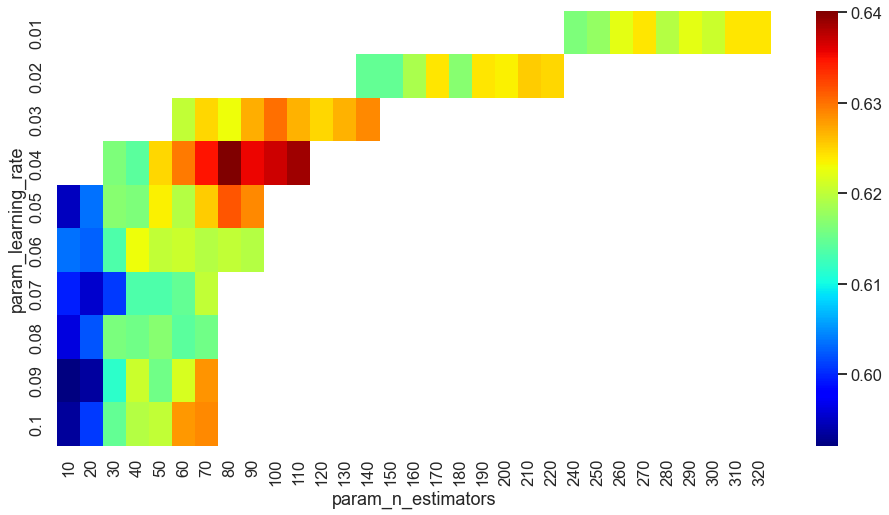

In [83]:
import seaborn as sns

# sns.heatmap(df, row='param_n_estimators', col='param_learning_rate', hue='mean_test_score')
with sns.axes_style('whitegrid'), sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(df_pivot, cmap='jet', ax=ax)
    plt.show()

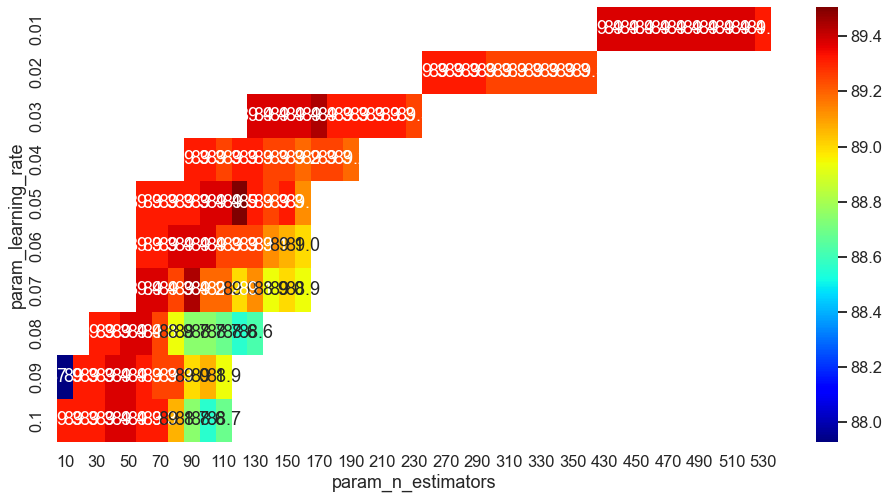

In [106]:
with sns.axes_style('whitegrid'), sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(df_pivot_h41, cmap='jet', ax=ax, annot=True, fmt='.1f')
    plt.show()

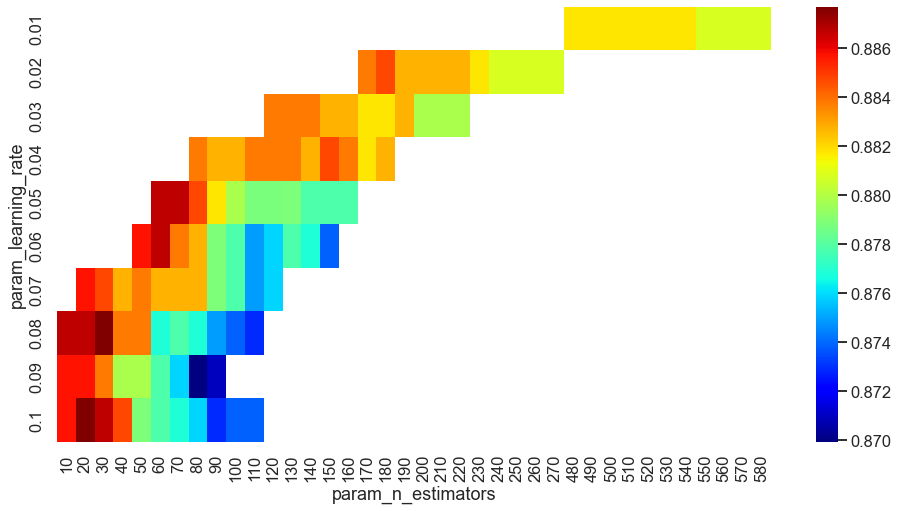

In [103]:
with sns.axes_style('whitegrid'), sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(df_pivot_m41, cmap='jet', ax=ax)
    plt.show()

## Step 2

In [111]:
from utils import Timer

def phase_2(data, cv_results, out_folder, n_jobs: int, data_name: str):
    """Adjust max_depth and min_child_weight"""
    out_folder = Path(out_folder)
    out_folder.mkdir(exist_ok=True, parents=True)
    idx = np.where(cv_results['rank_test_score'] == 1)[0][0]
    params = cv_results['params'][idx]

    train_x = data['train_x']
    train_y = data['train_y']
    test_x = data['test_x']
    test_y = data['test_y']

    model = XGBClassifier(
        **DEFAULT_PARAMS,
        **params,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        seed=SEED
    )
    param_grid = {
        'max_depth': range(1, 10, 1),
        'min_child_weight': range(1, 6, 1)
    }

    model = GridSearchCV(model, param_grid, n_jobs=n_jobs, cv=5,
                         return_train_score=True)
    timer = Timer(f'{data_name} CV2')
    timer.start()
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    timer.stop()
    results = {'cv_results': model.cv_results_,
               'cv_test': classification_report(test_y, pred)}

    with open(out_folder / 'phase2_results.pickle', 'wb') as f:
        pickle.dump(results, f)

    return results, model


In [113]:
for d in datasets:
    cur_data = get_iris_data(d)
    with open(f'results_xgb_params/{d}/phase1_cvmodel.pickle', 'rb') as f:
        m = pickle.load(f)
    cv_results = m.cv_results_
    out_folder = f'results_xgb_params/{d}'
    _, _ = phase_2(cur_data, cv_results, out_folder, n_jobs=5, data_name=d)

left_240x20_fixed CV2 0:30:58.663368
right_240x20_fixed CV2 0:21:56.855932
left_240x40_fixed CV2 0:22:47.465956
right_240x40_fixed CV2 0:19:23.018745
left_240x20 CV2 0:14:05.292153
right_240x20 CV2 0:09:51.731730
left_240x40 CV2 1:55:32.573883
right_240x40 CV2 0:23:42.732865


In [112]:
for d, cur_data in (('H41', h41_data), ('M41', m41_data)):
    with open(f'results_xgb_params/{d}/phase1_cvmodel.pickle', 'rb') as f:
        m = pickle.load(f)
    cv_results = m.cv_results_
    out_folder = f'results_xgb_params/{d}'
    _, _ = phase_2(cur_data, cv_results, out_folder, n_jobs=5, data_name=d)

H41 CV2 0:00:32.916701
M41 CV2 0:00:04.887415
